In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
# Point generation with noise
def gen_data(num_samples, noise=0):
    points = []
    labels = []

    for i in range(num_samples):
        x = np.random.uniform()
        y = np.random.uniform()

        nx = np.random.uniform(low=-noise/100, high=noise/100)
        ny = np.random.uniform(low=-noise/100, high=noise/100)

        if(-0.7*x-y+0.6 < 0 and -0.8*x-y+1.1 > 0 and 2.5*x-y > 0 and 5*x-y-3 < 0):
            if noise > 0:
                points.append([x+nx, y+ny, 0])
                labels.append(0)
            else:
                points.append([x, y, 0])
                labels.append(0)
        else:
            if noise > 0:
                points.append([x+nx, y+ny, 1])
                labels.append(1)
            else:
                points.append([x, y, 1])
                labels.append(1)

    return points, labels

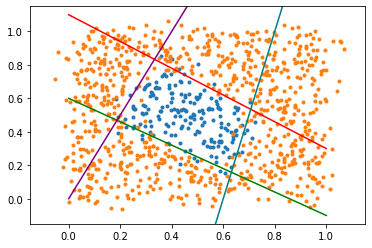

In [4]:
points, labels = gen_data(1000, 7)


plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

# plot lines
x = torch.linspace(0,1)
plt.plot(x, -(0.7*x-0.6), 'green')  # y = -0.7*x+0.6 => -0.7*x-y+0.6 >0
plt.plot(x, -(0.8*x-1.1), 'red')    # y = -0.8*x+1.1 => -0.8*x-y+1.1 < 0 
plt.plot(x, (2.5*x), 'purple')      # y = 2.5*x => 2.5*x-y < 0
plt.plot(x, (5*x-3), 'teal')        # y = 5*x-3 => 5*x-y-3 > 0

plt.ylim(-0.15, 1.15)
plt.xlim(-0.15, 1.15)
plt.show()

In [8]:
trainX = torch.Tensor([[i[0],i[1]] for i in points]).float()
trainY = torch.Tensor([[i[2]] for i in points]).float()

In [9]:
# implement class wrapper for squashing activation function
class Squashing(nn.Module):
    def __init__(self, learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(Squashing, self).__init__()

        # initialize fix parameters
        self.alpha = 0.5
        self.lam = 1.0

        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta 1:", self.beta.data.item())
        global betas
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )
    

In [10]:
# implement class wrapper for swish activation function
class Swish(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super(Swish, self).__init__()

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        return x * torch.sigmoid(x)

In [12]:
class Net4(nn.Module):
    def __init__(self, activation = 'squashing'):
        super(Net4,self).__init__()

        self.g1_layer = nn.Linear(in_features=2, out_features=1)
        self.g2_layer = nn.Linear(in_features=2, out_features=1)
        self.g3_layer = nn.Linear(in_features=2, out_features=1)
        self.g4_layer = nn.Linear(in_features=2, out_features=1)

        self.undgout = nn.Linear(in_features=4, out_features=1)
        
        self.undgout.bias.requires_grad  = False
        self.undgout.weight.requires_grad = False
  
        with torch.no_grad():
            self.undgout.bias.fill_(-3.0)
            self.undgout.weight.fill_(1.0)
        
        if activation == 'relu':
            print("relu")
            self.activation = nn.ReLU()
            
        elif activation == 'sigmoid':
            print("sigmoid")
            self.activation = nn.Sigmoid()
        
        elif activation == 'tanh':
            print("tanh")
            self.activation = nn.Tanh()
            
        elif activation == 'swish':
            print("swish")
            self.activation = Swish()
            
        elif activation == 'squashing':
            print("squashing")
            self.activation = Squashing()
            self.activation1 = Squashing()
            
        elif (activation == 'squashing-nl'):
            print("squashing-nl")
            self.activation = Squashing(False, beta=1)
            self.activation1 = Squashing(False, beta=-1)
        
        
    #This must be implemented
    def forward(self, x):
        global betaand
        global betagerade
        
        g1 = self.g1_layer(x)
        g1 = self.activation(g1)

        g2 = self.g2_layer(x)
        g2 = self.activation(g2)
        
        g3 = self.g3_layer(x)
        g3 = self.activation(g3)
        
        g4 = self.g4_layer(x)
        g4 = self.activation(g4)
        betagerade = betas

        z = self.undgout(torch.cat((g1,g2,g3,g4), 1))
        z = self.activation(z)
        betaand = betas

        return z
    

squashing
Epoch: 0
G1-Weight: tensor([[ 0.5451, -0.4054]]) G1-Bias: tensor([0.5732])
G2-Weight: tensor([[-0.3431, -0.6695]]) G2-Bias: tensor([0.3764])
G3-Weight: tensor([[-0.2520,  0.6391]]) G1-Bias: tensor([-0.3888])
G4-Weight: tensor([[0.2103, 0.0414]]) G2-Bias: tensor([-0.6760])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.5451 * x + 0.5732) / -0.4054)
z2: y = -((-0.3431 * x + 0.3764) / -0.6695)
z3: y = -((-0.252 * x + -0.3888) / 0.6391)
z4: y = -((0.2103 * x + -0.676) / 0.0414)
Beta-Gerade: 0.10000000149011612
Beta-AND: 0.10000000149011612


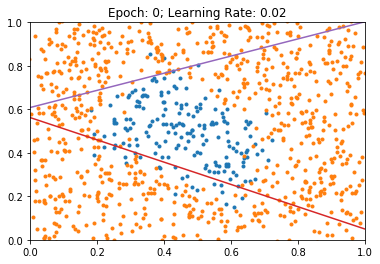

Epoch: 10
G1-Weight: tensor([[ 0.6741, -0.2765]]) G1-Bias: tensor([0.7021])
G2-Weight: tensor([[-0.2142, -0.5405]]) G2-Bias: tensor([0.5053])
G3-Weight: tensor([[-0.1231,  0.7680]]) G1-Bias: tensor([-0.2599])
G4-Weight: tensor([[0.3393, 0.1704]]) G2-Bias: tensor([-0.5470])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.6741 * x + 0.7021) / -0.2765)
z2: y = -((-0.2142 * x + 0.5053) / -0.5405)
z3: y = -((-0.1231 * x + -0.2599) / 0.768)
z4: y = -((0.3393 * x + -0.547) / 0.1704)
Beta-Gerade: -0.03367023169994354
Beta-AND: -0.08956710994243622


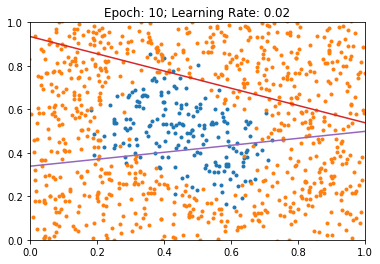

Epoch: 20
G1-Weight: tensor([[ 0.7606, -0.1900]]) G1-Bias: tensor([0.7884])
G2-Weight: tensor([[-0.1276, -0.4540]]) G2-Bias: tensor([0.5916])
G3-Weight: tensor([[-0.0365,  0.8545]]) G1-Bias: tensor([-0.1735])
G4-Weight: tensor([[0.4259, 0.2569]]) G2-Bias: tensor([-0.4606])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.7606 * x + 0.7884) / -0.19)
z2: y = -((-0.1276 * x + 0.5916) / -0.454)
z3: y = -((-0.0365 * x + -0.1735) / 0.8545)
z4: y = -((0.4259 * x + -0.4606) / 0.2569)
Beta-Gerade: 0.04552075266838074
Beta-AND: -0.27392974495887756


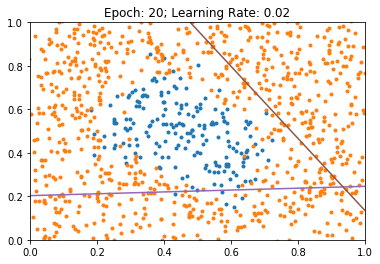

Epoch: 30
G1-Weight: tensor([[ 0.5791, -0.3713]]) G1-Bias: tensor([0.6078])
G2-Weight: tensor([[-0.3091, -0.6353]]) G2-Bias: tensor([0.4110])
G3-Weight: tensor([[-0.2180,  0.6732]]) G1-Bias: tensor([-0.3542])
G4-Weight: tensor([[0.2444, 0.0756]]) G2-Bias: tensor([-0.6413])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.5791 * x + 0.6078) / -0.3713)
z2: y = -((-0.3091 * x + 0.411) / -0.6353)
z3: y = -((-0.218 * x + -0.3542) / 0.6732)
z4: y = -((0.2444 * x + -0.6413) / 0.0756)
Beta-Gerade: 0.20955359935760498
Beta-AND: -0.4418432116508484


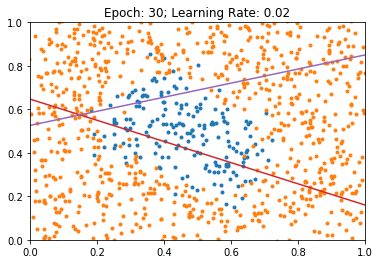

Epoch: 40
G1-Weight: tensor([[ 0.3102, -0.6396]]) G1-Bias: tensor([0.3398])
G2-Weight: tensor([[-0.5771, -0.9027]]) G2-Bias: tensor([0.1436])
G3-Weight: tensor([[-0.4862,  0.4051]]) G1-Bias: tensor([-0.6216])
G4-Weight: tensor([[-0.0236, -0.1918]]) G2-Bias: tensor([-0.9083])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.3102 * x + 0.3398) / -0.6396)
z2: y = -((-0.5771 * x + 0.1436) / -0.9027)
z3: y = -((-0.4862 * x + -0.6216) / 0.4051)
z4: y = -((-0.0236 * x + -0.9083) / -0.1918)
Beta-Gerade: 0.46093183755874634
Beta-AND: -0.5781922936439514


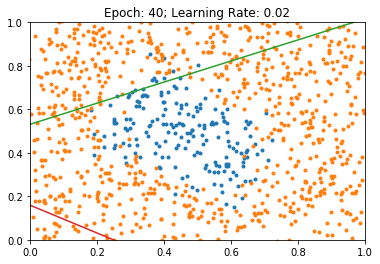

Epoch: 50
G1-Weight: tensor([[ 0.0817, -0.8574]]) G1-Bias: tensor([0.1225])
G2-Weight: tensor([[-0.7921, -1.1078]]) G2-Bias: tensor([-0.0679])
G3-Weight: tensor([[-0.7045,  0.1858]]) G1-Bias: tensor([-0.8354])
G4-Weight: tensor([[-0.2430, -0.4033]]) G2-Bias: tensor([-1.1201])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.0817 * x + 0.1225) / -0.8574)
z2: y = -((-0.7921 * x + -0.0679) / -1.1078)
z3: y = -((-0.7045 * x + -0.8354) / 0.1858)
z4: y = -((-0.243 * x + -1.1201) / -0.4033)
Beta-Gerade: 0.6797681450843811
Beta-AND: -0.6629675030708313


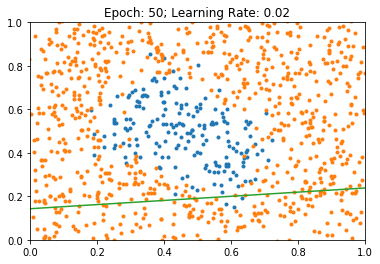

Epoch: 60
G1-Weight: tensor([[ 0.0356, -0.8686]]) G1-Bias: tensor([0.1102])
G2-Weight: tensor([[-0.8162, -1.1058]]) G2-Bias: tensor([-0.0857])
G3-Weight: tensor([[-0.7390,  0.1480]]) G1-Bias: tensor([-0.8596])
G4-Weight: tensor([[-0.2929, -0.4321]]) G2-Bias: tensor([-1.1519])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.0356 * x + 0.1102) / -0.8686)
z2: y = -((-0.8162 * x + -0.0857) / -1.1058)
z3: y = -((-0.739 * x + -0.8596) / 0.148)
z4: y = -((-0.2929 * x + -1.1519) / -0.4321)
Beta-Gerade: 0.7188512086868286
Beta-AND: -0.6884684562683105


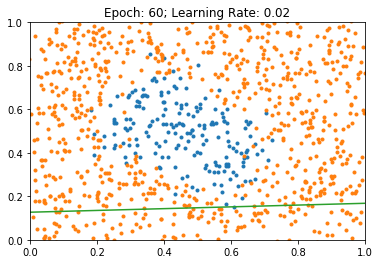

Epoch: 70
G1-Weight: tensor([[ 0.0999, -0.7630]]) G1-Bias: tensor([0.2160])
G2-Weight: tensor([[-0.7320, -0.9922]]) G2-Bias: tensor([0.0070])
G3-Weight: tensor([[-0.6680,  0.2151]]) G1-Bias: tensor([-0.7755])
G4-Weight: tensor([[-0.2447, -0.3589]]) G2-Bias: tensor([-1.0816])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.0999 * x + 0.216) / -0.763)
z2: y = -((-0.732 * x + 0.007) / -0.9922)
z3: y = -((-0.668 * x + -0.7755) / 0.2151)
z4: y = -((-0.2447 * x + -1.0816) / -0.3589)
Beta-Gerade: 0.6399781107902527
Beta-AND: -0.6812627911567688


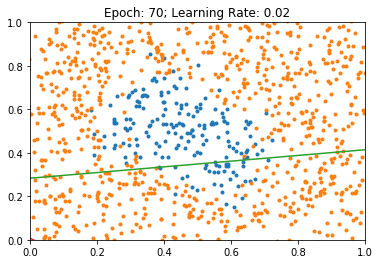

Epoch: 80
G1-Weight: tensor([[ 0.1328, -0.6900]]) G1-Bias: tensor([0.2931])
G2-Weight: tensor([[-0.6709, -0.9019]]) G2-Bias: tensor([0.0805])
G3-Weight: tensor([[-0.6189,  0.2597]]) G1-Bias: tensor([-0.7108])
G4-Weight: tensor([[-0.2137, -0.3024]]) G2-Bias: tensor([-1.0260])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.1328 * x + 0.2931) / -0.69)
z2: y = -((-0.6709 * x + 0.0805) / -0.9019)
z3: y = -((-0.6189 * x + -0.7108) / 0.2597)
z4: y = -((-0.2137 * x + -1.026) / -0.3024)
Beta-Gerade: 0.5706141591072083
Beta-AND: -0.6718311309814453


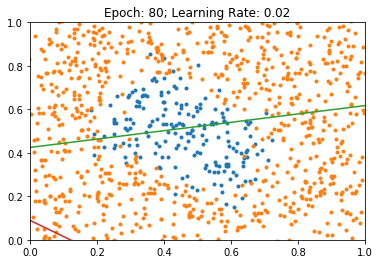

Epoch: 90
G1-Weight: tensor([[ 0.0929, -0.6928]]) G1-Bias: tensor([0.2981])
G2-Weight: tensor([[-0.6774, -0.8798]]) G2-Bias: tensor([0.0901])
G3-Weight: tensor([[-0.6344,  0.2391]]) G1-Bias: tensor([-0.7085])
G4-Weight: tensor([[-0.2406, -0.3053]]) G2-Bias: tensor([-1.0268])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.0929 * x + 0.2981) / -0.6928)
z2: y = -((-0.6774 * x + 0.0901) / -0.8798)
z3: y = -((-0.6344 * x + -0.7085) / 0.2391)
z4: y = -((-0.2406 * x + -1.0268) / -0.3053)
Beta-Gerade: 0.5636076927185059
Beta-AND: -0.6723047494888306


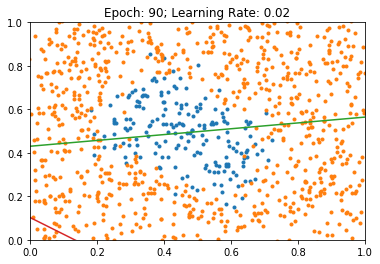

Epoch: 100
G1-Weight: tensor([[ 0.0287, -0.7221]]) G1-Bias: tensor([0.2784])
G2-Weight: tensor([[-0.7068, -0.8818]]) G2-Bias: tensor([0.0780])
G3-Weight: tensor([[-0.6709,  0.1959]]) G1-Bias: tensor([-0.7274])
G4-Weight: tensor([[-0.2861, -0.3285]]) G2-Bias: tensor([-1.0466])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((0.0287 * x + 0.2784) / -0.7221)
z2: y = -((-0.7068 * x + 0.078) / -0.8818)
z3: y = -((-0.6709 * x + -0.7274) / 0.1959)
z4: y = -((-0.2861 * x + -1.0466) / -0.3285)
Beta-Gerade: 0.5833266973495483
Beta-AND: -0.6770811676979065


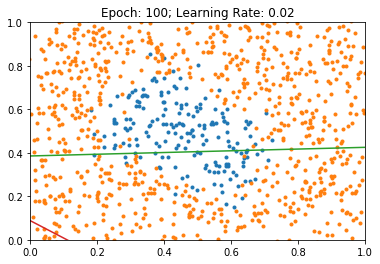

Epoch: 110
G1-Weight: tensor([[-0.0181, -0.7341]]) G1-Bias: tensor([0.2759])
G2-Weight: tensor([[-0.7182, -0.8670]]) G2-Bias: tensor([0.0832])
G3-Weight: tensor([[-0.6892,  0.1689]]) G1-Bias: tensor([-0.7298])
G4-Weight: tensor([[-0.3142, -0.3354]]) G2-Bias: tensor([-1.0505])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.0181 * x + 0.2759) / -0.7341)
z2: y = -((-0.7182 * x + 0.0832) / -0.867)
z3: y = -((-0.6892 * x + -0.7298) / 0.1689)
z4: y = -((-0.3142 * x + -1.0505) / -0.3354)
Beta-Gerade: 0.5885099768638611
Beta-AND: -0.6791149973869324


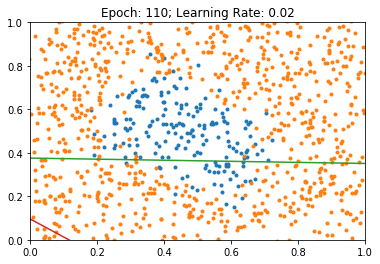

Epoch: 120
G1-Weight: tensor([[-0.0500, -0.7314]]) G1-Bias: tensor([0.2879])
G2-Weight: tensor([[-0.7147, -0.8386]]) G2-Bias: tensor([0.1026])
G3-Weight: tensor([[-0.6922,  0.1553]]) G1-Bias: tensor([-0.7187])
G4-Weight: tensor([[-0.3279, -0.3293]]) G2-Bias: tensor([-1.0417])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.05 * x + 0.2879) / -0.7314)
z2: y = -((-0.7147 * x + 0.1026) / -0.8386)
z3: y = -((-0.6922 * x + -0.7187) / 0.1553)
z4: y = -((-0.3279 * x + -1.0417) / -0.3293)
Beta-Gerade: 0.5786915421485901
Beta-AND: -0.6784469485282898


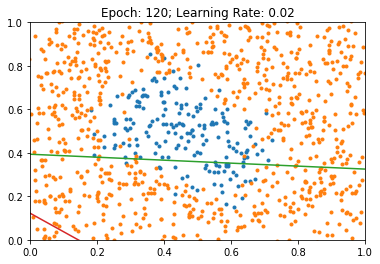

Epoch: 130
G1-Weight: tensor([[-0.0836, -0.7319]]) G1-Bias: tensor([0.2969])
G2-Weight: tensor([[-0.7137, -0.8144]]) G2-Bias: tensor([0.1191])
G3-Weight: tensor([[-0.6963,  0.1388]]) G1-Bias: tensor([-0.7103])
G4-Weight: tensor([[-0.3424, -0.3257]]) G2-Bias: tensor([-1.0353])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.0836 * x + 0.2969) / -0.7319)
z2: y = -((-0.7137 * x + 0.1191) / -0.8144)
z3: y = -((-0.6963 * x + -0.7103) / 0.1388)
z4: y = -((-0.3424 * x + -1.0353) / -0.3257)
Beta-Gerade: 0.5706842541694641
Beta-AND: -0.6780803203582764


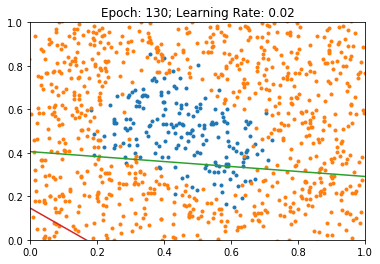

Epoch: 140
G1-Weight: tensor([[-0.1220, -0.7385]]) G1-Bias: tensor([0.2998])
G2-Weight: tensor([[-0.7185, -0.7977]]) G2-Bias: tensor([0.1293])
G3-Weight: tensor([[-0.7047,  0.1165]]) G1-Bias: tensor([-0.7077])
G4-Weight: tensor([[-0.3606, -0.3278]]) G2-Bias: tensor([-1.0342])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.122 * x + 0.2998) / -0.7385)
z2: y = -((-0.7185 * x + 0.1293) / -0.7977)
z3: y = -((-0.7047 * x + -0.7077) / 0.1165)
z4: y = -((-0.3606 * x + -1.0342) / -0.3278)
Beta-Gerade: 0.5691779255867004
Beta-AND: -0.6788485646247864


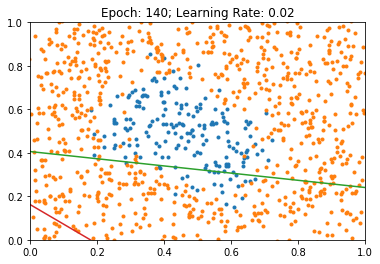

Epoch: 150
G1-Weight: tensor([[-0.1589, -0.7449]]) G1-Bias: tensor([0.3028])
G2-Weight: tensor([[-0.7228, -0.7821]]) G2-Bias: tensor([0.1395])
G3-Weight: tensor([[-0.7114,  0.0944]]) G1-Bias: tensor([-0.7052])
G4-Weight: tensor([[-0.3771, -0.3299]]) G2-Bias: tensor([-1.0331])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.1589 * x + 0.3028) / -0.7449)
z2: y = -((-0.7228 * x + 0.1395) / -0.7821)
z3: y = -((-0.7114 * x + -0.7052) / 0.0944)
z4: y = -((-0.3771 * x + -1.0331) / -0.3299)
Beta-Gerade: 0.5683774948120117
Beta-AND: -0.6797531247138977


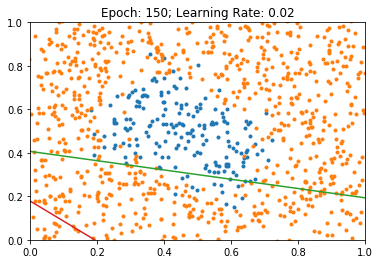

Epoch: 160
G1-Weight: tensor([[-0.1919, -0.7484]]) G1-Bias: tensor([0.3084])
G2-Weight: tensor([[-0.7244, -0.7653]]) G2-Bias: tensor([0.1519])
G3-Weight: tensor([[-0.7145,  0.0746]]) G1-Bias: tensor([-0.7006])
G4-Weight: tensor([[-0.3899, -0.3300]]) G2-Bias: tensor([-1.0300])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.1919 * x + 0.3084) / -0.7484)
z2: y = -((-0.7244 * x + 0.1519) / -0.7653)
z3: y = -((-0.7145 * x + -0.7006) / 0.0746)
z4: y = -((-0.3899 * x + -1.03) / -0.33)
Beta-Gerade: 0.5653891563415527
Beta-AND: -0.6802994608879089


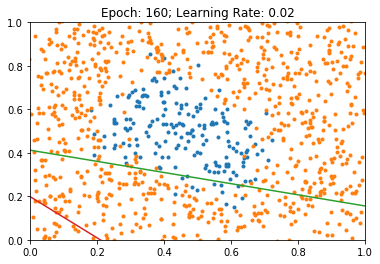

Epoch: 170
G1-Weight: tensor([[-0.2231, -0.7513]]) G1-Bias: tensor([0.3144])
G2-Weight: tensor([[-0.7254, -0.7495]]) G2-Bias: tensor([0.1643])
G3-Weight: tensor([[-0.7160,  0.0554]]) G1-Bias: tensor([-0.6958])
G4-Weight: tensor([[-0.4011, -0.3298]]) G2-Bias: tensor([-1.0268])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.2231 * x + 0.3144) / -0.7513)
z2: y = -((-0.7254 * x + 0.1643) / -0.7495)
z3: y = -((-0.716 * x + -0.6958) / 0.0554)
z4: y = -((-0.4011 * x + -1.0268) / -0.3298)
Beta-Gerade: 0.5620982646942139
Beta-AND: -0.6808133125305176


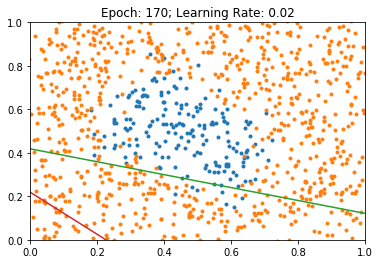

Epoch: 180
G1-Weight: tensor([[-0.2536, -0.7547]]) G1-Bias: tensor([0.3198])
G2-Weight: tensor([[-0.7270, -0.7356]]) G2-Bias: tensor([0.1758])
G3-Weight: tensor([[-0.7170,  0.0357]]) G1-Bias: tensor([-0.6919])
G4-Weight: tensor([[-0.4117, -0.3305]]) G2-Bias: tensor([-1.0243])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.2536 * x + 0.3198) / -0.7547)
z2: y = -((-0.727 * x + 0.1758) / -0.7356)
z3: y = -((-0.717 * x + -0.6919) / 0.0357)
z4: y = -((-0.4117 * x + -1.0243) / -0.3305)
Beta-Gerade: 0.5597882270812988
Beta-AND: -0.6815150380134583


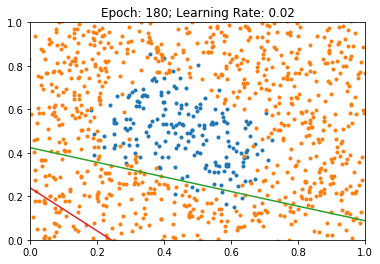

Epoch: 190
G1-Weight: tensor([[-0.2826, -0.7577]]) G1-Bias: tensor([0.3253])
G2-Weight: tensor([[-0.7286, -0.7229]]) G2-Bias: tensor([0.1870])
G3-Weight: tensor([[-0.7170,  0.0163]]) G1-Bias: tensor([-0.6882])
G4-Weight: tensor([[-0.4210, -0.3313]]) G2-Bias: tensor([-1.0221])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.2826 * x + 0.3253) / -0.7577)
z2: y = -((-0.7286 * x + 0.187) / -0.7229)
z3: y = -((-0.717 * x + -0.6882) / 0.0163)
z4: y = -((-0.421 * x + -1.0221) / -0.3313)
Beta-Gerade: 0.5577823519706726
Beta-AND: -0.682290256023407


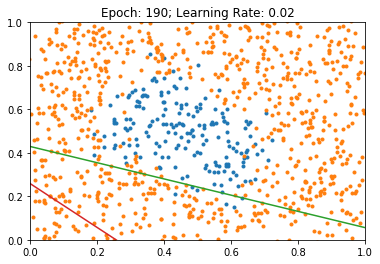

Epoch: 200
G1-Weight: tensor([[-0.3099, -0.7599]]) G1-Bias: tensor([0.3313])
G2-Weight: tensor([[-0.7297, -0.7108]]) G2-Bias: tensor([0.1984])
G3-Weight: tensor([[-0.7157, -0.0024]]) G1-Bias: tensor([-0.6843])
G4-Weight: tensor([[-0.4290, -0.3318]]) G2-Bias: tensor([-1.0196])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.3099 * x + 0.3313) / -0.7599)
z2: y = -((-0.7297 * x + 0.1984) / -0.7108)
z3: y = -((-0.7157 * x + -0.6843) / -0.0024)
z4: y = -((-0.429 * x + -1.0196) / -0.3318)
Beta-Gerade: 0.5555613040924072
Beta-AND: -0.6830515265464783


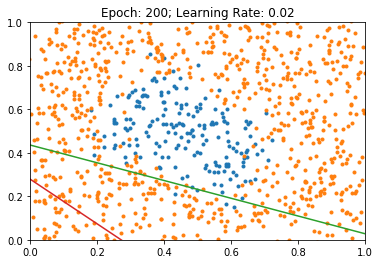

Epoch: 210
G1-Weight: tensor([[-0.3357, -0.7617]]) G1-Bias: tensor([0.3375])
G2-Weight: tensor([[-0.7306, -0.6997]]) G2-Bias: tensor([0.2096])
G3-Weight: tensor([[-0.7135, -0.0206]]) G1-Bias: tensor([-0.6805])
G4-Weight: tensor([[-0.4358, -0.3323]]) G2-Bias: tensor([-1.0172])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.3357 * x + 0.3375) / -0.7617)
z2: y = -((-0.7306 * x + 0.2096) / -0.6997)
z3: y = -((-0.7135 * x + -0.6805) / -0.0206)
z4: y = -((-0.4358 * x + -1.0172) / -0.3323)
Beta-Gerade: 0.5533775091171265
Beta-AND: -0.6838417053222656


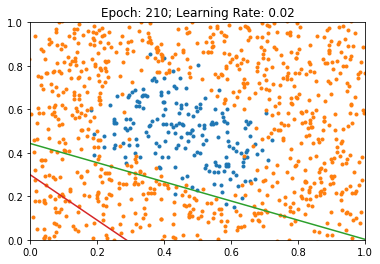

Epoch: 220
G1-Weight: tensor([[-0.3603, -0.7631]]) G1-Bias: tensor([0.3438])
G2-Weight: tensor([[-0.7316, -0.6896]]) G2-Bias: tensor([0.2206])
G3-Weight: tensor([[-0.7106, -0.0384]]) G1-Bias: tensor([-0.6769])
G4-Weight: tensor([[-0.4417, -0.3328]]) G2-Bias: tensor([-1.0149])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.3603 * x + 0.3438) / -0.7631)
z2: y = -((-0.7316 * x + 0.2206) / -0.6896)
z3: y = -((-0.7106 * x + -0.6769) / -0.0384)
z4: y = -((-0.4417 * x + -1.0149) / -0.3328)
Beta-Gerade: 0.5514023900032043
Beta-AND: -0.6846889853477478


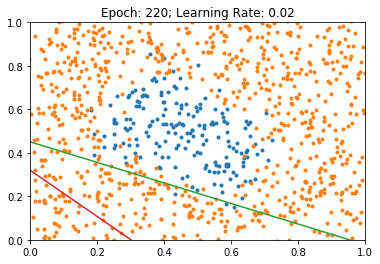

Epoch: 230
G1-Weight: tensor([[-0.3836, -0.7641]]) G1-Bias: tensor([0.3504])
G2-Weight: tensor([[-0.7327, -0.6804]]) G2-Bias: tensor([0.2316])
G3-Weight: tensor([[-0.7069, -0.0557]]) G1-Bias: tensor([-0.6734])
G4-Weight: tensor([[-0.4468, -0.3334]]) G2-Bias: tensor([-1.0128])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.3836 * x + 0.3504) / -0.7641)
z2: y = -((-0.7327 * x + 0.2316) / -0.6804)
z3: y = -((-0.7069 * x + -0.6734) / -0.0557)
z4: y = -((-0.4468 * x + -1.0128) / -0.3334)
Beta-Gerade: 0.549515962600708
Beta-AND: -0.6855730414390564


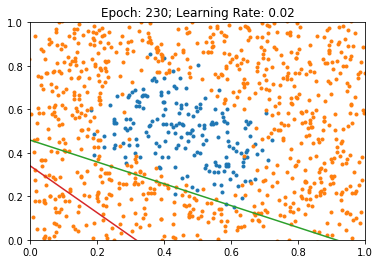

Epoch: 240
G1-Weight: tensor([[-0.4056, -0.7647]]) G1-Bias: tensor([0.3573])
G2-Weight: tensor([[-0.7337, -0.6719]]) G2-Bias: tensor([0.2424])
G3-Weight: tensor([[-0.7027, -0.0723]]) G1-Bias: tensor([-0.6699])
G4-Weight: tensor([[-0.4510, -0.3339]]) G2-Bias: tensor([-1.0107])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.4056 * x + 0.3573) / -0.7647)
z2: y = -((-0.7337 * x + 0.2424) / -0.6719)
z3: y = -((-0.7027 * x + -0.6699) / -0.0723)
z4: y = -((-0.451 * x + -1.0107) / -0.3339)
Beta-Gerade: 0.5476570129394531
Beta-AND: -0.6864826083183289


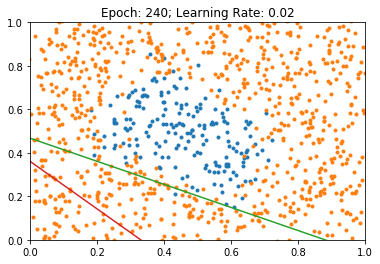

Epoch: 250
G1-Weight: tensor([[-0.4264, -0.7649]]) G1-Bias: tensor([0.3644])
G2-Weight: tensor([[-0.7347, -0.6642]]) G2-Bias: tensor([0.2532])
G3-Weight: tensor([[-0.6980, -0.0884]]) G1-Bias: tensor([-0.6665])
G4-Weight: tensor([[-0.4546, -0.3343]]) G2-Bias: tensor([-1.0086])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.4264 * x + 0.3644) / -0.7649)
z2: y = -((-0.7347 * x + 0.2532) / -0.6642)
z3: y = -((-0.698 * x + -0.6665) / -0.0884)
z4: y = -((-0.4546 * x + -1.0086) / -0.3343)
Beta-Gerade: 0.545870840549469
Beta-AND: -0.6874243021011353


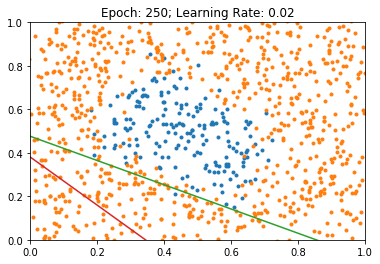

Epoch: 260
G1-Weight: tensor([[-0.4462, -0.7648]]) G1-Bias: tensor([0.3717])
G2-Weight: tensor([[-0.7359, -0.6572]]) G2-Bias: tensor([0.2639])
G3-Weight: tensor([[-0.6928, -0.1039]]) G1-Bias: tensor([-0.6631])
G4-Weight: tensor([[-0.4575, -0.3347]]) G2-Bias: tensor([-1.0066])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.4462 * x + 0.3717) / -0.7648)
z2: y = -((-0.7359 * x + 0.2639) / -0.6572)
z3: y = -((-0.6928 * x + -0.6631) / -0.1039)
z4: y = -((-0.4575 * x + -1.0066) / -0.3347)
Beta-Gerade: 0.5441652536392212
Beta-AND: -0.6883983612060547


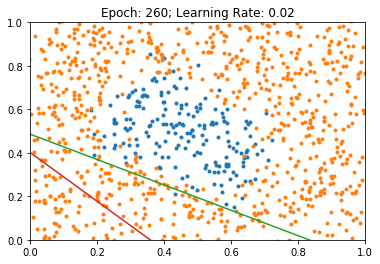

Epoch: 270
G1-Weight: tensor([[-0.4649, -0.7643]]) G1-Bias: tensor([0.3792])
G2-Weight: tensor([[-0.7371, -0.6508]]) G2-Bias: tensor([0.2745])
G3-Weight: tensor([[-0.6874, -0.1188]]) G1-Bias: tensor([-0.6599])
G4-Weight: tensor([[-0.4598, -0.3351]]) G2-Bias: tensor([-1.0047])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.4649 * x + 0.3792) / -0.7643)
z2: y = -((-0.7371 * x + 0.2745) / -0.6508)
z3: y = -((-0.6874 * x + -0.6599) / -0.1188)
z4: y = -((-0.4598 * x + -1.0047) / -0.3351)
Beta-Gerade: 0.5425159335136414
Beta-AND: -0.6893995404243469


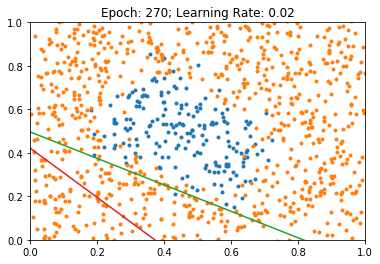

Epoch: 280
G1-Weight: tensor([[-0.4827, -0.7635]]) G1-Bias: tensor([0.3870])
G2-Weight: tensor([[-0.7385, -0.6450]]) G2-Bias: tensor([0.2851])
G3-Weight: tensor([[-0.6816, -0.1331]]) G1-Bias: tensor([-0.6567])
G4-Weight: tensor([[-0.4617, -0.3354]]) G2-Bias: tensor([-1.0028])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.4827 * x + 0.387) / -0.7635)
z2: y = -((-0.7385 * x + 0.2851) / -0.645)
z3: y = -((-0.6816 * x + -0.6567) / -0.1331)
z4: y = -((-0.4617 * x + -1.0028) / -0.3354)
Beta-Gerade: 0.5409203171730042
Beta-AND: -0.6904262900352478


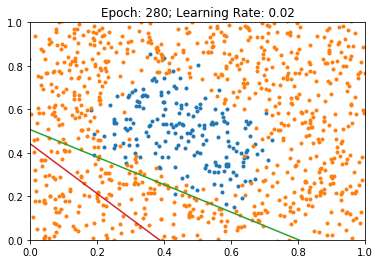

Epoch: 290
G1-Weight: tensor([[-0.4995, -0.7624]]) G1-Bias: tensor([0.3951])
G2-Weight: tensor([[-0.7400, -0.6398]]) G2-Bias: tensor([0.2957])
G3-Weight: tensor([[-0.6757, -0.1469]]) G1-Bias: tensor([-0.6535])
G4-Weight: tensor([[-0.4631, -0.3357]]) G2-Bias: tensor([-1.0010])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.4995 * x + 0.3951) / -0.7624)
z2: y = -((-0.74 * x + 0.2957) / -0.6398)
z3: y = -((-0.6757 * x + -0.6535) / -0.1469)
z4: y = -((-0.4631 * x + -1.001) / -0.3357)
Beta-Gerade: 0.5393839478492737
Beta-AND: -0.6914781928062439


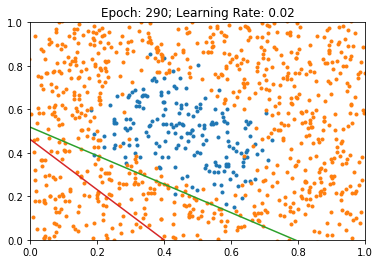

Epoch: 300
G1-Weight: tensor([[-0.5155, -0.7611]]) G1-Bias: tensor([0.4034])
G2-Weight: tensor([[-0.7416, -0.6351]]) G2-Bias: tensor([0.3063])
G3-Weight: tensor([[-0.6695, -0.1600]]) G1-Bias: tensor([-0.6504])
G4-Weight: tensor([[-0.4641, -0.3359]]) G2-Bias: tensor([-0.9993])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.5155 * x + 0.4034) / -0.7611)
z2: y = -((-0.7416 * x + 0.3063) / -0.6351)
z3: y = -((-0.6695 * x + -0.6504) / -0.16)
z4: y = -((-0.4641 * x + -0.9993) / -0.3359)
Beta-Gerade: 0.5379028916358948
Beta-AND: -0.6925533413887024


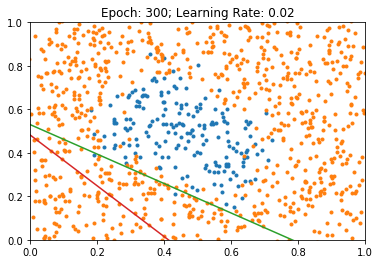

Epoch: 310
G1-Weight: tensor([[-0.5308, -0.7596]]) G1-Bias: tensor([0.4119])
G2-Weight: tensor([[-0.7433, -0.6309]]) G2-Bias: tensor([0.3169])
G3-Weight: tensor([[-0.6633, -0.1725]]) G1-Bias: tensor([-0.6473])
G4-Weight: tensor([[-0.4647, -0.3361]]) G2-Bias: tensor([-0.9975])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.5308 * x + 0.4119) / -0.7596)
z2: y = -((-0.7433 * x + 0.3169) / -0.6309)
z3: y = -((-0.6633 * x + -0.6473) / -0.1725)
z4: y = -((-0.4647 * x + -0.9975) / -0.3361)
Beta-Gerade: 0.5364740490913391
Beta-AND: -0.69364994764328


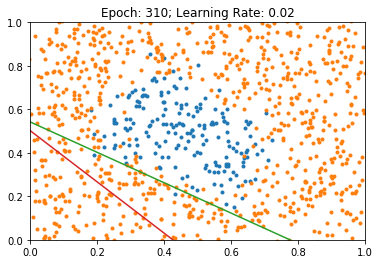

Epoch: 320
G1-Weight: tensor([[-0.5452, -0.7579]]) G1-Bias: tensor([0.4207])
G2-Weight: tensor([[-0.7451, -0.6271]]) G2-Bias: tensor([0.3276])
G3-Weight: tensor([[-0.6570, -0.1845]]) G1-Bias: tensor([-0.6443])
G4-Weight: tensor([[-0.4651, -0.3363]]) G2-Bias: tensor([-0.9958])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.5452 * x + 0.4207) / -0.7579)
z2: y = -((-0.7451 * x + 0.3276) / -0.6271)
z3: y = -((-0.657 * x + -0.6443) / -0.1845)
z4: y = -((-0.4651 * x + -0.9958) / -0.3363)
Beta-Gerade: 0.5350980162620544
Beta-AND: -0.6947668790817261


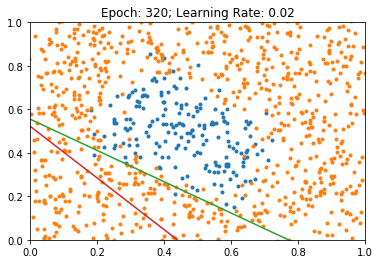

Epoch: 330
G1-Weight: tensor([[-0.5590, -0.7561]]) G1-Bias: tensor([0.4297])
G2-Weight: tensor([[-0.7470, -0.6237]]) G2-Bias: tensor([0.3383])
G3-Weight: tensor([[-0.6506, -0.1959]]) G1-Bias: tensor([-0.6413])
G4-Weight: tensor([[-0.4651, -0.3363]]) G2-Bias: tensor([-0.9942])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.559 * x + 0.4297) / -0.7561)
z2: y = -((-0.747 * x + 0.3383) / -0.6237)
z3: y = -((-0.6506 * x + -0.6413) / -0.1959)
z4: y = -((-0.4651 * x + -0.9942) / -0.3363)
Beta-Gerade: 0.5337747931480408
Beta-AND: -0.6959028244018555


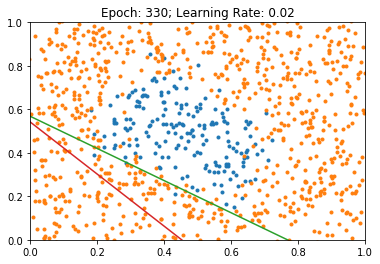

Epoch: 340
G1-Weight: tensor([[-0.5721, -0.7541]]) G1-Bias: tensor([0.4390])
G2-Weight: tensor([[-0.7491, -0.6208]]) G2-Bias: tensor([0.3490])
G3-Weight: tensor([[-0.6442, -0.2067]]) G1-Bias: tensor([-0.6383])
G4-Weight: tensor([[-0.4650, -0.3364]]) G2-Bias: tensor([-0.9926])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.5721 * x + 0.439) / -0.7541)
z2: y = -((-0.7491 * x + 0.349) / -0.6208)
z3: y = -((-0.6442 * x + -0.6383) / -0.2067)
z4: y = -((-0.465 * x + -0.9926) / -0.3364)
Beta-Gerade: 0.5325037240982056
Beta-AND: -0.6970565915107727


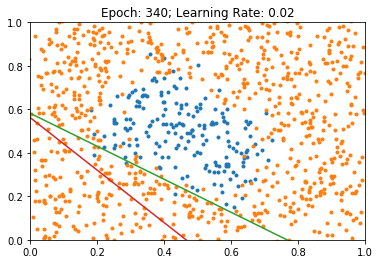

Epoch: 350
G1-Weight: tensor([[-0.5847, -0.7520]]) G1-Bias: tensor([0.4485])
G2-Weight: tensor([[-0.7513, -0.6181]]) G2-Bias: tensor([0.3599])
G3-Weight: tensor([[-0.6379, -0.2170]]) G1-Bias: tensor([-0.6353])
G4-Weight: tensor([[-0.4646, -0.3363]]) G2-Bias: tensor([-0.9910])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.5847 * x + 0.4485) / -0.752)
z2: y = -((-0.7513 * x + 0.3599) / -0.6181)
z3: y = -((-0.6379 * x + -0.6353) / -0.217)
z4: y = -((-0.4646 * x + -0.991) / -0.3363)
Beta-Gerade: 0.5312851667404175
Beta-AND: -0.698227047920227


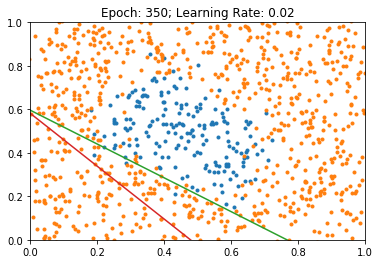

Epoch: 360
G1-Weight: tensor([[-0.5966, -0.7498]]) G1-Bias: tensor([0.4583])
G2-Weight: tensor([[-0.7535, -0.6158]]) G2-Bias: tensor([0.3708])
G3-Weight: tensor([[-0.6316, -0.2268]]) G1-Bias: tensor([-0.6324])
G4-Weight: tensor([[-0.4640, -0.3363]]) G2-Bias: tensor([-0.9894])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.5966 * x + 0.4583) / -0.7498)
z2: y = -((-0.7535 * x + 0.3708) / -0.6158)
z3: y = -((-0.6316 * x + -0.6324) / -0.2268)
z4: y = -((-0.464 * x + -0.9894) / -0.3363)
Beta-Gerade: 0.5301195979118347
Beta-AND: -0.6994131803512573


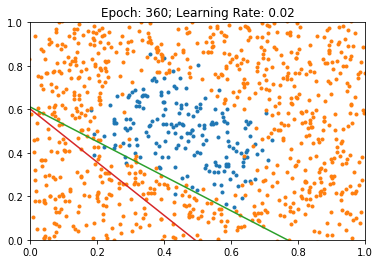

Epoch: 370
G1-Weight: tensor([[-0.6081, -0.7476]]) G1-Bias: tensor([0.4683])
G2-Weight: tensor([[-0.7559, -0.6138]]) G2-Bias: tensor([0.3819])
G3-Weight: tensor([[-0.6253, -0.2360]]) G1-Bias: tensor([-0.6295])
G4-Weight: tensor([[-0.4632, -0.3361]]) G2-Bias: tensor([-0.9879])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6081 * x + 0.4683) / -0.7476)
z2: y = -((-0.7559 * x + 0.3819) / -0.6138)
z3: y = -((-0.6253 * x + -0.6295) / -0.236)
z4: y = -((-0.4632 * x + -0.9879) / -0.3361)
Beta-Gerade: 0.5290080904960632
Beta-AND: -0.7006142139434814


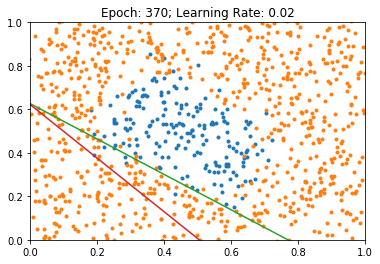

Epoch: 380
G1-Weight: tensor([[-0.6190, -0.7454]]) G1-Bias: tensor([0.4786])
G2-Weight: tensor([[-0.7583, -0.6121]]) G2-Bias: tensor([0.3931])
G3-Weight: tensor([[-0.6191, -0.2447]]) G1-Bias: tensor([-0.6266])
G4-Weight: tensor([[-0.4622, -0.3360]]) G2-Bias: tensor([-0.9864])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.619 * x + 0.4786) / -0.7454)
z2: y = -((-0.7583 * x + 0.3931) / -0.6121)
z3: y = -((-0.6191 * x + -0.6266) / -0.2447)
z4: y = -((-0.4622 * x + -0.9864) / -0.336)
Beta-Gerade: 0.5279510617256165
Beta-AND: -0.7018290758132935


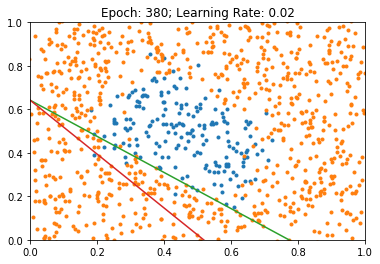

Epoch: 390
G1-Weight: tensor([[-0.6295, -0.7431]]) G1-Bias: tensor([0.4891])
G2-Weight: tensor([[-0.7608, -0.6106]]) G2-Bias: tensor([0.4044])
G3-Weight: tensor([[-0.6129, -0.2530]]) G1-Bias: tensor([-0.6237])
G4-Weight: tensor([[-0.4611, -0.3357]]) G2-Bias: tensor([-0.9849])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6295 * x + 0.4891) / -0.7431)
z2: y = -((-0.7608 * x + 0.4044) / -0.6106)
z3: y = -((-0.6129 * x + -0.6237) / -0.253)
z4: y = -((-0.4611 * x + -0.9849) / -0.3357)
Beta-Gerade: 0.526950478553772
Beta-AND: -0.7030572295188904


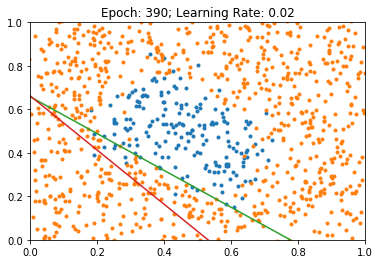

Epoch: 400
G1-Weight: tensor([[-0.6396, -0.7408]]) G1-Bias: tensor([0.4999])
G2-Weight: tensor([[-0.7634, -0.6094]]) G2-Bias: tensor([0.4158])
G3-Weight: tensor([[-0.6068, -0.2607]]) G1-Bias: tensor([-0.6208])
G4-Weight: tensor([[-0.4599, -0.3355]]) G2-Bias: tensor([-0.9834])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6396 * x + 0.4999) / -0.7408)
z2: y = -((-0.7634 * x + 0.4158) / -0.6094)
z3: y = -((-0.6068 * x + -0.6208) / -0.2607)
z4: y = -((-0.4599 * x + -0.9834) / -0.3355)
Beta-Gerade: 0.5260075330734253
Beta-AND: -0.7042980194091797


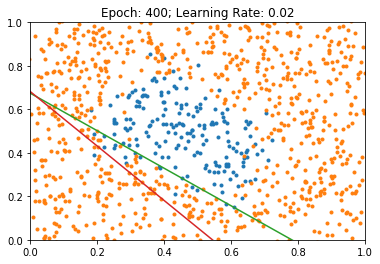

Epoch: 410
G1-Weight: tensor([[-0.6492, -0.7386]]) G1-Bias: tensor([0.5109])
G2-Weight: tensor([[-0.7660, -0.6084]]) G2-Bias: tensor([0.4274])
G3-Weight: tensor([[-0.6008, -0.2680]]) G1-Bias: tensor([-0.6179])
G4-Weight: tensor([[-0.4585, -0.3351]]) G2-Bias: tensor([-0.9820])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6492 * x + 0.5109) / -0.7386)
z2: y = -((-0.766 * x + 0.4274) / -0.6084)
z3: y = -((-0.6008 * x + -0.6179) / -0.268)
z4: y = -((-0.4585 * x + -0.982) / -0.3351)
Beta-Gerade: 0.5251232981681824
Beta-AND: -0.7055505514144897


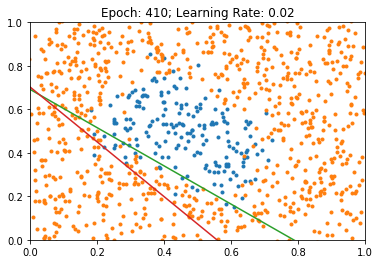

Epoch: 420
G1-Weight: tensor([[-0.6585, -0.7364]]) G1-Bias: tensor([0.5223])
G2-Weight: tensor([[-0.7686, -0.6075]]) G2-Bias: tensor([0.4392])
G3-Weight: tensor([[-0.5949, -0.2748]]) G1-Bias: tensor([-0.6150])
G4-Weight: tensor([[-0.4569, -0.3347]]) G2-Bias: tensor([-0.9806])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6585 * x + 0.5223) / -0.7364)
z2: y = -((-0.7686 * x + 0.4392) / -0.6075)
z3: y = -((-0.5949 * x + -0.615) / -0.2748)
z4: y = -((-0.4569 * x + -0.9806) / -0.3347)
Beta-Gerade: 0.5243006348609924
Beta-AND: -0.7068145275115967


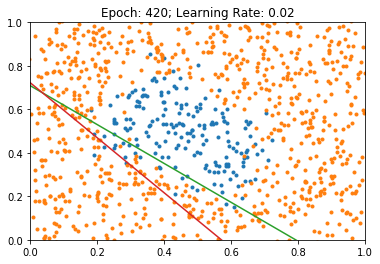

Epoch: 430
G1-Weight: tensor([[-0.6674, -0.7342]]) G1-Bias: tensor([0.5338])
G2-Weight: tensor([[-0.7713, -0.6069]]) G2-Bias: tensor([0.4511])
G3-Weight: tensor([[-0.5891, -0.2813]]) G1-Bias: tensor([-0.6121])
G4-Weight: tensor([[-0.4553, -0.3343]]) G2-Bias: tensor([-0.9792])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6674 * x + 0.5338) / -0.7342)
z2: y = -((-0.7713 * x + 0.4511) / -0.6069)
z3: y = -((-0.5891 * x + -0.6121) / -0.2813)
z4: y = -((-0.4553 * x + -0.9792) / -0.3343)
Beta-Gerade: 0.5235413908958435
Beta-AND: -0.7080894112586975


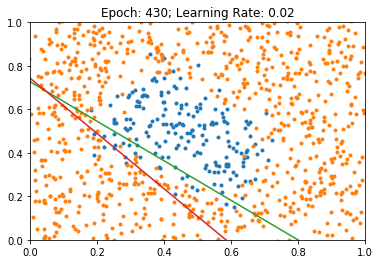

Epoch: 440
G1-Weight: tensor([[-0.6760, -0.7320]]) G1-Bias: tensor([0.5457])
G2-Weight: tensor([[-0.7740, -0.6064]]) G2-Bias: tensor([0.4632])
G3-Weight: tensor([[-0.5833, -0.2872]]) G1-Bias: tensor([-0.6093])
G4-Weight: tensor([[-0.4535, -0.3337]]) G2-Bias: tensor([-0.9778])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.676 * x + 0.5457) / -0.732)
z2: y = -((-0.774 * x + 0.4632) / -0.6064)
z3: y = -((-0.5833 * x + -0.6093) / -0.2872)
z4: y = -((-0.4535 * x + -0.9778) / -0.3337)
Beta-Gerade: 0.5228477716445923
Beta-AND: -0.709374725818634


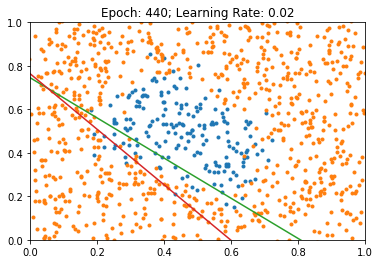

Epoch: 450
G1-Weight: tensor([[-0.6842, -0.7300]]) G1-Bias: tensor([0.5578])
G2-Weight: tensor([[-0.7767, -0.6061]]) G2-Bias: tensor([0.4756])
G3-Weight: tensor([[-0.5776, -0.2928]]) G1-Bias: tensor([-0.6065])
G4-Weight: tensor([[-0.4516, -0.3332]]) G2-Bias: tensor([-0.9764])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6842 * x + 0.5578) / -0.73)
z2: y = -((-0.7767 * x + 0.4756) / -0.6061)
z3: y = -((-0.5776 * x + -0.6065) / -0.2928)
z4: y = -((-0.4516 * x + -0.9764) / -0.3332)
Beta-Gerade: 0.5222228169441223
Beta-AND: -0.7106700539588928


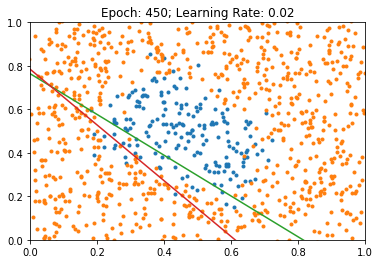

Epoch: 460
G1-Weight: tensor([[-0.6922, -0.7279]]) G1-Bias: tensor([0.5701])
G2-Weight: tensor([[-0.7794, -0.6059]]) G2-Bias: tensor([0.4881])
G3-Weight: tensor([[-0.5719, -0.2980]]) G1-Bias: tensor([-0.6036])
G4-Weight: tensor([[-0.4496, -0.3325]]) G2-Bias: tensor([-0.9751])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6922 * x + 0.5701) / -0.7279)
z2: y = -((-0.7794 * x + 0.4881) / -0.6059)
z3: y = -((-0.5719 * x + -0.6036) / -0.298)
z4: y = -((-0.4496 * x + -0.9751) / -0.3325)
Beta-Gerade: 0.5216691493988037
Beta-AND: -0.7119751572608948


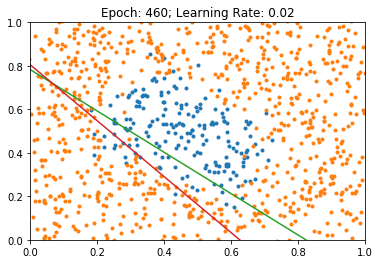

Epoch: 470
G1-Weight: tensor([[-0.6999, -0.7260]]) G1-Bias: tensor([0.5828])
G2-Weight: tensor([[-0.7821, -0.6058]]) G2-Bias: tensor([0.5008])
G3-Weight: tensor([[-0.5664, -0.3027]]) G1-Bias: tensor([-0.6008])
G4-Weight: tensor([[-0.4475, -0.3318]]) G2-Bias: tensor([-0.9738])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.6999 * x + 0.5828) / -0.726)
z2: y = -((-0.7821 * x + 0.5008) / -0.6058)
z3: y = -((-0.5664 * x + -0.6008) / -0.3027)
z4: y = -((-0.4475 * x + -0.9738) / -0.3318)
Beta-Gerade: 0.5211899280548096
Beta-AND: -0.7132896184921265


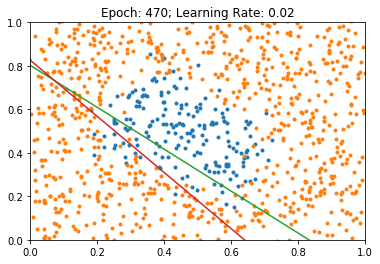

Epoch: 480
G1-Weight: tensor([[-0.7073, -0.7241]]) G1-Bias: tensor([0.5957])
G2-Weight: tensor([[-0.7849, -0.6059]]) G2-Bias: tensor([0.5138])
G3-Weight: tensor([[-0.5608, -0.3071]]) G1-Bias: tensor([-0.5980])
G4-Weight: tensor([[-0.4452, -0.3310]]) G2-Bias: tensor([-0.9726])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7073 * x + 0.5957) / -0.7241)
z2: y = -((-0.7849 * x + 0.5138) / -0.6059)
z3: y = -((-0.5608 * x + -0.598) / -0.3071)
z4: y = -((-0.4452 * x + -0.9726) / -0.331)
Beta-Gerade: 0.520788848400116
Beta-AND: -0.7146133780479431


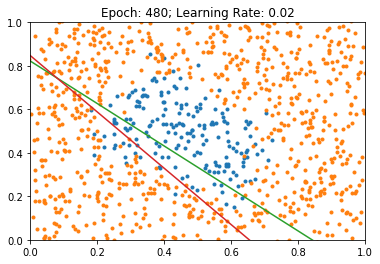

Epoch: 490
G1-Weight: tensor([[-0.7144, -0.7223]]) G1-Bias: tensor([0.6089])
G2-Weight: tensor([[-0.7875, -0.6060]]) G2-Bias: tensor([0.5270])
G3-Weight: tensor([[-0.5553, -0.3111]]) G1-Bias: tensor([-0.5952])
G4-Weight: tensor([[-0.4428, -0.3301]]) G2-Bias: tensor([-0.9713])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7144 * x + 0.6089) / -0.7223)
z2: y = -((-0.7875 * x + 0.527) / -0.606)
z3: y = -((-0.5553 * x + -0.5952) / -0.3111)
z4: y = -((-0.4428 * x + -0.9713) / -0.3301)
Beta-Gerade: 0.5204695463180542
Beta-AND: -0.7159460186958313


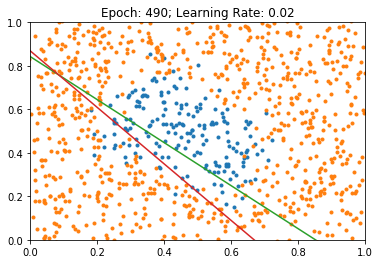

Epoch: 500
G1-Weight: tensor([[-0.7214, -0.7206]]) G1-Bias: tensor([0.6225])
G2-Weight: tensor([[-0.7902, -0.6062]]) G2-Bias: tensor([0.5404])
G3-Weight: tensor([[-0.5499, -0.3148]]) G1-Bias: tensor([-0.5925])
G4-Weight: tensor([[-0.4403, -0.3291]]) G2-Bias: tensor([-0.9701])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7214 * x + 0.6225) / -0.7206)
z2: y = -((-0.7902 * x + 0.5404) / -0.6062)
z3: y = -((-0.5499 * x + -0.5925) / -0.3148)
z4: y = -((-0.4403 * x + -0.9701) / -0.3291)
Beta-Gerade: 0.5202363729476929
Beta-AND: -0.7172874212265015


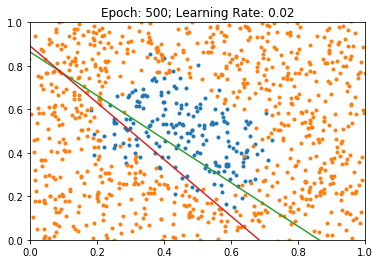

Epoch: 510
G1-Weight: tensor([[-0.7280, -0.7189]]) G1-Bias: tensor([0.6363])
G2-Weight: tensor([[-0.7928, -0.6065]]) G2-Bias: tensor([0.5540])
G3-Weight: tensor([[-0.5444, -0.3181]]) G1-Bias: tensor([-0.5897])
G4-Weight: tensor([[-0.4376, -0.3280]]) G2-Bias: tensor([-0.9690])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.728 * x + 0.6363) / -0.7189)
z2: y = -((-0.7928 * x + 0.554) / -0.6065)
z3: y = -((-0.5444 * x + -0.5897) / -0.3181)
z4: y = -((-0.4376 * x + -0.969) / -0.328)
Beta-Gerade: 0.5200936794281006
Beta-AND: -0.7186374664306641


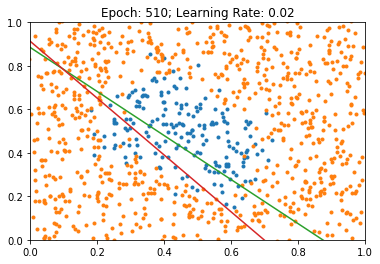

Epoch: 520
G1-Weight: tensor([[-0.7345, -0.7174]]) G1-Bias: tensor([0.6504])
G2-Weight: tensor([[-0.7954, -0.6069]]) G2-Bias: tensor([0.5680])
G3-Weight: tensor([[-0.5390, -0.3210]]) G1-Bias: tensor([-0.5870])
G4-Weight: tensor([[-0.4348, -0.3268]]) G2-Bias: tensor([-0.9679])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7345 * x + 0.6504) / -0.7174)
z2: y = -((-0.7954 * x + 0.568) / -0.6069)
z3: y = -((-0.539 * x + -0.587) / -0.321)
z4: y = -((-0.4348 * x + -0.9679) / -0.3268)
Beta-Gerade: 0.5200464725494385
Beta-AND: -0.7199960350990295


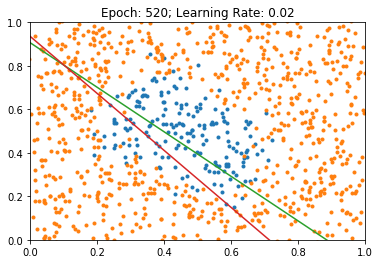

Epoch: 530
G1-Weight: tensor([[-0.7408, -0.7159]]) G1-Bias: tensor([0.6648])
G2-Weight: tensor([[-0.7980, -0.6074]]) G2-Bias: tensor([0.5822])
G3-Weight: tensor([[-0.5335, -0.3236]]) G1-Bias: tensor([-0.5844])
G4-Weight: tensor([[-0.4319, -0.3256]]) G2-Bias: tensor([-0.9668])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7408 * x + 0.6648) / -0.7159)
z2: y = -((-0.798 * x + 0.5822) / -0.6074)
z3: y = -((-0.5335 * x + -0.5844) / -0.3236)
z4: y = -((-0.4319 * x + -0.9668) / -0.3256)
Beta-Gerade: 0.5200999975204468
Beta-AND: -0.7213630080223083


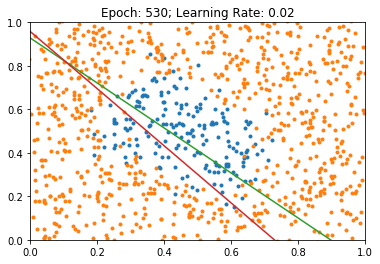

Epoch: 540
G1-Weight: tensor([[-0.7468, -0.7145]]) G1-Bias: tensor([0.6796])
G2-Weight: tensor([[-0.8005, -0.6078]]) G2-Bias: tensor([0.5967])
G3-Weight: tensor([[-0.5281, -0.3259]]) G1-Bias: tensor([-0.5817])
G4-Weight: tensor([[-0.4288, -0.3242]]) G2-Bias: tensor([-0.9658])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7468 * x + 0.6796) / -0.7145)
z2: y = -((-0.8005 * x + 0.5967) / -0.6078)
z3: y = -((-0.5281 * x + -0.5817) / -0.3259)
z4: y = -((-0.4288 * x + -0.9658) / -0.3242)
Beta-Gerade: 0.5202600955963135
Beta-AND: -0.7227383852005005


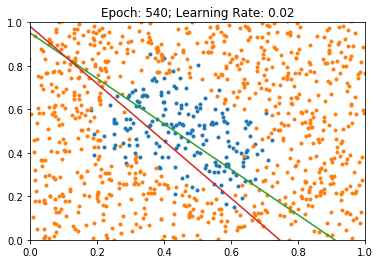

Epoch: 550
G1-Weight: tensor([[-0.7527, -0.7131]]) G1-Bias: tensor([0.6947])
G2-Weight: tensor([[-0.8030, -0.6084]]) G2-Bias: tensor([0.6114])
G3-Weight: tensor([[-0.5226, -0.3278]]) G1-Bias: tensor([-0.5791])
G4-Weight: tensor([[-0.4256, -0.3226]]) G2-Bias: tensor([-0.9648])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7527 * x + 0.6947) / -0.7131)
z2: y = -((-0.803 * x + 0.6114) / -0.6084)
z3: y = -((-0.5226 * x + -0.5791) / -0.3278)
z4: y = -((-0.4256 * x + -0.9648) / -0.3226)
Beta-Gerade: 0.5205331444740295
Beta-AND: -0.724122166633606


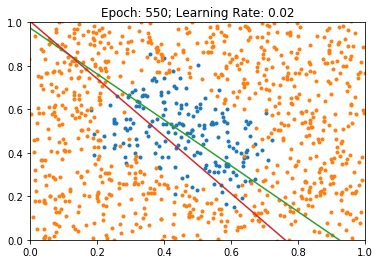

Epoch: 560
G1-Weight: tensor([[-0.7583, -0.7119]]) G1-Bias: tensor([0.7101])
G2-Weight: tensor([[-0.8054, -0.6089]]) G2-Bias: tensor([0.6265])
G3-Weight: tensor([[-0.5170, -0.3294]]) G1-Bias: tensor([-0.5766])
G4-Weight: tensor([[-0.4222, -0.3210]]) G2-Bias: tensor([-0.9640])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7583 * x + 0.7101) / -0.7119)
z2: y = -((-0.8054 * x + 0.6265) / -0.6089)
z3: y = -((-0.517 * x + -0.5766) / -0.3294)
z4: y = -((-0.4222 * x + -0.964) / -0.321)
Beta-Gerade: 0.5209258794784546
Beta-AND: -0.7255143523216248


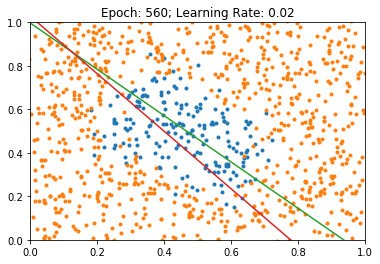

Epoch: 570
G1-Weight: tensor([[-0.7638, -0.7107]]) G1-Bias: tensor([0.7259])
G2-Weight: tensor([[-0.8077, -0.6095]]) G2-Bias: tensor([0.6419])
G3-Weight: tensor([[-0.5114, -0.3306]]) G1-Bias: tensor([-0.5741])
G4-Weight: tensor([[-0.4186, -0.3192]]) G2-Bias: tensor([-0.9631])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7638 * x + 0.7259) / -0.7107)
z2: y = -((-0.8077 * x + 0.6419) / -0.6095)
z3: y = -((-0.5114 * x + -0.5741) / -0.3306)
z4: y = -((-0.4186 * x + -0.9631) / -0.3192)
Beta-Gerade: 0.5214459300041199
Beta-AND: -0.7269149422645569


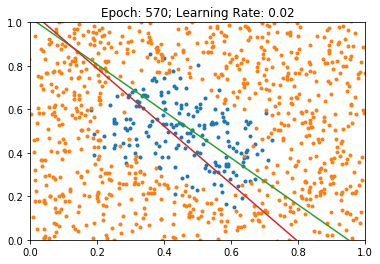

Epoch: 580
G1-Weight: tensor([[-0.7691, -0.7095]]) G1-Bias: tensor([0.7421])
G2-Weight: tensor([[-0.8100, -0.6101]]) G2-Bias: tensor([0.6576])
G3-Weight: tensor([[-0.5057, -0.3315]]) G1-Bias: tensor([-0.5716])
G4-Weight: tensor([[-0.4148, -0.3173]]) G2-Bias: tensor([-0.9624])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7691 * x + 0.7421) / -0.7095)
z2: y = -((-0.81 * x + 0.6576) / -0.6101)
z3: y = -((-0.5057 * x + -0.5716) / -0.3315)
z4: y = -((-0.4148 * x + -0.9624) / -0.3173)
Beta-Gerade: 0.5221013426780701
Beta-AND: -0.7283241152763367


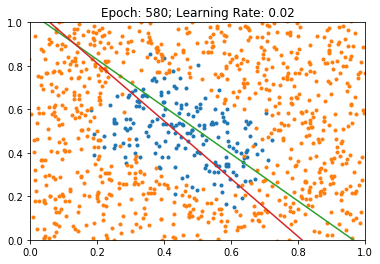

Epoch: 590
G1-Weight: tensor([[-0.7743, -0.7085]]) G1-Bias: tensor([0.7586])
G2-Weight: tensor([[-0.8122, -0.6106]]) G2-Bias: tensor([0.6737])
G3-Weight: tensor([[-0.5000, -0.3321]]) G1-Bias: tensor([-0.5692])
G4-Weight: tensor([[-0.4108, -0.3152]]) G2-Bias: tensor([-0.9617])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7743 * x + 0.7586) / -0.7085)
z2: y = -((-0.8122 * x + 0.6737) / -0.6106)
z3: y = -((-0.5 * x + -0.5692) / -0.3321)
z4: y = -((-0.4108 * x + -0.9617) / -0.3152)
Beta-Gerade: 0.5229012370109558
Beta-AND: -0.7297419905662537


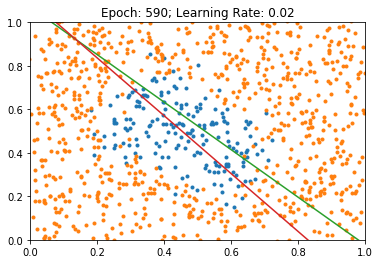

Epoch: 600
G1-Weight: tensor([[-0.7792, -0.7075]]) G1-Bias: tensor([0.7756])
G2-Weight: tensor([[-0.8144, -0.6112]]) G2-Bias: tensor([0.6901])
G3-Weight: tensor([[-0.4941, -0.3324]]) G1-Bias: tensor([-0.5669])
G4-Weight: tensor([[-0.4067, -0.3130]]) G2-Bias: tensor([-0.9611])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7792 * x + 0.7756) / -0.7075)
z2: y = -((-0.8144 * x + 0.6901) / -0.6112)
z3: y = -((-0.4941 * x + -0.5669) / -0.3324)
z4: y = -((-0.4067 * x + -0.9611) / -0.313)
Beta-Gerade: 0.5238551497459412
Beta-AND: -0.731168806552887


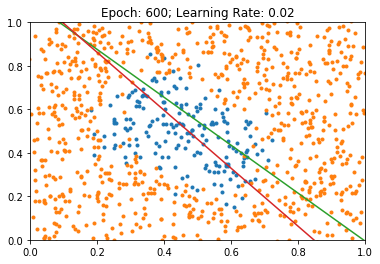

Epoch: 610
G1-Weight: tensor([[-0.7841, -0.7065]]) G1-Bias: tensor([0.7929])
G2-Weight: tensor([[-0.8164, -0.6118]]) G2-Bias: tensor([0.7069])
G3-Weight: tensor([[-0.4880, -0.3323]]) G1-Bias: tensor([-0.5647])
G4-Weight: tensor([[-0.4023, -0.3106]]) G2-Bias: tensor([-0.9607])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7841 * x + 0.7929) / -0.7065)
z2: y = -((-0.8164 * x + 0.7069) / -0.6118)
z3: y = -((-0.488 * x + -0.5647) / -0.3323)
z4: y = -((-0.4023 * x + -0.9607) / -0.3106)
Beta-Gerade: 0.5249738097190857
Beta-AND: -0.7326047420501709


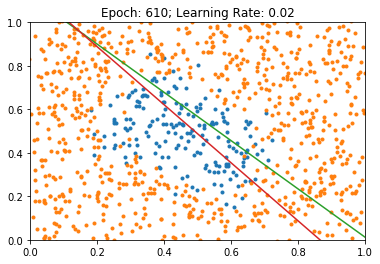

Epoch: 620
G1-Weight: tensor([[-0.7887, -0.7056]]) G1-Bias: tensor([0.8107])
G2-Weight: tensor([[-0.8184, -0.6124]]) G2-Bias: tensor([0.7240])
G3-Weight: tensor([[-0.4819, -0.3319]]) G1-Bias: tensor([-0.5625])
G4-Weight: tensor([[-0.3977, -0.3080]]) G2-Bias: tensor([-0.9603])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7887 * x + 0.8107) / -0.7056)
z2: y = -((-0.8184 * x + 0.724) / -0.6124)
z3: y = -((-0.4819 * x + -0.5625) / -0.3319)
z4: y = -((-0.3977 * x + -0.9603) / -0.308)
Beta-Gerade: 0.5262693762779236
Beta-AND: -0.7340501546859741


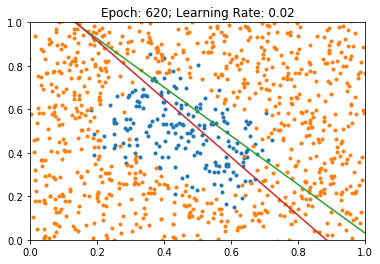

Epoch: 630
G1-Weight: tensor([[-0.7932, -0.7048]]) G1-Bias: tensor([0.8290])
G2-Weight: tensor([[-0.8203, -0.6129]]) G2-Bias: tensor([0.7416])
G3-Weight: tensor([[-0.4755, -0.3312]]) G1-Bias: tensor([-0.5605])
G4-Weight: tensor([[-0.3928, -0.3052]]) G2-Bias: tensor([-0.9600])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7932 * x + 0.829) / -0.7048)
z2: y = -((-0.8203 * x + 0.7416) / -0.6129)
z3: y = -((-0.4755 * x + -0.5605) / -0.3312)
z4: y = -((-0.3928 * x + -0.96) / -0.3052)
Beta-Gerade: 0.527754545211792
Beta-AND: -0.7355052828788757


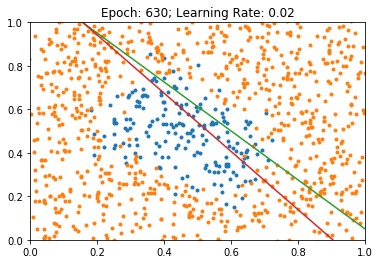

Epoch: 640
G1-Weight: tensor([[-0.7976, -0.7040]]) G1-Bias: tensor([0.8478])
G2-Weight: tensor([[-0.8221, -0.6134]]) G2-Bias: tensor([0.7596])
G3-Weight: tensor([[-0.4690, -0.3301]]) G1-Bias: tensor([-0.5585])
G4-Weight: tensor([[-0.3877, -0.3022]]) G2-Bias: tensor([-0.9599])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.7976 * x + 0.8478) / -0.704)
z2: y = -((-0.8221 * x + 0.7596) / -0.6134)
z3: y = -((-0.469 * x + -0.5585) / -0.3301)
z4: y = -((-0.3877 * x + -0.9599) / -0.3022)
Beta-Gerade: 0.529443621635437
Beta-AND: -0.7369707226753235


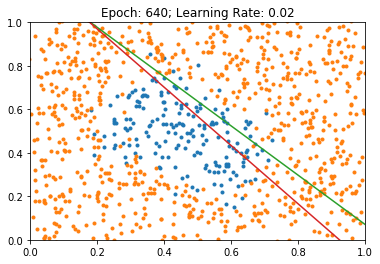

Epoch: 650
G1-Weight: tensor([[-0.8018, -0.7032]]) G1-Bias: tensor([0.8670])
G2-Weight: tensor([[-0.8238, -0.6139]]) G2-Bias: tensor([0.7781])
G3-Weight: tensor([[-0.4622, -0.3287]]) G1-Bias: tensor([-0.5567])
G4-Weight: tensor([[-0.3823, -0.2990]]) G2-Bias: tensor([-0.9599])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8018 * x + 0.867) / -0.7032)
z2: y = -((-0.8238 * x + 0.7781) / -0.6139)
z3: y = -((-0.4622 * x + -0.5567) / -0.3287)
z4: y = -((-0.3823 * x + -0.9599) / -0.299)
Beta-Gerade: 0.5313524603843689
Beta-AND: -0.7384468913078308


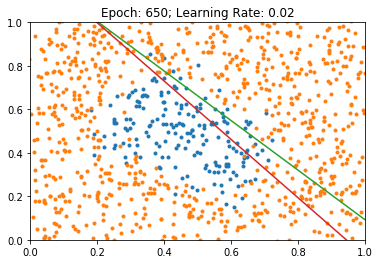

Epoch: 660
G1-Weight: tensor([[-0.8059, -0.7025]]) G1-Bias: tensor([0.8868])
G2-Weight: tensor([[-0.8255, -0.6143]]) G2-Bias: tensor([0.7970])
G3-Weight: tensor([[-0.4553, -0.3269]]) G1-Bias: tensor([-0.5551])
G4-Weight: tensor([[-0.3767, -0.2956]]) G2-Bias: tensor([-0.9601])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8059 * x + 0.8868) / -0.7025)
z2: y = -((-0.8255 * x + 0.797) / -0.6143)
z3: y = -((-0.4553 * x + -0.5551) / -0.3269)
z4: y = -((-0.3767 * x + -0.9601) / -0.2956)
Beta-Gerade: 0.5334986448287964
Beta-AND: -0.7399346232414246


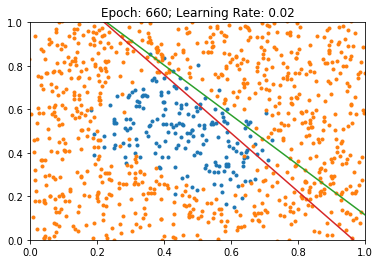

Epoch: 670
G1-Weight: tensor([[-0.8099, -0.7018]]) G1-Bias: tensor([0.9072])
G2-Weight: tensor([[-0.8270, -0.6147]]) G2-Bias: tensor([0.8165])
G3-Weight: tensor([[-0.4480, -0.3247]]) G1-Bias: tensor([-0.5535])
G4-Weight: tensor([[-0.3707, -0.2920]]) G2-Bias: tensor([-0.9604])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8099 * x + 0.9072) / -0.7018)
z2: y = -((-0.827 * x + 0.8165) / -0.6147)
z3: y = -((-0.448 * x + -0.5535) / -0.3247)
z4: y = -((-0.3707 * x + -0.9604) / -0.292)
Beta-Gerade: 0.5359016060829163
Beta-AND: -0.7414343953132629


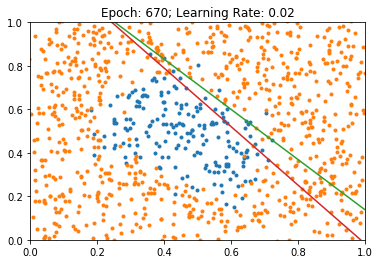

Epoch: 680
G1-Weight: tensor([[-0.8137, -0.7011]]) G1-Bias: tensor([0.9281])
G2-Weight: tensor([[-0.8284, -0.6150]]) G2-Bias: tensor([0.8364])
G3-Weight: tensor([[-0.4405, -0.3222]]) G1-Bias: tensor([-0.5522])
G4-Weight: tensor([[-0.3644, -0.2880]]) G2-Bias: tensor([-0.9609])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8137 * x + 0.9281) / -0.7011)
z2: y = -((-0.8284 * x + 0.8364) / -0.615)
z3: y = -((-0.4405 * x + -0.5522) / -0.3222)
z4: y = -((-0.3644 * x + -0.9609) / -0.288)
Beta-Gerade: 0.5385832786560059
Beta-AND: -0.7429471611976624


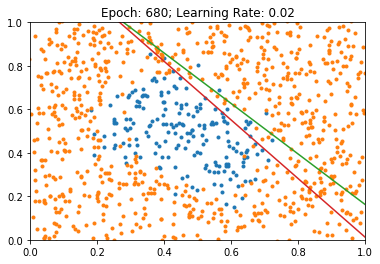

Epoch: 690
G1-Weight: tensor([[-0.8174, -0.7005]]) G1-Bias: tensor([0.9497])
G2-Weight: tensor([[-0.8297, -0.6152]]) G2-Bias: tensor([0.8570])
G3-Weight: tensor([[-0.4326, -0.3193]]) G1-Bias: tensor([-0.5510])
G4-Weight: tensor([[-0.3577, -0.2839]]) G2-Bias: tensor([-0.9616])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8174 * x + 0.9497) / -0.7005)
z2: y = -((-0.8297 * x + 0.857) / -0.6152)
z3: y = -((-0.4326 * x + -0.551) / -0.3193)
z4: y = -((-0.3577 * x + -0.9616) / -0.2839)
Beta-Gerade: 0.5415679216384888
Beta-AND: -0.7444738745689392


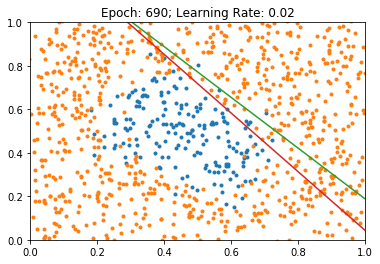

Epoch: 700
G1-Weight: tensor([[-0.8210, -0.6999]]) G1-Bias: tensor([0.9720])
G2-Weight: tensor([[-0.8310, -0.6154]]) G2-Bias: tensor([0.8781])
G3-Weight: tensor([[-0.4244, -0.3159]]) G1-Bias: tensor([-0.5501])
G4-Weight: tensor([[-0.3507, -0.2794]]) G2-Bias: tensor([-0.9625])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.821 * x + 0.972) / -0.6999)
z2: y = -((-0.831 * x + 0.8781) / -0.6154)
z3: y = -((-0.4244 * x + -0.5501) / -0.3159)
z4: y = -((-0.3507 * x + -0.9625) / -0.2794)
Beta-Gerade: 0.5448829531669617
Beta-AND: -0.746015727519989


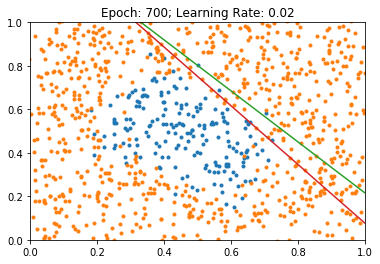

Epoch: 710
G1-Weight: tensor([[-0.8245, -0.6993]]) G1-Bias: tensor([0.9950])
G2-Weight: tensor([[-0.8321, -0.6155]]) G2-Bias: tensor([0.8999])
G3-Weight: tensor([[-0.4158, -0.3122]]) G1-Bias: tensor([-0.5494])
G4-Weight: tensor([[-0.3433, -0.2746]]) G2-Bias: tensor([-0.9637])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8245 * x + 0.995) / -0.6993)
z2: y = -((-0.8321 * x + 0.8999) / -0.6155)
z3: y = -((-0.4158 * x + -0.5494) / -0.3122)
z4: y = -((-0.3433 * x + -0.9637) / -0.2746)
Beta-Gerade: 0.5485590696334839
Beta-AND: -0.7475742101669312


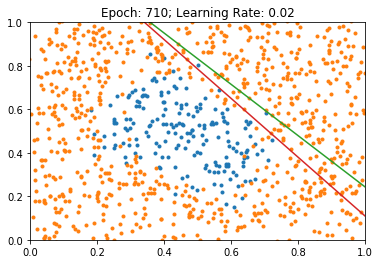

Epoch: 720
G1-Weight: tensor([[-0.8278, -0.6988]]) G1-Bias: tensor([1.0188])
G2-Weight: tensor([[-0.8331, -0.6155]]) G2-Bias: tensor([0.9223])
G3-Weight: tensor([[-0.4068, -0.3080]]) G1-Bias: tensor([-0.5489])
G4-Weight: tensor([[-0.3355, -0.2695]]) G2-Bias: tensor([-0.9652])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8278 * x + 1.0188) / -0.6988)
z2: y = -((-0.8331 * x + 0.9223) / -0.6155)
z3: y = -((-0.4068 * x + -0.5489) / -0.308)
z4: y = -((-0.3355 * x + -0.9652) / -0.2695)
Beta-Gerade: 0.5526307821273804
Beta-AND: -0.7491506934165955


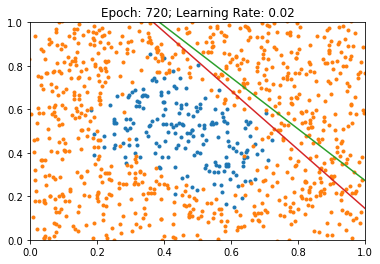

Epoch: 730
G1-Weight: tensor([[-0.8311, -0.6983]]) G1-Bias: tensor([1.0435])
G2-Weight: tensor([[-0.8340, -0.6155]]) G2-Bias: tensor([0.9455])
G3-Weight: tensor([[-0.3973, -0.3033]]) G1-Bias: tensor([-0.5488])
G4-Weight: tensor([[-0.3273, -0.2640]]) G2-Bias: tensor([-0.9669])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8311 * x + 1.0435) / -0.6983)
z2: y = -((-0.834 * x + 0.9455) / -0.6155)
z3: y = -((-0.3973 * x + -0.5488) / -0.3033)
z4: y = -((-0.3273 * x + -0.9669) / -0.264)
Beta-Gerade: 0.557137668132782
Beta-AND: -0.7507472634315491


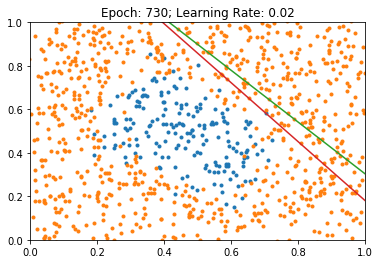

Epoch: 740
G1-Weight: tensor([[-0.8344, -0.6978]]) G1-Bias: tensor([1.0690])
G2-Weight: tensor([[-0.8348, -0.6153]]) G2-Bias: tensor([0.9695])
G3-Weight: tensor([[-0.3873, -0.2982]]) G1-Bias: tensor([-0.5490])
G4-Weight: tensor([[-0.3185, -0.2582]]) G2-Bias: tensor([-0.9690])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8344 * x + 1.069) / -0.6978)
z2: y = -((-0.8348 * x + 0.9695) / -0.6153)
z3: y = -((-0.3873 * x + -0.549) / -0.2982)
z4: y = -((-0.3185 * x + -0.969) / -0.2582)
Beta-Gerade: 0.5621244311332703
Beta-AND: -0.7523658871650696


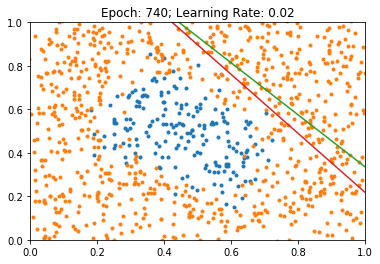

Epoch: 750
G1-Weight: tensor([[-0.8376, -0.6974]]) G1-Bias: tensor([1.0956])
G2-Weight: tensor([[-0.8356, -0.6151]]) G2-Bias: tensor([0.9943])
G3-Weight: tensor([[-0.3767, -0.2925]]) G1-Bias: tensor([-0.5496])
G4-Weight: tensor([[-0.3093, -0.2520]]) G2-Bias: tensor([-0.9715])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8376 * x + 1.0956) / -0.6974)
z2: y = -((-0.8356 * x + 0.9943) / -0.6151)
z3: y = -((-0.3767 * x + -0.5496) / -0.2925)
z4: y = -((-0.3093 * x + -0.9715) / -0.252)
Beta-Gerade: 0.5676423907279968
Beta-AND: -0.7540093064308167


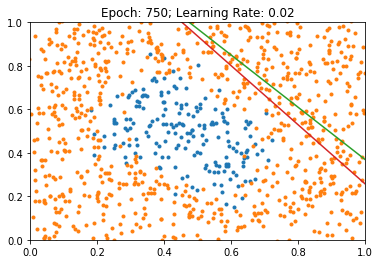

Epoch: 760
G1-Weight: tensor([[-0.8407, -0.6970]]) G1-Bias: tensor([1.1233])
G2-Weight: tensor([[-0.8362, -0.6148]]) G2-Bias: tensor([1.0201])
G3-Weight: tensor([[-0.3656, -0.2863]]) G1-Bias: tensor([-0.5506])
G4-Weight: tensor([[-0.2995, -0.2454]]) G2-Bias: tensor([-0.9744])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8407 * x + 1.1233) / -0.697)
z2: y = -((-0.8362 * x + 1.0201) / -0.6148)
z3: y = -((-0.3656 * x + -0.5506) / -0.2863)
z4: y = -((-0.2995 * x + -0.9744) / -0.2454)
Beta-Gerade: 0.5737499594688416
Beta-AND: -0.7556804418563843


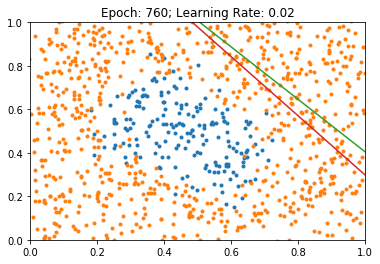

Epoch: 770
G1-Weight: tensor([[-0.8439, -0.6968]]) G1-Bias: tensor([1.1521])
G2-Weight: tensor([[-0.8368, -0.6143]]) G2-Bias: tensor([1.0468])
G3-Weight: tensor([[-0.3538, -0.2796]]) G1-Bias: tensor([-0.5521])
G4-Weight: tensor([[-0.2891, -0.2384]]) G2-Bias: tensor([-0.9778])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8439 * x + 1.1521) / -0.6968)
z2: y = -((-0.8368 * x + 1.0468) / -0.6143)
z3: y = -((-0.3538 * x + -0.5521) / -0.2796)
z4: y = -((-0.2891 * x + -0.9778) / -0.2384)
Beta-Gerade: 0.5805153250694275
Beta-AND: -0.757382869720459


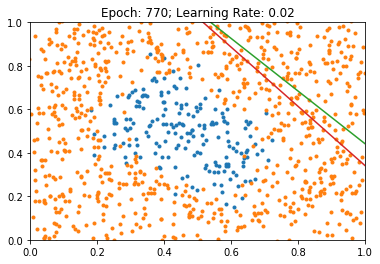

Epoch: 780
G1-Weight: tensor([[-0.8471, -0.6966]]) G1-Bias: tensor([1.1823])
G2-Weight: tensor([[-0.8373, -0.6139]]) G2-Bias: tensor([1.0747])
G3-Weight: tensor([[-0.3413, -0.2722]]) G1-Bias: tensor([-0.5542])
G4-Weight: tensor([[-0.2781, -0.2308]]) G2-Bias: tensor([-0.9817])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8471 * x + 1.1823) / -0.6966)
z2: y = -((-0.8373 * x + 1.0747) / -0.6139)
z3: y = -((-0.3413 * x + -0.5542) / -0.2722)
z4: y = -((-0.2781 * x + -0.9817) / -0.2308)
Beta-Gerade: 0.5880166292190552
Beta-AND: -0.7591208815574646


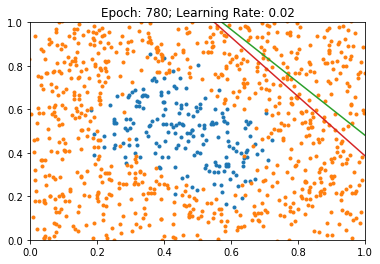

Epoch: 790
G1-Weight: tensor([[-0.8504, -0.6966]]) G1-Bias: tensor([1.2139])
G2-Weight: tensor([[-0.8378, -0.6133]]) G2-Bias: tensor([1.1037])
G3-Weight: tensor([[-0.3280, -0.2642]]) G1-Bias: tensor([-0.5569])
G4-Weight: tensor([[-0.2665, -0.2228]]) G2-Bias: tensor([-0.9862])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8504 * x + 1.2139) / -0.6966)
z2: y = -((-0.8378 * x + 1.1037) / -0.6133)
z3: y = -((-0.328 * x + -0.5569) / -0.2642)
z4: y = -((-0.2665 * x + -0.9862) / -0.2228)
Beta-Gerade: 0.5963454842567444
Beta-AND: -0.7608994245529175


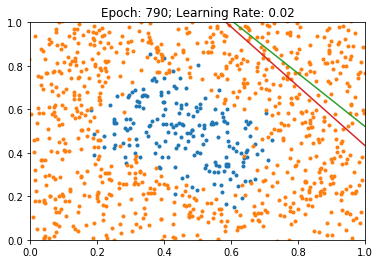

Epoch: 800
G1-Weight: tensor([[-0.8539, -0.6968]]) G1-Bias: tensor([1.2472])
G2-Weight: tensor([[-0.8384, -0.6127]]) G2-Bias: tensor([1.1341])
G3-Weight: tensor([[-0.3139, -0.2554]]) G1-Bias: tensor([-0.5604])
G4-Weight: tensor([[-0.2541, -0.2142]]) G2-Bias: tensor([-0.9914])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8539 * x + 1.2472) / -0.6968)
z2: y = -((-0.8384 * x + 1.1341) / -0.6127)
z3: y = -((-0.3139 * x + -0.5604) / -0.2554)
z4: y = -((-0.2541 * x + -0.9914) / -0.2142)
Beta-Gerade: 0.605609118938446
Beta-AND: -0.7627245187759399


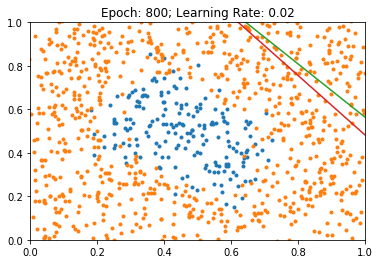

Epoch: 810
G1-Weight: tensor([[-0.8576, -0.6973]]) G1-Bias: tensor([1.2822])
G2-Weight: tensor([[-0.8390, -0.6120]]) G2-Bias: tensor([1.1660])
G3-Weight: tensor([[-0.2988, -0.2460]]) G1-Bias: tensor([-0.5647])
G4-Weight: tensor([[-0.2409, -0.2051]]) G2-Bias: tensor([-0.9973])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8576 * x + 1.2822) / -0.6973)
z2: y = -((-0.839 * x + 1.166) / -0.612)
z3: y = -((-0.2988 * x + -0.5647) / -0.246)
z4: y = -((-0.2409 * x + -0.9973) / -0.2051)
Beta-Gerade: 0.6159342527389526
Beta-AND: -0.7646034359931946


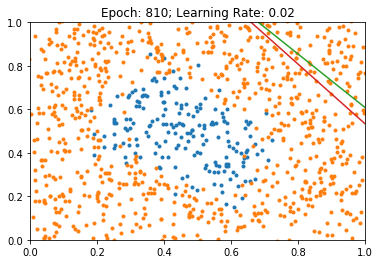

Epoch: 820
G1-Weight: tensor([[-0.8617, -0.6981]]) G1-Bias: tensor([1.3194])
G2-Weight: tensor([[-0.8397, -0.6114]]) G2-Bias: tensor([1.1995])
G3-Weight: tensor([[-0.2826, -0.2357]]) G1-Bias: tensor([-0.5701])
G4-Weight: tensor([[-0.2269, -0.1953]]) G2-Bias: tensor([-1.0042])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8617 * x + 1.3194) / -0.6981)
z2: y = -((-0.8397 * x + 1.1995) / -0.6114)
z3: y = -((-0.2826 * x + -0.5701) / -0.2357)
z4: y = -((-0.2269 * x + -1.0042) / -0.1953)
Beta-Gerade: 0.6274709701538086
Beta-AND: -0.7665448784828186


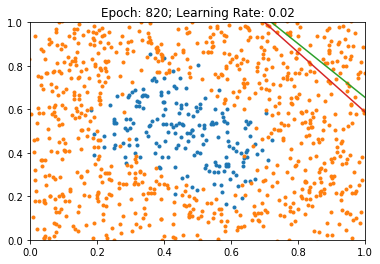

Epoch: 830
G1-Weight: tensor([[-0.8663, -0.6993]]) G1-Bias: tensor([1.3589])
G2-Weight: tensor([[-0.8406, -0.6108]]) G2-Bias: tensor([1.2349])
G3-Weight: tensor([[-0.2653, -0.2245]]) G1-Bias: tensor([-0.5766])
G4-Weight: tensor([[-0.2119, -0.1848]]) G2-Bias: tensor([-1.0121])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8663 * x + 1.3589) / -0.6993)
z2: y = -((-0.8406 * x + 1.2349) / -0.6108)
z3: y = -((-0.2653 * x + -0.5766) / -0.2245)
z4: y = -((-0.2119 * x + -1.0121) / -0.1848)
Beta-Gerade: 0.6403995156288147
Beta-AND: -0.7685596346855164


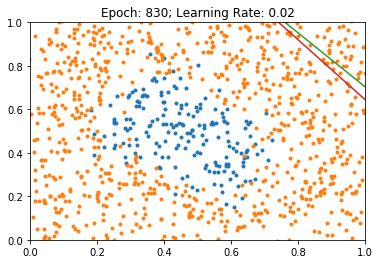

Epoch: 840
G1-Weight: tensor([[-0.8716, -0.7011]]) G1-Bias: tensor([1.4011])
G2-Weight: tensor([[-0.8419, -0.6103]]) G2-Bias: tensor([1.2724])
G3-Weight: tensor([[-0.2468, -0.2124]]) G1-Bias: tensor([-0.5845])
G4-Weight: tensor([[-0.1960, -0.1737]]) G2-Bias: tensor([-1.0212])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8716 * x + 1.4011) / -0.7011)
z2: y = -((-0.8419 * x + 1.2724) / -0.6103)
z3: y = -((-0.2468 * x + -0.5845) / -0.2124)
z4: y = -((-0.196 * x + -1.0212) / -0.1737)
Beta-Gerade: 0.6549378633499146
Beta-AND: -0.7706607580184937


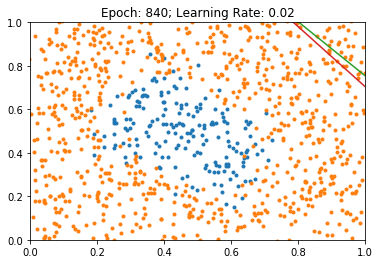

Epoch: 850
G1-Weight: tensor([[-0.8779, -0.7037]]) G1-Bias: tensor([1.4465])
G2-Weight: tensor([[-0.8437, -0.6099]]) G2-Bias: tensor([1.3124])
G3-Weight: tensor([[-0.2268, -0.1992]]) G1-Bias: tensor([-0.5940])
G4-Weight: tensor([[-0.1790, -0.1618]]) G2-Bias: tensor([-1.0317])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8779 * x + 1.4465) / -0.7037)
z2: y = -((-0.8437 * x + 1.3124) / -0.6099)
z3: y = -((-0.2268 * x + -0.594) / -0.1992)
z4: y = -((-0.179 * x + -1.0317) / -0.1618)
Beta-Gerade: 0.6713521480560303
Beta-AND: -0.7728643417358398


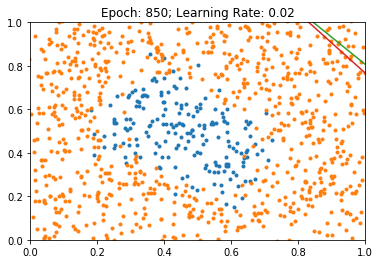

Epoch: 860
G1-Weight: tensor([[-0.8855, -0.7074]]) G1-Bias: tensor([1.4957])
G2-Weight: tensor([[-0.8462, -0.6099]]) G2-Bias: tensor([1.3551])
G3-Weight: tensor([[-0.2053, -0.1849]]) G1-Bias: tensor([-0.6054])
G4-Weight: tensor([[-0.1608, -0.1490]]) G2-Bias: tensor([-1.0438])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8855 * x + 1.4957) / -0.7074)
z2: y = -((-0.8462 * x + 1.3551) / -0.6099)
z3: y = -((-0.2053 * x + -0.6054) / -0.1849)
z4: y = -((-0.1608 * x + -1.0438) / -0.149)
Beta-Gerade: 0.6899712085723877
Beta-AND: -0.7751907706260681


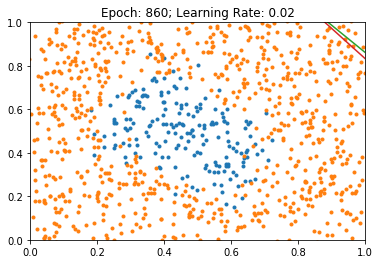

Epoch: 870
G1-Weight: tensor([[-0.8949, -0.7124]]) G1-Bias: tensor([1.5492])
G2-Weight: tensor([[-0.8497, -0.6104]]) G2-Bias: tensor([1.4012])
G3-Weight: tensor([[-0.1820, -0.1694]]) G1-Bias: tensor([-0.6191])
G4-Weight: tensor([[-0.1413, -0.1354]]) G2-Bias: tensor([-1.0579])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.8949 * x + 1.5492) / -0.7124)
z2: y = -((-0.8497 * x + 1.4012) / -0.6104)
z3: y = -((-0.182 * x + -0.6191) / -0.1694)
z4: y = -((-0.1413 * x + -1.0579) / -0.1354)
Beta-Gerade: 0.711207389831543
Beta-AND: -0.7776656150817871


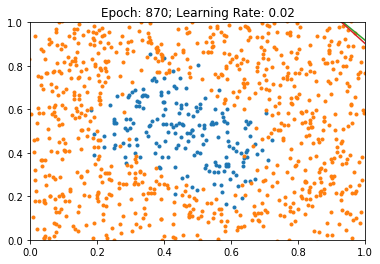

Epoch: 880
G1-Weight: tensor([[-0.9067, -0.7194]]) G1-Bias: tensor([1.6082])
G2-Weight: tensor([[-0.8547, -0.6115]]) G2-Bias: tensor([1.4512])
G3-Weight: tensor([[-0.1568, -0.1524]]) G1-Bias: tensor([-0.6356])
G4-Weight: tensor([[-0.1204, -0.1208]]) G2-Bias: tensor([-1.0742])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.9067 * x + 1.6082) / -0.7194)
z2: y = -((-0.8547 * x + 1.4512) / -0.6115)
z3: y = -((-0.1568 * x + -0.6356) / -0.1524)
z4: y = -((-0.1204 * x + -1.0742) / -0.1208)
Beta-Gerade: 0.7355855703353882
Beta-AND: -0.7803219556808472


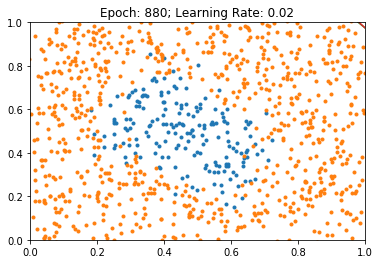

Epoch: 890
G1-Weight: tensor([[-0.9220, -0.7290]]) G1-Bias: tensor([1.6738])
G2-Weight: tensor([[-0.8617, -0.6136]]) G2-Bias: tensor([1.5060])
G3-Weight: tensor([[-0.1293, -0.1340]]) G1-Bias: tensor([-0.6554])
G4-Weight: tensor([[-0.0979, -0.1051]]) G2-Bias: tensor([-1.0932])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.922 * x + 1.6738) / -0.729)
z2: y = -((-0.8617 * x + 1.506) / -0.6136)
z3: y = -((-0.1293 * x + -0.6554) / -0.134)
z4: y = -((-0.0979 * x + -1.0932) / -0.1051)
Beta-Gerade: 0.763786256313324
Beta-AND: -0.7832025289535522


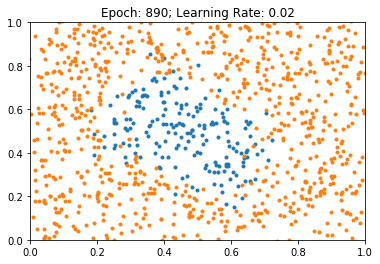

Epoch: 900
G1-Weight: tensor([[-0.9421, -0.7424]]) G1-Bias: tensor([1.7478])
G2-Weight: tensor([[-0.8716, -0.6172]]) G2-Bias: tensor([1.5667])
G3-Weight: tensor([[-0.0992, -0.1138]]) G1-Bias: tensor([-0.6793])
G4-Weight: tensor([[-0.0736, -0.0883]]) G2-Bias: tensor([-1.1154])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.9421 * x + 1.7478) / -0.7424)
z2: y = -((-0.8716 * x + 1.5667) / -0.6172)
z3: y = -((-0.0992 * x + -0.6793) / -0.1138)
z4: y = -((-0.0736 * x + -1.1154) / -0.0883)
Beta-Gerade: 0.7967122197151184
Beta-AND: -0.7863644361495972


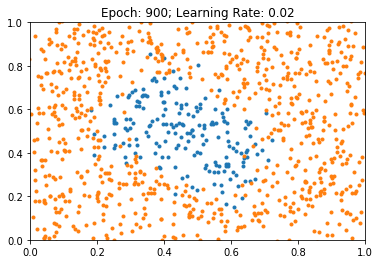

Epoch: 910
G1-Weight: tensor([[-0.9691, -0.7610]]) G1-Bias: tensor([1.8327])
G2-Weight: tensor([[-0.8857, -0.6229]]) G2-Bias: tensor([1.6350])
G3-Weight: tensor([[-0.0661, -0.0917]]) G1-Bias: tensor([-0.7083])
G4-Weight: tensor([[-0.0472, -0.0702]]) G2-Bias: tensor([-1.1415])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.9691 * x + 1.8327) / -0.761)
z2: y = -((-0.8857 * x + 1.635) / -0.6229)
z3: y = -((-0.0661 * x + -0.7083) / -0.0917)
z4: y = -((-0.0472 * x + -1.1415) / -0.0702)
Beta-Gerade: 0.8355903625488281
Beta-AND: -0.7898849844932556


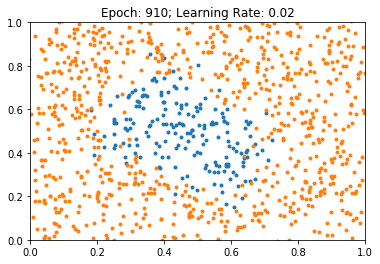

Epoch: 920
G1-Weight: tensor([[-1.0061, -0.7872]]) G1-Bias: tensor([1.9318])
G2-Weight: tensor([[-0.9060, -0.6318]]) G2-Bias: tensor([1.7130])
G3-Weight: tensor([[-0.0296, -0.0674]]) G1-Bias: tensor([-0.7433])
G4-Weight: tensor([[-0.0184, -0.0507]]) G2-Bias: tensor([-1.1723])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.0061 * x + 1.9318) / -0.7872)
z2: y = -((-0.906 * x + 1.713) / -0.6318)
z3: y = -((-0.0296 * x + -0.7433) / -0.0674)
z4: y = -((-0.0184 * x + -1.1723) / -0.0507)
Beta-Gerade: 0.8821384906768799
Beta-AND: -0.793871283531189


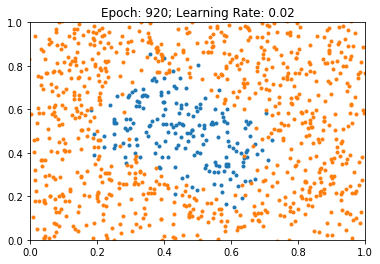

Epoch: 930
G1-Weight: tensor([[-1.0582, -0.8247]]) G1-Bias: tensor([2.0504])
G2-Weight: tensor([[-0.9357, -0.6452]]) G2-Bias: tensor([1.8042])
G3-Weight: tensor([[ 0.0112, -0.0406]]) G1-Bias: tensor([-0.7859])
G4-Weight: tensor([[ 0.0134, -0.0295]]) G2-Bias: tensor([-1.2087])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.0582 * x + 2.0504) / -0.8247)
z2: y = -((-0.9357 * x + 1.8042) / -0.6452)
z3: y = -((0.0112 * x + -0.7859) / -0.0406)
z4: y = -((0.0134 * x + -1.2087) / -0.0295)
Beta-Gerade: 0.9388395547866821
Beta-AND: -0.7984760999679565


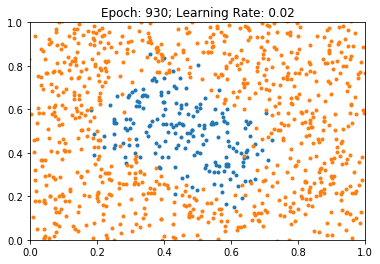

Epoch: 940
G1-Weight: tensor([[-1.1335, -0.8798]]) G1-Bias: tensor([2.1963])
G2-Weight: tensor([[-0.9801, -0.6658]]) G2-Bias: tensor([1.9143])
G3-Weight: tensor([[ 0.0571, -0.0107]]) G1-Bias: tensor([-0.8375])
G4-Weight: tensor([[ 0.0489, -0.0064]]) G2-Bias: tensor([-1.2514])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.1335 * x + 2.1963) / -0.8798)
z2: y = -((-0.9801 * x + 1.9143) / -0.6658)
z3: y = -((0.0571 * x + -0.8375) / -0.0107)
z4: y = -((0.0489 * x + -1.2514) / -0.0064)
Beta-Gerade: 1.0094012022018433
Beta-AND: -0.803920328617096


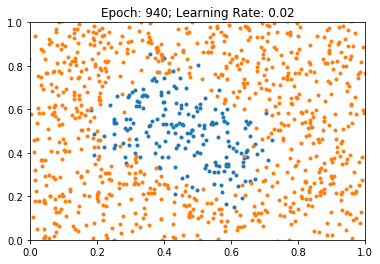

Epoch: 950
G1-Weight: tensor([[-1.2459, -0.9623]]) G1-Bias: tensor([2.3810])
G2-Weight: tensor([[-1.0492, -0.6974]]) G2-Bias: tensor([2.0523])
G3-Weight: tensor([[0.1098, 0.0230]]) G1-Bias: tensor([-0.8990])
G4-Weight: tensor([[0.0895, 0.0194]]) G2-Bias: tensor([-1.3010])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.2459 * x + 2.381) / -0.9623)
z2: y = -((-1.0492 * x + 2.0523) / -0.6974)
z3: y = -((0.1098 * x + -0.899) / 0.023)
z4: y = -((0.0895 * x + -1.301) / 0.0194)
Beta-Gerade: 1.099507451057434
Beta-AND: -0.8105254173278809


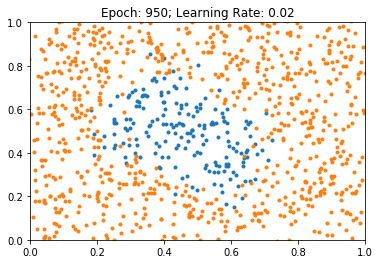

Epoch: 960
G1-Weight: tensor([[-1.4184, -1.0891]]) G1-Bias: tensor([2.6211])
G2-Weight: tensor([[-1.1614, -0.7466]]) G2-Bias: tensor([2.2337])
G3-Weight: tensor([[0.1724, 0.0624]]) G1-Bias: tensor([-0.9689])
G4-Weight: tensor([[0.1376, 0.0492]]) G2-Bias: tensor([-1.3557])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.4184 * x + 2.6211) / -1.0891)
z2: y = -((-1.1614 * x + 2.2337) / -0.7466)
z3: y = -((0.1724 * x + -0.9689) / 0.0624)
z4: y = -((0.1376 * x + -1.3557) / 0.0492)
Beta-Gerade: 1.2178696393966675
Beta-AND: -0.8187382817268372


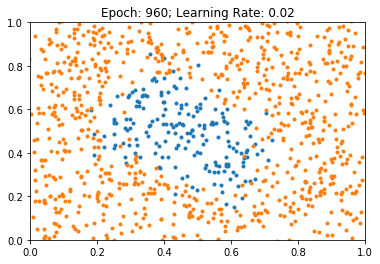

Epoch: 970
G1-Weight: tensor([[-1.6845, -1.2839]]) G1-Bias: tensor([2.9360])
G2-Weight: tensor([[-1.3534, -0.8232]]) G2-Bias: tensor([2.4825])
G3-Weight: tensor([[0.2516, 0.1126]]) G1-Bias: tensor([-1.0376])
G4-Weight: tensor([[0.1984, 0.0867]]) G2-Bias: tensor([-1.4086])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.6845 * x + 2.936) / -1.2839)
z2: y = -((-1.3534 * x + 2.4825) / -0.8232)
z3: y = -((0.2516 * x + -1.0376) / 0.1126)
z4: y = -((0.1984 * x + -1.4086) / 0.0867)
Beta-Gerade: 1.3768274784088135
Beta-AND: -0.8290659189224243


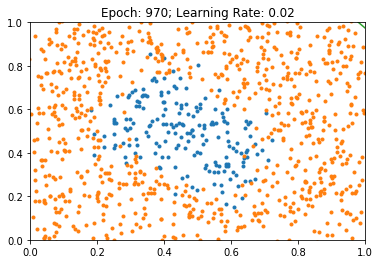

Epoch: 980
G1-Weight: tensor([[-2.0748, -1.5679]]) G1-Bias: tensor([3.3374])
G2-Weight: tensor([[-1.6902, -0.9374]]) G2-Bias: tensor([2.8214])
G3-Weight: tensor([[0.3649, 0.1880]]) G1-Bias: tensor([-1.0740])
G4-Weight: tensor([[0.2826, 0.1408]]) G2-Bias: tensor([-1.4403])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.0748 * x + 3.3374) / -1.5679)
z2: y = -((-1.6902 * x + 2.8214) / -0.9374)
z3: y = -((0.3649 * x + -1.074) / 0.188)
z4: y = -((0.2826 * x + -1.4403) / 0.1408)
Beta-Gerade: 1.5890947580337524
Beta-AND: -0.8416969180107117


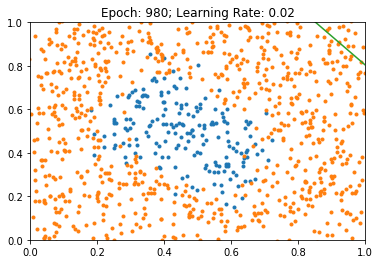

Epoch: 990
G1-Weight: tensor([[-2.5808, -1.9343]]) G1-Bias: tensor([3.8101])
G2-Weight: tensor([[-2.2437, -1.0886]]) G2-Bias: tensor([3.2340])
G3-Weight: tensor([[0.5546, 0.3216]]) G1-Bias: tensor([-1.0028])
G4-Weight: tensor([[0.4079, 0.2259]]) G2-Bias: tensor([-1.4144])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.5808 * x + 3.8101) / -1.9343)
z2: y = -((-2.2437 * x + 3.234) / -1.0886)
z3: y = -((0.5546 * x + -1.0028) / 0.3216)
z4: y = -((0.4079 * x + -1.4144) / 0.2259)
Beta-Gerade: 1.8553218841552734
Beta-AND: -0.8560214638710022


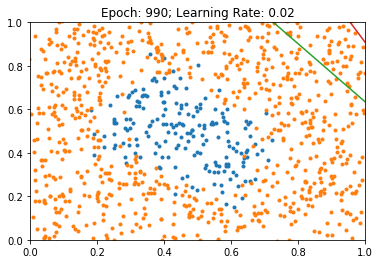

Epoch: 1000
G1-Weight: tensor([[-3.1697, -2.3824]]) G1-Bias: tensor([4.2823])
G2-Weight: tensor([[-3.0188, -1.2632]]) G2-Bias: tensor([3.6367])
G3-Weight: tensor([[0.9295, 0.5624]]) G1-Bias: tensor([-0.6768])
G4-Weight: tensor([[0.5630, 0.3202]]) G2-Bias: tensor([-1.3116])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.1697 * x + 4.2823) / -2.3824)
z2: y = -((-3.0188 * x + 3.6367) / -1.2632)
z3: y = -((0.9295 * x + -0.6768) / 0.5624)
z4: y = -((0.563 * x + -1.3116) / 0.3202)
Beta-Gerade: 2.155979633331299
Beta-AND: -0.875022292137146


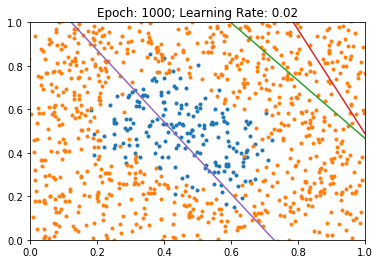

Epoch: 1010
G1-Weight: tensor([[-3.7696, -2.9469]]) G1-Bias: tensor([4.7049])
G2-Weight: tensor([[-3.9099, -1.3395]]) G2-Bias: tensor([4.0034])
G3-Weight: tensor([[1.7653, 0.8375]]) G1-Bias: tensor([-0.3443])
G4-Weight: tensor([[0.4782, 0.1567]]) G2-Bias: tensor([-1.3755])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.7696 * x + 4.7049) / -2.9469)
z2: y = -((-3.9099 * x + 4.0034) / -1.3395)
z3: y = -((1.7653 * x + -0.3443) / 0.8375)
z4: y = -((0.4782 * x + -1.3755) / 0.1567)
Beta-Gerade: 2.514861583709717
Beta-AND: -0.9320016503334045


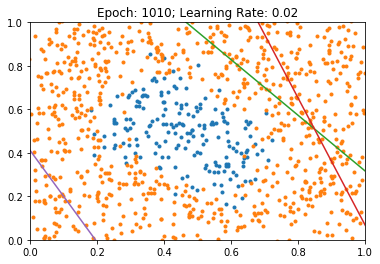

Epoch: 1020
G1-Weight: tensor([[-4.0310, -3.4723]]) G1-Bias: tensor([5.2317])
G2-Weight: tensor([[-4.7630, -0.9259]]) G2-Bias: tensor([4.3869])
G3-Weight: tensor([[2.8496, 0.9909]]) G1-Bias: tensor([-0.6642])
G4-Weight: tensor([[ 0.2924, -0.0317]]) G2-Bias: tensor([-1.5589])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.031 * x + 5.2317) / -3.4723)
z2: y = -((-4.763 * x + 4.3869) / -0.9259)
z3: y = -((2.8496 * x + -0.6642) / 0.9909)
z4: y = -((0.2924 * x + -1.5589) / -0.0317)
Beta-Gerade: 2.9734997749328613
Beta-AND: -1.0478037595748901


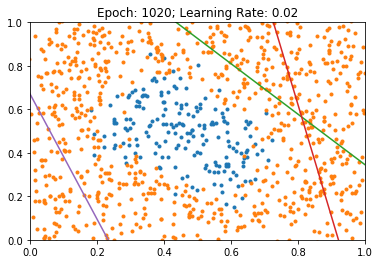

Epoch: 1030
G1-Weight: tensor([[-3.9420, -4.2073]]) G1-Bias: tensor([5.6766])
G2-Weight: tensor([[-5.4980, -0.2927]]) G2-Bias: tensor([4.6508])
G3-Weight: tensor([[3.8316, 1.1011]]) G1-Bias: tensor([-0.9751])
G4-Weight: tensor([[ 0.2405, -0.0490]]) G2-Bias: tensor([-1.6147])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.942 * x + 5.6766) / -4.2073)
z2: y = -((-5.498 * x + 4.6508) / -0.2927)
z3: y = -((3.8316 * x + -0.9751) / 1.1011)
z4: y = -((0.2405 * x + -1.6147) / -0.049)
Beta-Gerade: 3.4285309314727783
Beta-AND: -1.1690820455551147


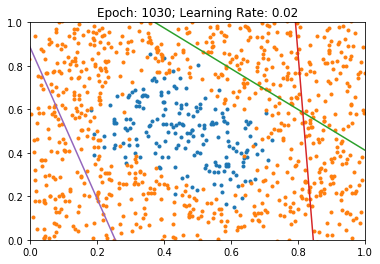

Epoch: 1040
G1-Weight: tensor([[-3.5157, -5.0433]]) G1-Bias: tensor([6.0070])
G2-Weight: tensor([[-6.0619,  0.3346]]) G2-Bias: tensor([4.8087])
G3-Weight: tensor([[4.5728, 1.2871]]) G1-Bias: tensor([-1.2319])
G4-Weight: tensor([[ 0.2562, -0.0009]]) G2-Bias: tensor([-1.5968])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.5157 * x + 6.007) / -5.0433)
z2: y = -((-6.0619 * x + 4.8087) / 0.3346)
z3: y = -((4.5728 * x + -1.2319) / 1.2871)
z4: y = -((0.2562 * x + -1.5968) / -0.0009)
Beta-Gerade: 3.8085262775421143
Beta-AND: -1.2669587135314941


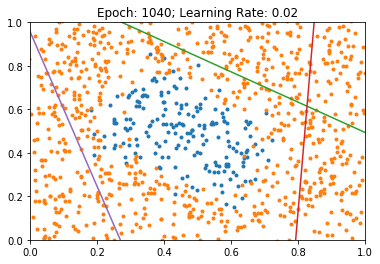

Epoch: 1050
G1-Weight: tensor([[-2.9774, -5.7914]]) G1-Bias: tensor([6.2435])
G2-Weight: tensor([[-6.4856,  0.8601]]) G2-Bias: tensor([4.8929])
G3-Weight: tensor([[5.0655, 1.6454]]) G1-Bias: tensor([-1.5049])
G4-Weight: tensor([[0.3004, 0.0721]]) G2-Bias: tensor([-1.5424])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.9774 * x + 6.2435) / -5.7914)
z2: y = -((-6.4856 * x + 4.8929) / 0.8601)
z3: y = -((5.0655 * x + -1.5049) / 1.6454)
z4: y = -((0.3004 * x + -1.5424) / 0.0721)
Beta-Gerade: 4.1017022132873535
Beta-AND: -1.3367717266082764


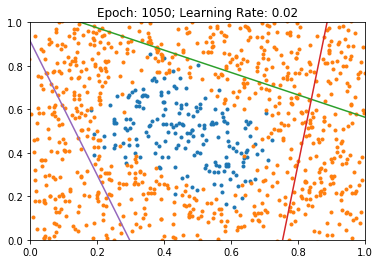

Epoch: 1060
G1-Weight: tensor([[-2.5179, -6.3728]]) G1-Bias: tensor([6.4087])
G2-Weight: tensor([[-6.8094,  1.2686]]) G2-Bias: tensor([4.9506])
G3-Weight: tensor([[5.3677, 2.1343]]) G1-Bias: tensor([-1.8012])
G4-Weight: tensor([[0.3688, 0.1687]]) G2-Bias: tensor([-1.4534])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.5179 * x + 6.4087) / -6.3728)
z2: y = -((-6.8094 * x + 4.9506) / 1.2686)
z3: y = -((5.3677 * x + -1.8012) / 2.1343)
z4: y = -((0.3688 * x + -1.4534) / 0.1687)
Beta-Gerade: 4.323819160461426
Beta-AND: -1.3825342655181885


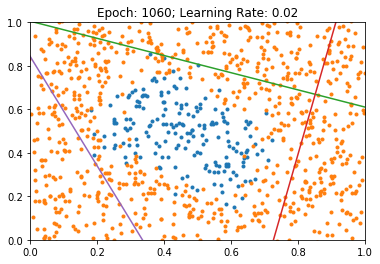

Epoch: 1070
G1-Weight: tensor([[-2.1750, -6.8078]]) G1-Bias: tensor([6.5258])
G2-Weight: tensor([[-7.0681,  1.5632]]) G2-Bias: tensor([5.0114])
G3-Weight: tensor([[5.5435, 2.6762]]) G1-Bias: tensor([-2.0932])
G4-Weight: tensor([[0.4890, 0.3237]]) G2-Bias: tensor([-1.2850])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.175 * x + 6.5258) / -6.8078)
z2: y = -((-7.0681 * x + 5.0114) / 1.5632)
z3: y = -((5.5435 * x + -2.0932) / 2.6762)
z4: y = -((0.489 * x + -1.285) / 0.3237)
Beta-Gerade: 4.494752883911133
Beta-AND: -1.4103891849517822


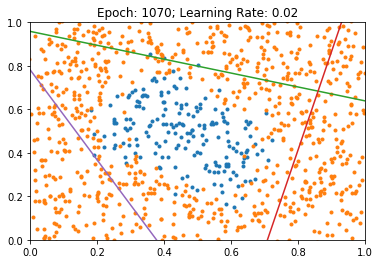

Epoch: 1080
G1-Weight: tensor([[-1.9592, -7.1730]]) G1-Bias: tensor([6.5739])
G2-Weight: tensor([[-7.3199,  1.6893]]) G2-Bias: tensor([5.0402])
G3-Weight: tensor([[5.6435, 3.1974]]) G1-Bias: tensor([-2.3693])
G4-Weight: tensor([[0.8540, 0.7603]]) G2-Bias: tensor([-0.7172])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.9592 * x + 6.5739) / -7.173)
z2: y = -((-7.3199 * x + 5.0402) / 1.6893)
z3: y = -((5.6435 * x + -2.3693) / 3.1974)
z4: y = -((0.854 * x + -0.7172) / 0.7603)
Beta-Gerade: 4.624791622161865
Beta-AND: -1.4286973476409912


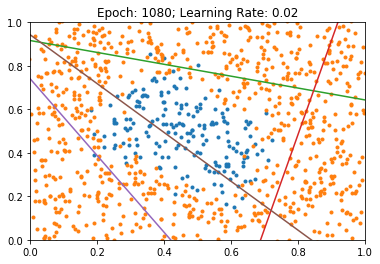

Epoch: 1090
G1-Weight: tensor([[-2.0533, -7.4754]]) G1-Bias: tensor([6.5366])
G2-Weight: tensor([[-7.6053,  1.2057]]) G2-Bias: tensor([5.0208])
G3-Weight: tensor([[5.6934, 3.3118]]) G1-Bias: tensor([-2.8297])
G4-Weight: tensor([[0.5266, 0.6811]]) G2-Bias: tensor([0.0737])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.0533 * x + 6.5366) / -7.4754)
z2: y = -((-7.6053 * x + 5.0208) / 1.2057)
z3: y = -((5.6934 * x + -2.8297) / 3.3118)
z4: y = -((0.5266 * x + 0.0737) / 0.6811)
Beta-Gerade: 4.708889961242676
Beta-AND: -1.5230112075805664


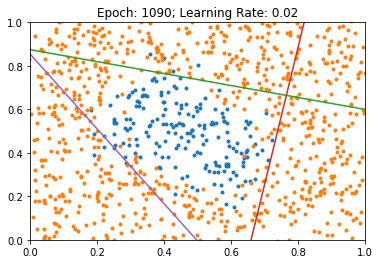

Epoch: 1100
G1-Weight: tensor([[-2.0098, -7.6274]]) G1-Bias: tensor([6.6650])
G2-Weight: tensor([[-7.5793,  0.8026]]) G2-Bias: tensor([5.3915])
G3-Weight: tensor([[5.8697, 3.5344]]) G1-Bias: tensor([-2.8790])
G4-Weight: tensor([[0.1194, 0.2825]]) G2-Bias: tensor([0.4048])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.0098 * x + 6.665) / -7.6274)
z2: y = -((-7.5793 * x + 5.3915) / 0.8026)
z3: y = -((5.8697 * x + -2.879) / 3.5344)
z4: y = -((0.1194 * x + 0.4048) / 0.2825)
Beta-Gerade: 4.809728145599365
Beta-AND: -1.708359956741333


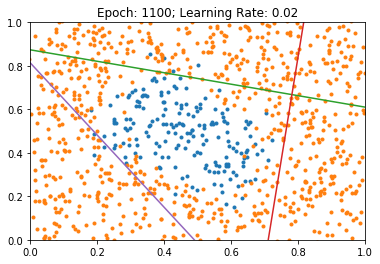

Epoch: 1110
G1-Weight: tensor([[-1.8246, -7.8287]]) G1-Bias: tensor([6.7406])
G2-Weight: tensor([[-7.6690,  0.6108]]) G2-Bias: tensor([5.5481])
G3-Weight: tensor([[5.9763, 3.7738]]) G1-Bias: tensor([-3.0253])
G4-Weight: tensor([[0.0335, 0.4000]]) G2-Bias: tensor([0.4548])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.8246 * x + 6.7406) / -7.8287)
z2: y = -((-7.669 * x + 5.5481) / 0.6108)
z3: y = -((5.9763 * x + -3.0253) / 3.7738)
z4: y = -((0.0335 * x + 0.4548) / 0.4)
Beta-Gerade: 4.929635524749756
Beta-AND: -1.902047872543335


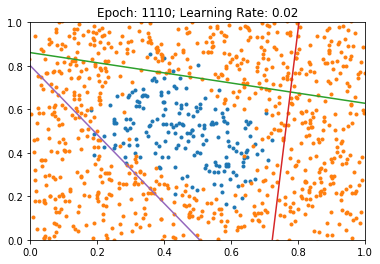

Epoch: 1120
G1-Weight: tensor([[-1.5944, -8.0681]]) G1-Bias: tensor([6.7575])
G2-Weight: tensor([[-7.8364,  0.4402]]) G2-Bias: tensor([5.5813])
G3-Weight: tensor([[6.0668, 3.9344]]) G1-Bias: tensor([-3.1883])
G4-Weight: tensor([[0.1796, 0.6816]]) G2-Bias: tensor([0.4024])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.5944 * x + 6.7575) / -8.0681)
z2: y = -((-7.8364 * x + 5.5813) / 0.4402)
z3: y = -((6.0668 * x + -3.1883) / 3.9344)
z4: y = -((0.1796 * x + 0.4024) / 0.6816)
Beta-Gerade: 5.049281120300293
Beta-AND: -2.0890915393829346


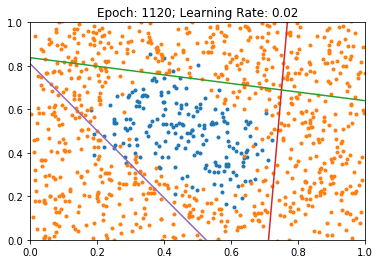

Epoch: 1130
G1-Weight: tensor([[-1.4493, -8.2975]]) G1-Bias: tensor([6.7324])
G2-Weight: tensor([[-7.8997,  0.2356]]) G2-Bias: tensor([5.7146])
G3-Weight: tensor([[6.2143, 3.9632]]) G1-Bias: tensor([-3.2724])
G4-Weight: tensor([[0.1090, 1.3324]]) G2-Bias: tensor([0.2960])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.4493 * x + 6.7324) / -8.2975)
z2: y = -((-7.8997 * x + 5.7146) / 0.2356)
z3: y = -((6.2143 * x + -3.2724) / 3.9632)
z4: y = -((0.109 * x + 0.296) / 1.3324)
Beta-Gerade: 5.157722473144531
Beta-AND: -2.267045736312866


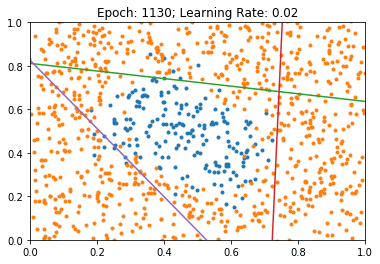

Epoch: 1140
G1-Weight: tensor([[-1.3618, -8.4131]]) G1-Bias: tensor([6.7651])
G2-Weight: tensor([[-7.8944, -0.1215]]) G2-Bias: tensor([5.8996])
G3-Weight: tensor([[6.4593, 3.7645]]) G1-Bias: tensor([-3.2479])
G4-Weight: tensor([[-0.2249,  2.3070]]) G2-Bias: tensor([0.1699])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.3618 * x + 6.7651) / -8.4131)
z2: y = -((-7.8944 * x + 5.8996) / -0.1215)
z3: y = -((6.4593 * x + -3.2479) / 3.7645)
z4: y = -((-0.2249 * x + 0.1699) / 2.307)
Beta-Gerade: 5.271424770355225
Beta-AND: -2.4346325397491455


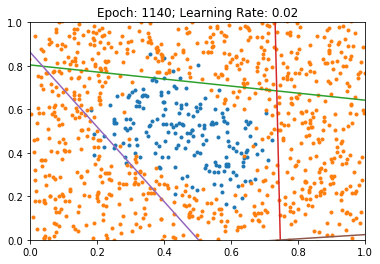

Epoch: 1150
G1-Weight: tensor([[-1.3835, -8.4235]]) G1-Bias: tensor([6.8454])
G2-Weight: tensor([[-7.8595, -0.6312]]) G2-Bias: tensor([6.0793])
G3-Weight: tensor([[6.7289, 3.4239]]) G1-Bias: tensor([-3.1755])
G4-Weight: tensor([[-0.4342,  3.1339]]) G2-Bias: tensor([0.0318])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.3835 * x + 6.8454) / -8.4235)
z2: y = -((-7.8595 * x + 6.0793) / -0.6312)
z3: y = -((6.7289 * x + -3.1755) / 3.4239)
z4: y = -((-0.4342 * x + 0.0318) / 3.1339)
Beta-Gerade: 5.387946605682373
Beta-AND: -2.585571527481079


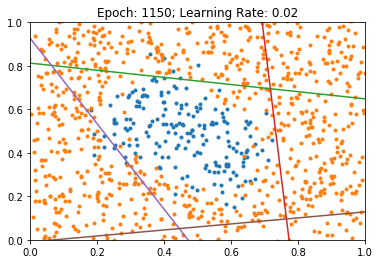

Epoch: 1160
G1-Weight: tensor([[-1.5215, -8.3926]]) G1-Bias: tensor([6.9221])
G2-Weight: tensor([[-7.7728, -1.1766]]) G2-Bias: tensor([6.2693])
G3-Weight: tensor([[6.9552, 3.1200]]) G1-Bias: tensor([-3.0786])
G4-Weight: tensor([[-0.4489,  3.7253]]) G2-Bias: tensor([-0.1559])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.5215 * x + 6.9221) / -8.3926)
z2: y = -((-7.7728 * x + 6.2693) / -1.1766)
z3: y = -((6.9552 * x + -3.0786) / 3.12)
z4: y = -((-0.4489 * x + -0.1559) / 3.7253)
Beta-Gerade: 5.4916791915893555
Beta-AND: -2.7186365127563477


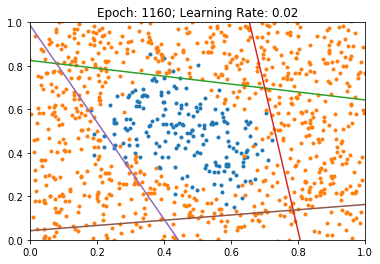

Epoch: 1170
G1-Weight: tensor([[-1.6775, -8.3414]]) G1-Bias: tensor([6.9977])
G2-Weight: tensor([[-7.6811, -1.6631]]) G2-Bias: tensor([6.4317])
G3-Weight: tensor([[7.1241, 2.8645]]) G1-Bias: tensor([-2.9924])
G4-Weight: tensor([[-0.3531,  4.1585]]) G2-Bias: tensor([-0.3510])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.6775 * x + 6.9977) / -8.3414)
z2: y = -((-7.6811 * x + 6.4317) / -1.6631)
z3: y = -((7.1241 * x + -2.9924) / 2.8645)
z4: y = -((-0.3531 * x + -0.351) / 4.1585)
Beta-Gerade: 5.582973957061768
Beta-AND: -2.8362984657287598


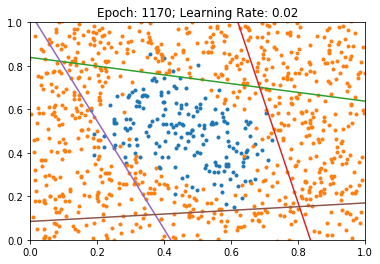

Epoch: 1180
G1-Weight: tensor([[-1.8050, -8.2975]]) G1-Bias: tensor([7.0581])
G2-Weight: tensor([[-7.6209, -2.0113]]) G2-Bias: tensor([6.5557])
G3-Weight: tensor([[7.2546, 2.6417]]) G1-Bias: tensor([-2.9080])
G4-Weight: tensor([[-0.2392,  4.4974]]) G2-Bias: tensor([-0.5250])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.805 * x + 7.0581) / -8.2975)
z2: y = -((-7.6209 * x + 6.5557) / -2.0113)
z3: y = -((7.2546 * x + -2.908) / 2.6417)
z4: y = -((-0.2392 * x + -0.525) / 4.4974)
Beta-Gerade: 5.665567874908447
Beta-AND: -2.9416277408599854


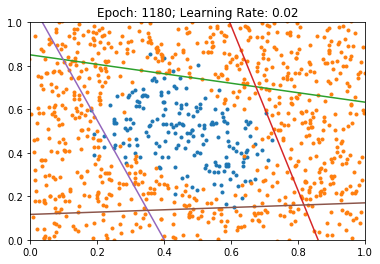

Epoch: 1190
G1-Weight: tensor([[-1.8978, -8.2698]]) G1-Bias: tensor([7.0999])
G2-Weight: tensor([[-7.6050, -2.2137]]) G2-Bias: tensor([6.6457])
G3-Weight: tensor([[7.3605, 2.4407]]) G1-Bias: tensor([-2.8198])
G4-Weight: tensor([[-0.1412,  4.7758]]) G2-Bias: tensor([-0.6721])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.8978 * x + 7.0999) / -8.2698)
z2: y = -((-7.605 * x + 6.6457) / -2.2137)
z3: y = -((7.3605 * x + -2.8198) / 2.4407)
z4: y = -((-0.1412 * x + -0.6721) / 4.7758)
Beta-Gerade: 5.741130828857422
Beta-AND: -3.037365198135376


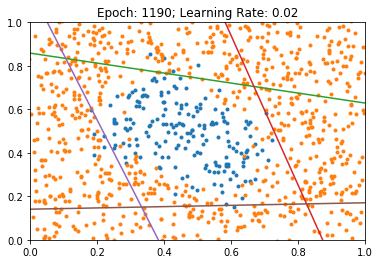

Epoch: 1200
G1-Weight: tensor([[-1.9640, -8.2499]]) G1-Bias: tensor([7.1325])
G2-Weight: tensor([[-7.6284, -2.3121]]) G2-Bias: tensor([6.7083])
G3-Weight: tensor([[7.4454, 2.2578]]) G1-Bias: tensor([-2.7356])
G4-Weight: tensor([[-0.0492,  5.0106]]) G2-Bias: tensor([-0.7979])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-1.964 * x + 7.1325) / -8.2499)
z2: y = -((-7.6284 * x + 6.7083) / -2.3121)
z3: y = -((7.4454 * x + -2.7356) / 2.2578)
z4: y = -((-0.0492 * x + -0.7979) / 5.0106)
Beta-Gerade: 5.810229778289795
Beta-AND: -3.125645160675049


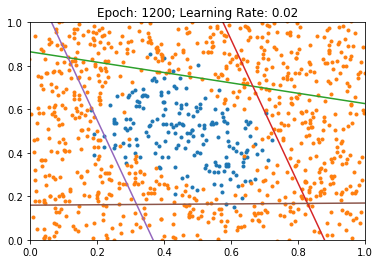

Epoch: 1210
G1-Weight: tensor([[-2.0196, -8.2337]]) G1-Bias: tensor([7.1586])
G2-Weight: tensor([[-7.6751, -2.3477]]) G2-Bias: tensor([6.7546])
G3-Weight: tensor([[7.5120, 2.0988]]) G1-Bias: tensor([-2.6585])
G4-Weight: tensor([[0.0501, 5.2097]]) G2-Bias: tensor([-0.9139])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.0196 * x + 7.1586) / -8.2337)
z2: y = -((-7.6751 * x + 6.7546) / -2.3477)
z3: y = -((7.512 * x + -2.6585) / 2.0988)
z4: y = -((0.0501 * x + -0.9139) / 5.2097)
Beta-Gerade: 5.873371124267578
Beta-AND: -3.208000659942627


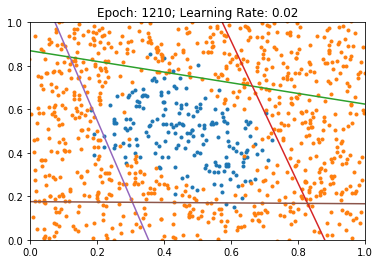

Epoch: 1220
G1-Weight: tensor([[-2.0732, -8.2187]]) G1-Bias: tensor([7.1800])
G2-Weight: tensor([[-7.7326, -2.3490]]) G2-Bias: tensor([6.7918])
G3-Weight: tensor([[7.5635, 1.9639]]) G1-Bias: tensor([-2.5892])
G4-Weight: tensor([[0.1624, 5.3796]]) G2-Bias: tensor([-1.0265])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.0732 * x + 7.18) / -8.2187)
z2: y = -((-7.7326 * x + 6.7918) / -2.349)
z3: y = -((7.5635 * x + -2.5892) / 1.9639)
z4: y = -((0.1624 * x + -1.0265) / 5.3796)
Beta-Gerade: 5.931267738342285
Beta-AND: -3.285501003265381


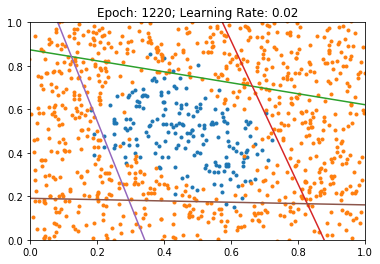

Epoch: 1230
G1-Weight: tensor([[-2.1252, -8.2034]]) G1-Bias: tensor([7.1989])
G2-Weight: tensor([[-7.7951, -2.3320]]) G2-Bias: tensor([6.8224])
G3-Weight: tensor([[7.6030, 1.8469]]) G1-Bias: tensor([-2.5266])
G4-Weight: tensor([[0.2856, 5.5271]]) G2-Bias: tensor([-1.1362])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.1252 * x + 7.1989) / -8.2034)
z2: y = -((-7.7951 * x + 6.8224) / -2.332)
z3: y = -((7.603 * x + -2.5266) / 1.8469)
z4: y = -((0.2856 * x + -1.1362) / 5.5271)
Beta-Gerade: 5.984720230102539
Beta-AND: -3.3589119911193848


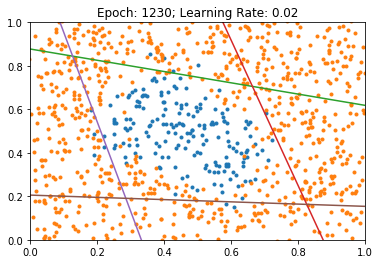

Epoch: 1240
G1-Weight: tensor([[-2.1741, -8.1884]]) G1-Bias: tensor([7.2154])
G2-Weight: tensor([[-7.8594, -2.3036]]) G2-Bias: tensor([6.8481])
G3-Weight: tensor([[7.6338, 1.7408]]) G1-Bias: tensor([-2.4679])
G4-Weight: tensor([[0.4137, 5.6580]]) G2-Bias: tensor([-1.2422])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.1741 * x + 7.2154) / -8.1884)
z2: y = -((-7.8594 * x + 6.8481) / -2.3036)
z3: y = -((7.6338 * x + -2.4679) / 1.7408)
z4: y = -((0.4137 * x + -1.2422) / 5.658)
Beta-Gerade: 6.034448146820068
Beta-AND: -3.4288101196289062


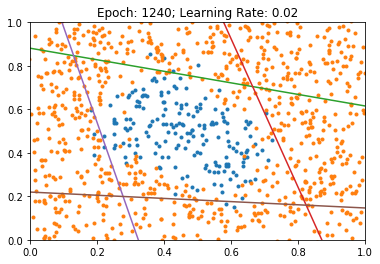

Epoch: 1250
G1-Weight: tensor([[-2.2192, -8.1742]]) G1-Bias: tensor([7.2298])
G2-Weight: tensor([[-7.9235, -2.2671]]) G2-Bias: tensor([6.8701])
G3-Weight: tensor([[7.6583, 1.6402]]) G1-Bias: tensor([-2.4103])
G4-Weight: tensor([[0.5413, 5.7766]]) G2-Bias: tensor([-1.3436])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.2192 * x + 7.2298) / -8.1742)
z2: y = -((-7.9235 * x + 6.8701) / -2.2671)
z3: y = -((7.6583 * x + -2.4103) / 1.6402)
z4: y = -((0.5413 * x + -1.3436) / 5.7766)
Beta-Gerade: 6.081013202667236
Beta-AND: -3.495650291442871


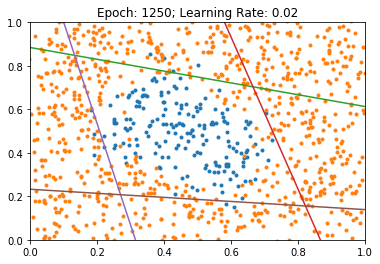

Epoch: 1260
G1-Weight: tensor([[-2.2607, -8.1606]]) G1-Bias: tensor([7.2424])
G2-Weight: tensor([[-7.9863, -2.2257]]) G2-Bias: tensor([6.8889])
G3-Weight: tensor([[7.6782, 1.5410]]) G1-Bias: tensor([-2.3524])
G4-Weight: tensor([[0.6654, 5.8862]]) G2-Bias: tensor([-1.4402])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.2607 * x + 7.2424) / -8.1606)
z2: y = -((-7.9863 * x + 6.8889) / -2.2257)
z3: y = -((7.6782 * x + -2.3524) / 1.541)
z4: y = -((0.6654 * x + -1.4402) / 5.8862)
Beta-Gerade: 6.124830722808838
Beta-AND: -3.559798240661621


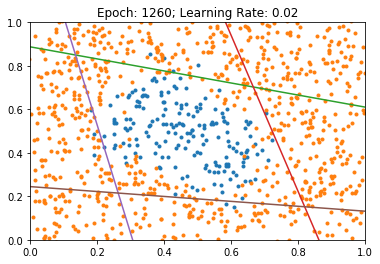

Epoch: 1270
G1-Weight: tensor([[-2.3003, -8.1468]]) G1-Bias: tensor([7.2539])
G2-Weight: tensor([[-8.0469, -2.1816]]) G2-Bias: tensor([6.9053])
G3-Weight: tensor([[7.6946, 1.4410]]) G1-Bias: tensor([-2.2930])
G4-Weight: tensor([[0.7854, 5.9887]]) G2-Bias: tensor([-1.5322])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.3003 * x + 7.2539) / -8.1468)
z2: y = -((-8.0469 * x + 6.9053) / -2.1816)
z3: y = -((7.6946 * x + -2.293) / 1.441)
z4: y = -((0.7854 * x + -1.5322) / 5.9887)
Beta-Gerade: 6.166213035583496
Beta-AND: -3.621553421020508


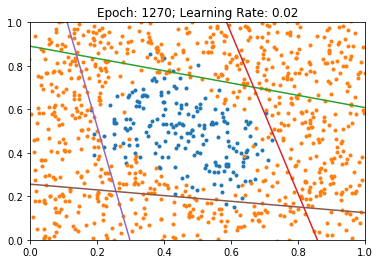

Epoch: 1280
G1-Weight: tensor([[-2.3395, -8.1323]]) G1-Bias: tensor([7.2646])
G2-Weight: tensor([[-8.1045, -2.1369]]) G2-Bias: tensor([6.9197])
G3-Weight: tensor([[7.7084, 1.3386]]) G1-Bias: tensor([-2.2317])
G4-Weight: tensor([[0.9014, 6.0853]]) G2-Bias: tensor([-1.6204])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.3395 * x + 7.2646) / -8.1323)
z2: y = -((-8.1045 * x + 6.9197) / -2.1369)
z3: y = -((7.7084 * x + -2.2317) / 1.3386)
z4: y = -((0.9014 * x + -1.6204) / 6.0853)
Beta-Gerade: 6.2054266929626465
Beta-AND: -3.6811647415161133


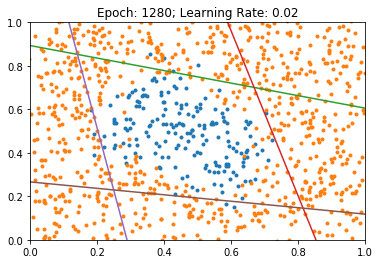

Epoch: 1290
G1-Weight: tensor([[-2.3796, -8.1167]]) G1-Bias: tensor([7.2749])
G2-Weight: tensor([[-8.1588, -2.0927]]) G2-Bias: tensor([6.9325])
G3-Weight: tensor([[7.7205, 1.2325]]) G1-Bias: tensor([-2.1678])
G4-Weight: tensor([[1.0140, 6.1769]]) G2-Bias: tensor([-1.7053])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.3796 * x + 7.2749) / -8.1167)
z2: y = -((-8.1588 * x + 6.9325) / -2.0927)
z3: y = -((7.7205 * x + -2.1678) / 1.2325)
z4: y = -((1.014 * x + -1.7053) / 6.1769)
Beta-Gerade: 6.242717742919922
Beta-AND: -3.738842010498047


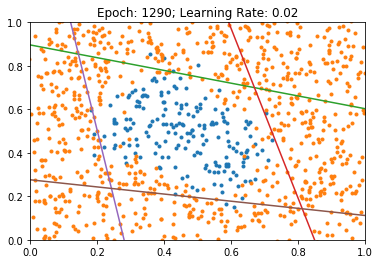

Epoch: 1300
G1-Weight: tensor([[-2.4215, -8.0998]]) G1-Bias: tensor([7.2851])
G2-Weight: tensor([[-8.2098, -2.0496]]) G2-Bias: tensor([6.9440])
G3-Weight: tensor([[7.7316, 1.1213]]) G1-Bias: tensor([-2.1008])
G4-Weight: tensor([[1.1238, 6.2642]]) G2-Bias: tensor([-1.7877])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.4215 * x + 7.2851) / -8.0998)
z2: y = -((-8.2098 * x + 6.944) / -2.0496)
z3: y = -((7.7316 * x + -2.1008) / 1.1213)
z4: y = -((1.1238 * x + -1.7877) / 6.2642)
Beta-Gerade: 6.278316020965576
Beta-AND: -3.7947638034820557


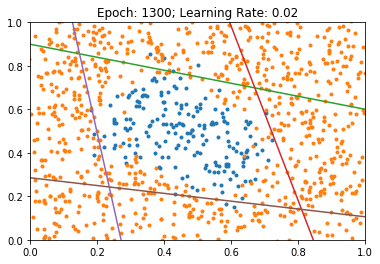

Epoch: 1310
G1-Weight: tensor([[-2.4657, -8.0815]]) G1-Bias: tensor([7.2956])
G2-Weight: tensor([[-8.2576, -2.0076]]) G2-Bias: tensor([6.9542])
G3-Weight: tensor([[7.7426, 1.0041]]) G1-Bias: tensor([-2.0302])
G4-Weight: tensor([[1.2314, 6.3477]]) G2-Bias: tensor([-1.8679])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.4657 * x + 7.2956) / -8.0815)
z2: y = -((-8.2576 * x + 6.9542) / -2.0076)
z3: y = -((7.7426 * x + -2.0302) / 1.0041)
z4: y = -((1.2314 * x + -1.8679) / 6.3477)
Beta-Gerade: 6.312431335449219
Beta-AND: -3.849085807800293


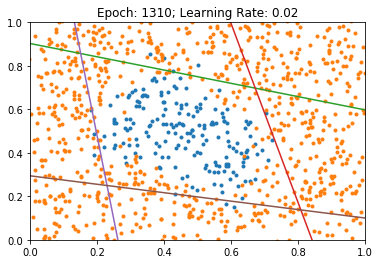

Epoch: 1320
G1-Weight: tensor([[-2.5124, -8.0618]]) G1-Bias: tensor([7.3063])
G2-Weight: tensor([[-8.3024, -1.9667]]) G2-Bias: tensor([6.9633])
G3-Weight: tensor([[7.7541, 0.8799]]) G1-Bias: tensor([-1.9555])
G4-Weight: tensor([[1.3374, 6.4278]]) G2-Bias: tensor([-1.9463])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.5124 * x + 7.3063) / -8.0618)
z2: y = -((-8.3024 * x + 6.9633) / -1.9667)
z3: y = -((7.7541 * x + -1.9555) / 0.8799)
z4: y = -((1.3374 * x + -1.9463) / 6.4278)
Beta-Gerade: 6.345245838165283
Beta-AND: -3.9019460678100586


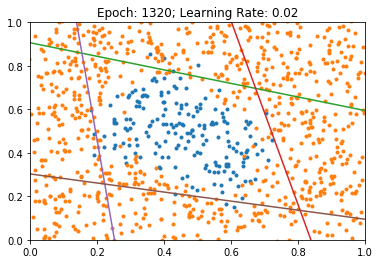

Epoch: 1330
G1-Weight: tensor([[-2.5620, -8.0408]]) G1-Bias: tensor([7.3176])
G2-Weight: tensor([[-8.3447, -1.9265]]) G2-Bias: tensor([6.9713])
G3-Weight: tensor([[7.7669, 0.7476]]) G1-Bias: tensor([-1.8762])
G4-Weight: tensor([[1.4424, 6.5045]]) G2-Bias: tensor([-2.0234])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.562 * x + 7.3176) / -8.0408)
z2: y = -((-8.3447 * x + 6.9713) / -1.9265)
z3: y = -((7.7669 * x + -1.8762) / 0.7476)
z4: y = -((1.4424 * x + -2.0234) / 6.5045)
Beta-Gerade: 6.376914978027344
Beta-AND: -3.9534690380096436


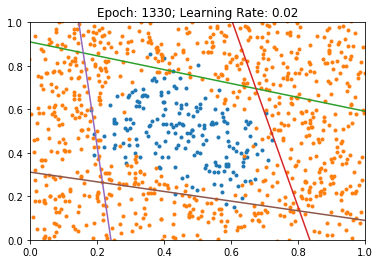

Epoch: 1340
G1-Weight: tensor([[-2.6151, -8.0184]]) G1-Bias: tensor([7.3296])
G2-Weight: tensor([[-8.3847, -1.8867]]) G2-Bias: tensor([6.9782])
G3-Weight: tensor([[7.7816, 0.6062]]) G1-Bias: tensor([-1.7916])
G4-Weight: tensor([[1.5471, 6.5781]]) G2-Bias: tensor([-2.0995])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.6151 * x + 7.3296) / -8.0184)
z2: y = -((-8.3847 * x + 6.9782) / -1.8867)
z3: y = -((7.7816 * x + -1.7916) / 0.6062)
z4: y = -((1.5471 * x + -2.0995) / 6.5781)
Beta-Gerade: 6.407566547393799
Beta-AND: -4.003769874572754


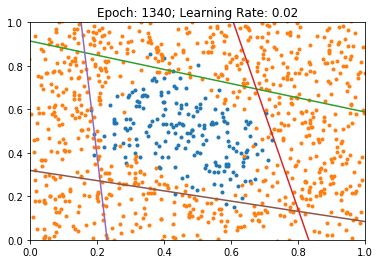

Epoch: 1350
G1-Weight: tensor([[-2.6720, -7.9946]]) G1-Bias: tensor([7.3424])
G2-Weight: tensor([[-8.4227, -1.8469]]) G2-Bias: tensor([6.9840])
G3-Weight: tensor([[7.7994, 0.4539]]) G1-Bias: tensor([-1.7006])
G4-Weight: tensor([[1.6523, 6.6485]]) G2-Bias: tensor([-2.1750])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.672 * x + 7.3424) / -7.9946)
z2: y = -((-8.4227 * x + 6.984) / -1.8469)
z3: y = -((7.7994 * x + -1.7006) / 0.4539)
z4: y = -((1.6523 * x + -2.175) / 6.6485)
Beta-Gerade: 6.43731689453125
Beta-AND: -4.052955150604248


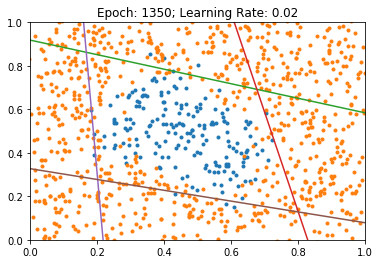

Epoch: 1360
G1-Weight: tensor([[-2.7333, -7.9695]]) G1-Bias: tensor([7.3565])
G2-Weight: tensor([[-8.4592, -1.8063]]) G2-Bias: tensor([6.9886])
G3-Weight: tensor([[7.8221, 0.2877]]) G1-Bias: tensor([-1.6016])
G4-Weight: tensor([[1.7590, 6.7153]]) G2-Bias: tensor([-2.2502])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.7333 * x + 7.3565) / -7.9695)
z2: y = -((-8.4592 * x + 6.9886) / -1.8063)
z3: y = -((7.8221 * x + -1.6016) / 0.2877)
z4: y = -((1.759 * x + -2.2502) / 6.7153)
Beta-Gerade: 6.466300964355469
Beta-AND: -4.101129055023193


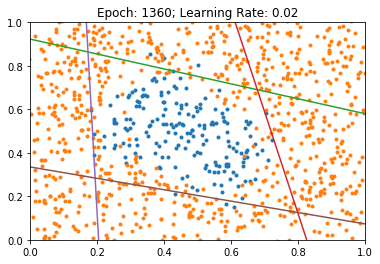

Epoch: 1370
G1-Weight: tensor([[-2.7995, -7.9430]]) G1-Bias: tensor([7.3719])
G2-Weight: tensor([[-8.4944, -1.7645]]) G2-Bias: tensor([6.9920])
G3-Weight: tensor([[7.8521, 0.1027]]) G1-Bias: tensor([-1.4919])
G4-Weight: tensor([[1.8686, 6.7781]]) G2-Bias: tensor([-2.3256])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.7995 * x + 7.3719) / -7.943)
z2: y = -((-8.4944 * x + 6.992) / -1.7645)
z3: y = -((7.8521 * x + -1.4919) / 0.1027)
z4: y = -((1.8686 * x + -2.3256) / 6.7781)
Beta-Gerade: 6.494730472564697
Beta-AND: -4.148392677307129


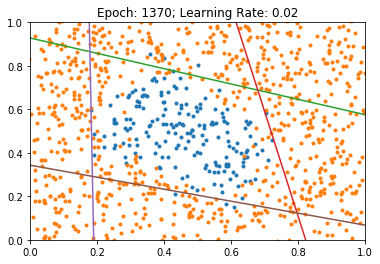

Epoch: 1380
G1-Weight: tensor([[-2.8717, -7.9147]]) G1-Bias: tensor([7.3891])
G2-Weight: tensor([[-8.5289, -1.7205]]) G2-Bias: tensor([6.9941])
G3-Weight: tensor([[ 7.8926, -0.1063]]) G1-Bias: tensor([-1.3694])
G4-Weight: tensor([[1.9828, 6.8361]]) G2-Bias: tensor([-2.4017])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.8717 * x + 7.3891) / -7.9147)
z2: y = -((-8.5289 * x + 6.9941) / -1.7205)
z3: y = -((7.8926 * x + -1.3694) / -0.1063)
z4: y = -((1.9828 * x + -2.4017) / 6.8361)
Beta-Gerade: 6.522957801818848
Beta-AND: -4.194850444793701


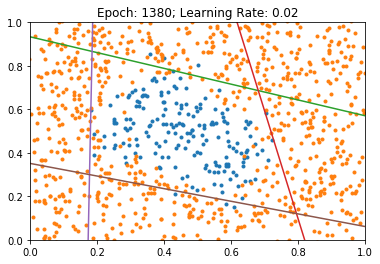

Epoch: 1390
G1-Weight: tensor([[-2.9516, -7.8840]]) G1-Bias: tensor([7.4087])
G2-Weight: tensor([[-8.5632, -1.6734]]) G2-Bias: tensor([6.9945])
G3-Weight: tensor([[ 7.9457, -0.3414]]) G1-Bias: tensor([-1.2346])
G4-Weight: tensor([[2.1036, 6.8886]]) G2-Bias: tensor([-2.4785])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-2.9516 * x + 7.4087) / -7.884)
z2: y = -((-8.5632 * x + 6.9945) / -1.6734)
z3: y = -((7.9457 * x + -1.2346) / -0.3414)
z4: y = -((2.1036 * x + -2.4785) / 6.8886)
Beta-Gerade: 6.551497936248779
Beta-AND: -4.2406110763549805


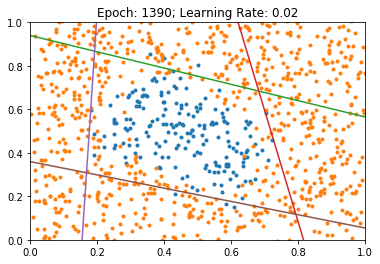

Epoch: 1400
G1-Weight: tensor([[-3.0415, -7.8505]]) G1-Bias: tensor([7.4313])
G2-Weight: tensor([[-8.5981, -1.6215]]) G2-Bias: tensor([6.9928])
G3-Weight: tensor([[ 8.0114, -0.5955]]) G1-Bias: tensor([-1.0932])
G4-Weight: tensor([[2.2317, 6.9350]]) G2-Bias: tensor([-2.5555])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.0415 * x + 7.4313) / -7.8505)
z2: y = -((-8.5981 * x + 6.9928) / -1.6215)
z3: y = -((8.0114 * x + -1.0932) / -0.5955)
z4: y = -((2.2317 * x + -2.5555) / 6.935)
Beta-Gerade: 6.580896854400635
Beta-AND: -4.285789489746094


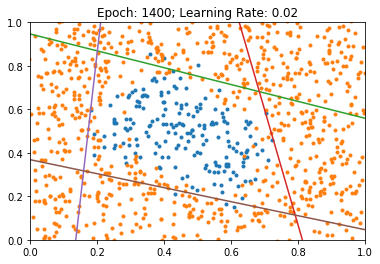

Epoch: 1410
G1-Weight: tensor([[-3.1427, -7.8142]]) G1-Bias: tensor([7.4573])
G2-Weight: tensor([[-8.6341, -1.5624]]) G2-Bias: tensor([6.9888])
G3-Weight: tensor([[ 8.0868, -0.8532]]) G1-Bias: tensor([-0.9543])
G4-Weight: tensor([[2.3659, 6.9752]]) G2-Bias: tensor([-2.6315])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.1427 * x + 7.4573) / -7.8142)
z2: y = -((-8.6341 * x + 6.9888) / -1.5624)
z3: y = -((8.0868 * x + -0.9543) / -0.8532)
z4: y = -((2.3659 * x + -2.6315) / 6.9752)
Beta-Gerade: 6.611481189727783
Beta-AND: -4.330499172210693


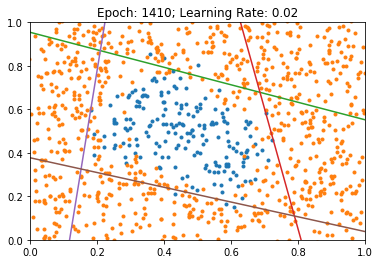

Epoch: 1420
G1-Weight: tensor([[-3.2543, -7.7765]]) G1-Bias: tensor([7.4865])
G2-Weight: tensor([[-8.6720, -1.4937]]) G2-Bias: tensor([6.9820])
G3-Weight: tensor([[ 8.1681, -1.0988]]) G1-Bias: tensor([-0.8258])
G4-Weight: tensor([[2.5033, 7.0098]]) G2-Bias: tensor([-2.7052])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.2543 * x + 7.4865) / -7.7765)
z2: y = -((-8.672 * x + 6.982) / -1.4937)
z3: y = -((8.1681 * x + -0.8258) / -1.0988)
z4: y = -((2.5033 * x + -2.7052) / 7.0098)
Beta-Gerade: 6.643246173858643
Beta-AND: -4.3748345375061035


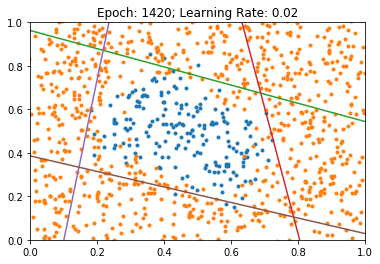

Epoch: 1430
G1-Weight: tensor([[-3.3725, -7.7396]]) G1-Bias: tensor([7.5186])
G2-Weight: tensor([[-8.7119, -1.4137]]) G2-Bias: tensor([6.9726])
G3-Weight: tensor([[ 8.2523, -1.3231]]) G1-Bias: tensor([-0.7112])
G4-Weight: tensor([[2.6407, 7.0397]]) G2-Bias: tensor([-2.7757])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.3725 * x + 7.5186) / -7.7396)
z2: y = -((-8.7119 * x + 6.9726) / -1.4137)
z3: y = -((8.2523 * x + -0.7112) / -1.3231)
z4: y = -((2.6407 * x + -2.7757) / 7.0397)
Beta-Gerade: 6.675929546356201
Beta-AND: -4.4188551902771


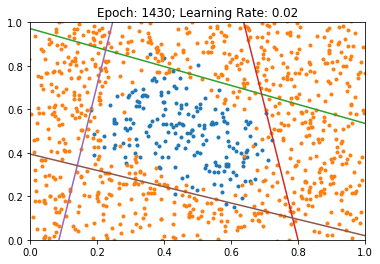

Epoch: 1440
G1-Weight: tensor([[-3.4931, -7.7054]]) G1-Bias: tensor([7.5533])
G2-Weight: tensor([[-8.7538, -1.3222]]) G2-Bias: tensor([6.9607])
G3-Weight: tensor([[ 8.3330, -1.5228]]) G1-Bias: tensor([-0.6125])
G4-Weight: tensor([[2.7756, 7.0659]]) G2-Bias: tensor([-2.8421])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.4931 * x + 7.5533) / -7.7054)
z2: y = -((-8.7538 * x + 6.9607) / -1.3222)
z3: y = -((8.333 * x + -0.6125) / -1.5228)
z4: y = -((2.7756 * x + -2.8421) / 7.0659)
Beta-Gerade: 6.708251953125
Beta-AND: -4.462585926055908


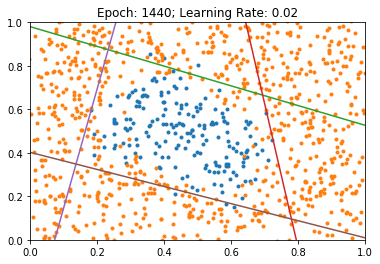

Epoch: 1450
G1-Weight: tensor([[-3.6140, -7.6758]]) G1-Bias: tensor([7.5900])
G2-Weight: tensor([[-8.7974, -1.2193]]) G2-Bias: tensor([6.9468])
G3-Weight: tensor([[ 8.3962, -1.6869]]) G1-Bias: tensor([-0.5280])
G4-Weight: tensor([[2.9054, 7.0895]]) G2-Bias: tensor([-2.9044])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.614 * x + 7.59) / -7.6758)
z2: y = -((-8.7974 * x + 6.9468) / -1.2193)
z3: y = -((8.3962 * x + -0.528) / -1.6869)
z4: y = -((2.9054 * x + -2.9044) / 7.0895)
Beta-Gerade: 6.734818458557129
Beta-AND: -4.5060224533081055


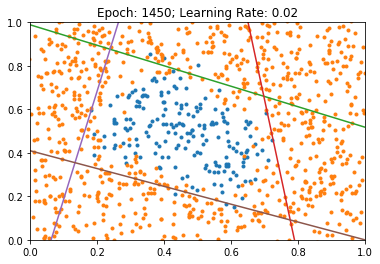

Epoch: 1460
G1-Weight: tensor([[-3.7323, -7.6507]]) G1-Bias: tensor([7.6296])
G2-Weight: tensor([[-8.8430, -1.1058]]) G2-Bias: tensor([6.9308])
G3-Weight: tensor([[ 8.4313, -1.8211]]) G1-Bias: tensor([-0.4605])
G4-Weight: tensor([[3.0289, 7.1122]]) G2-Bias: tensor([-2.9613])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.7323 * x + 7.6296) / -7.6507)
z2: y = -((-8.843 * x + 6.9308) / -1.1058)
z3: y = -((8.4313 * x + -0.4605) / -1.8211)
z4: y = -((3.0289 * x + -2.9613) / 7.1122)
Beta-Gerade: 6.7531256675720215
Beta-AND: -4.5491533279418945


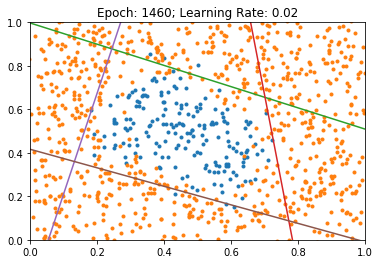

Epoch: 1470
G1-Weight: tensor([[-3.8492, -7.6318]]) G1-Bias: tensor([7.6707])
G2-Weight: tensor([[-8.8902, -0.9816]]) G2-Bias: tensor([6.9139])
G3-Weight: tensor([[ 8.4141, -1.9067]]) G1-Bias: tensor([-0.4032])
G4-Weight: tensor([[3.1417, 7.1355]]) G2-Bias: tensor([-3.0139])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.8492 * x + 7.6707) / -7.6318)
z2: y = -((-8.8902 * x + 6.9139) / -0.9816)
z3: y = -((8.4141 * x + -0.4032) / -1.9067)
z4: y = -((3.1417 * x + -3.0139) / 7.1355)
Beta-Gerade: 6.752574443817139
Beta-AND: -4.591948986053467


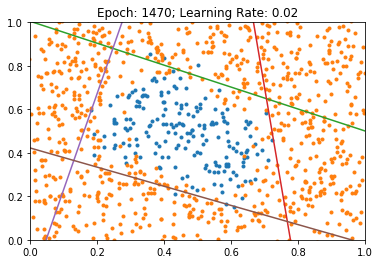

Epoch: 1480
G1-Weight: tensor([[-3.9611, -7.6196]]) G1-Bias: tensor([7.7137])
G2-Weight: tensor([[-8.9397, -0.8479]]) G2-Bias: tensor([6.8962])
G3-Weight: tensor([[ 8.3665, -1.9679]]) G1-Bias: tensor([-0.3538])
G4-Weight: tensor([[3.2449, 7.1599]]) G2-Bias: tensor([-3.0621])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-3.9611 * x + 7.7137) / -7.6196)
z2: y = -((-8.9397 * x + 6.8962) / -0.8479)
z3: y = -((8.3665 * x + -0.3538) / -1.9679)
z4: y = -((3.2449 * x + -3.0621) / 7.1599)
Beta-Gerade: 6.740495204925537
Beta-AND: -4.634403228759766


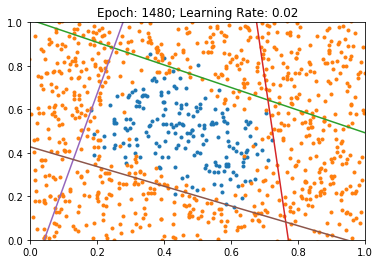

Epoch: 1490
G1-Weight: tensor([[-4.0670, -7.6143]]) G1-Bias: tensor([7.7582])
G2-Weight: tensor([[-8.9914, -0.7062]]) G2-Bias: tensor([6.8783])
G3-Weight: tensor([[ 8.3132, -2.0200]]) G1-Bias: tensor([-0.3039])
G4-Weight: tensor([[3.3406, 7.1848]]) G2-Bias: tensor([-3.1073])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.067 * x + 7.7582) / -7.6143)
z2: y = -((-8.9914 * x + 6.8783) / -0.7062)
z3: y = -((8.3132 * x + -0.3039) / -2.02)
z4: y = -((3.3406 * x + -3.1073) / 7.1848)
Beta-Gerade: 6.724618911743164
Beta-AND: -4.676515579223633


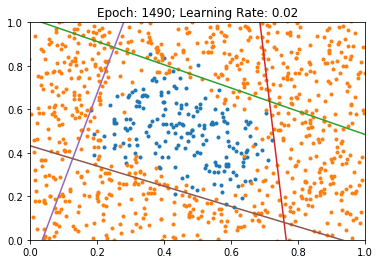

Epoch: 1500
G1-Weight: tensor([[-4.1671, -7.6144]]) G1-Bias: tensor([7.8051])
G2-Weight: tensor([[-9.0460, -0.5580]]) G2-Bias: tensor([6.8599])
G3-Weight: tensor([[ 8.2818, -2.0884]]) G1-Bias: tensor([-0.2555])
G4-Weight: tensor([[3.4347, 7.2084]]) G2-Bias: tensor([-3.1502])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.1671 * x + 7.8051) / -7.6144)
z2: y = -((-9.046 * x + 6.8599) / -0.558)
z3: y = -((8.2818 * x + -0.2555) / -2.0884)
z4: y = -((3.4347 * x + -3.1502) / 7.2084)
Beta-Gerade: 6.716557502746582
Beta-AND: -4.718296527862549


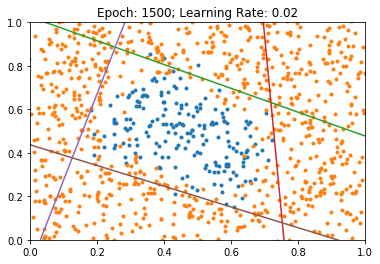

Epoch: 1510
G1-Weight: tensor([[-4.2662, -7.6177]]) G1-Bias: tensor([7.8541])
G2-Weight: tensor([[-9.1030, -0.4042]]) G2-Bias: tensor([6.8418])
G3-Weight: tensor([[ 8.2557, -2.1560]]) G1-Bias: tensor([-0.2082])
G4-Weight: tensor([[3.5291, 7.2299]]) G2-Bias: tensor([-3.1925])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.2662 * x + 7.8541) / -7.6177)
z2: y = -((-9.103 * x + 6.8418) / -0.4042)
z3: y = -((8.2557 * x + -0.2082) / -2.156)
z4: y = -((3.5291 * x + -3.1925) / 7.2299)
Beta-Gerade: 6.710718154907227
Beta-AND: -4.759746551513672


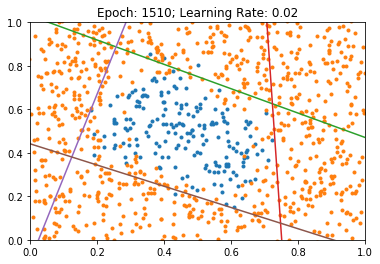

Epoch: 1520
G1-Weight: tensor([[-4.3667, -7.6227]]) G1-Bias: tensor([7.9045])
G2-Weight: tensor([[-9.1621, -0.2474]]) G2-Bias: tensor([6.8243])
G3-Weight: tensor([[ 8.2257, -2.2166]]) G1-Bias: tensor([-0.1638])
G4-Weight: tensor([[3.6255, 7.2489]]) G2-Bias: tensor([-3.2348])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.3667 * x + 7.9045) / -7.6227)
z2: y = -((-9.1621 * x + 6.8243) / -0.2474)
z3: y = -((8.2257 * x + -0.1638) / -2.2166)
z4: y = -((3.6255 * x + -3.2348) / 7.2489)
Beta-Gerade: 6.703638553619385
Beta-AND: -4.80087423324585


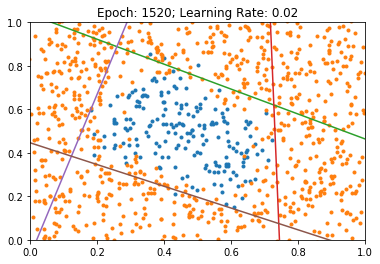

Epoch: 1530
G1-Weight: tensor([[-4.4612, -7.6138]]) G1-Bias: tensor([7.9420])
G2-Weight: tensor([[-9.2223, -0.0928]]) G2-Bias: tensor([6.8082])
G3-Weight: tensor([[ 8.1879, -2.2684]]) G1-Bias: tensor([-0.1226])
G4-Weight: tensor([[3.7243, 7.2660]]) G2-Bias: tensor([-3.2772])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.4612 * x + 7.942) / -7.6138)
z2: y = -((-9.2223 * x + 6.8082) / -0.0928)
z3: y = -((8.1879 * x + -0.1226) / -2.2684)
z4: y = -((3.7243 * x + -3.2772) / 7.266)
Beta-Gerade: 6.687499046325684
Beta-AND: -4.841685771942139


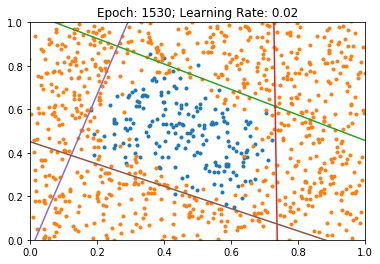

Epoch: 1540
G1-Weight: tensor([[-4.5481, -7.5998]]) G1-Bias: tensor([7.9742])
G2-Weight: tensor([[-9.2818,  0.0523]]) G2-Bias: tensor([6.7947])
G3-Weight: tensor([[ 8.1423, -2.3115]]) G1-Bias: tensor([-0.0824])
G4-Weight: tensor([[3.8250, 7.2824]]) G2-Bias: tensor([-3.3194])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.5481 * x + 7.9742) / -7.5998)
z2: y = -((-9.2818 * x + 6.7947) / 0.0523)
z3: y = -((8.1423 * x + -0.0824) / -2.3115)
z4: y = -((3.825 * x + -3.3194) / 7.2824)
Beta-Gerade: 6.662705421447754
Beta-AND: -4.882191181182861


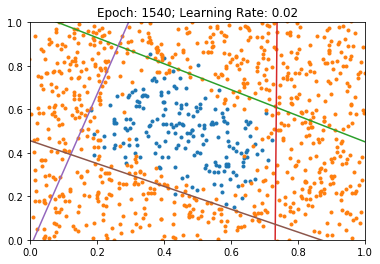

Epoch: 1550
G1-Weight: tensor([[-4.6283, -7.5939]]) G1-Bias: tensor([8.0095])
G2-Weight: tensor([[-9.3384,  0.1836]]) G2-Bias: tensor([6.7854])
G3-Weight: tensor([[ 8.1121, -2.3682]]) G1-Bias: tensor([-0.0382])
G4-Weight: tensor([[3.9269, 7.2987]]) G2-Bias: tensor([-3.3623])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.6283 * x + 8.0095) / -7.5939)
z2: y = -((-9.3384 * x + 6.7854) / 0.1836)
z3: y = -((8.1121 * x + -0.0382) / -2.3682)
z4: y = -((3.9269 * x + -3.3623) / 7.2987)
Beta-Gerade: 6.645577907562256
Beta-AND: -4.9224019050598145


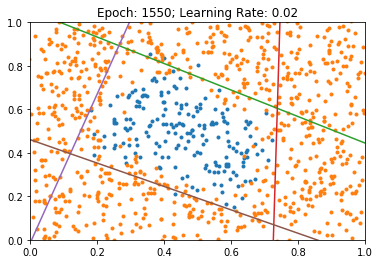

Epoch: 1560
G1-Weight: tensor([[-4.6991, -7.5873]]) G1-Bias: tensor([8.0394])
G2-Weight: tensor([[-9.3929,  0.3017]]) G2-Bias: tensor([6.7790])
G3-Weight: tensor([[ 8.0879, -2.4302]]) G1-Bias: tensor([0.0064])
G4-Weight: tensor([[4.0279, 7.3157]]) G2-Bias: tensor([-3.4058])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.6991 * x + 8.0394) / -7.5873)
z2: y = -((-9.3929 * x + 6.779) / 0.3017)
z3: y = -((8.0879 * x + 0.0064) / -2.4302)
z4: y = -((4.0279 * x + -3.4058) / 7.3157)
Beta-Gerade: 6.627679347991943
Beta-AND: -4.962310314178467


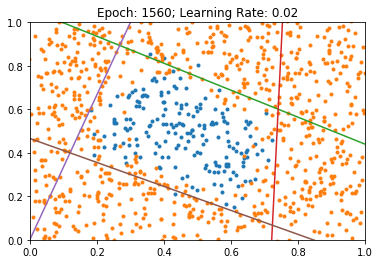

Epoch: 1570
G1-Weight: tensor([[-4.7626, -7.5831]]) G1-Bias: tensor([8.0684])
G2-Weight: tensor([[-9.4458,  0.4114]]) G2-Bias: tensor([6.7746])
G3-Weight: tensor([[ 8.0598, -2.4878]]) G1-Bias: tensor([0.0490])
G4-Weight: tensor([[4.1262, 7.3350]]) G2-Bias: tensor([-3.4492])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.7626 * x + 8.0684) / -7.5831)
z2: y = -((-9.4458 * x + 6.7746) / 0.4114)
z3: y = -((8.0598 * x + 0.049) / -2.4878)
z4: y = -((4.1262 * x + -3.4492) / 7.335)
Beta-Gerade: 6.608064651489258
Beta-AND: -5.001901149749756


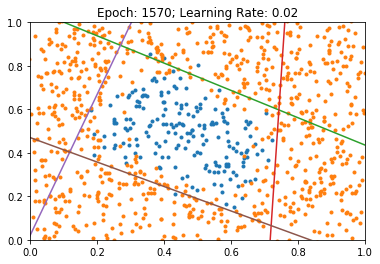

Epoch: 1580
G1-Weight: tensor([[-4.8224, -7.5852]]) G1-Bias: tensor([8.0996])
G2-Weight: tensor([[-9.4973,  0.5176]]) G2-Bias: tensor([6.7717])
G3-Weight: tensor([[ 8.0257, -2.5385]]) G1-Bias: tensor([0.0895])
G4-Weight: tensor([[4.2195, 7.3578]]) G2-Bias: tensor([-3.4919])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.8224 * x + 8.0996) / -7.5852)
z2: y = -((-9.4973 * x + 6.7717) / 0.5176)
z3: y = -((8.0257 * x + 0.0895) / -2.5385)
z4: y = -((4.2195 * x + -3.4919) / 7.3578)
Beta-Gerade: 6.587831974029541
Beta-AND: -5.041159629821777


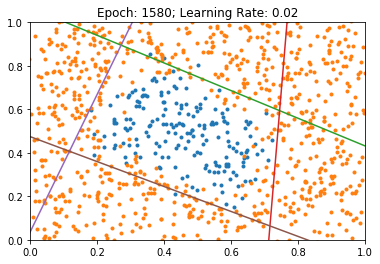

Epoch: 1590
G1-Weight: tensor([[-4.8783, -7.5882]]) G1-Bias: tensor([8.1304])
G2-Weight: tensor([[-9.5484,  0.6225]]) G2-Bias: tensor([6.7692])
G3-Weight: tensor([[ 7.9863, -2.5829]]) G1-Bias: tensor([0.1274])
G4-Weight: tensor([[4.3069, 7.3847]]) G2-Bias: tensor([-3.5335])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.8783 * x + 8.1304) / -7.5882)
z2: y = -((-9.5484 * x + 6.7692) / 0.6225)
z3: y = -((7.9863 * x + 0.1274) / -2.5829)
z4: y = -((4.3069 * x + -3.5335) / 7.3847)
Beta-Gerade: 6.565135955810547
Beta-AND: -5.080068111419678


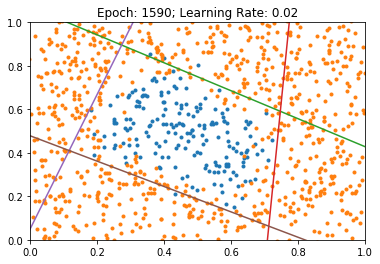

Epoch: 1600
G1-Weight: tensor([[-4.9329, -7.5934]]) G1-Bias: tensor([8.1614])
G2-Weight: tensor([[-9.5947,  0.7146]]) G2-Bias: tensor([6.7632])
G3-Weight: tensor([[ 7.9435, -2.6222]]) G1-Bias: tensor([0.1635])
G4-Weight: tensor([[4.3890, 7.4154]]) G2-Bias: tensor([-3.5737])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.9329 * x + 8.1614) / -7.5934)
z2: y = -((-9.5947 * x + 6.7632) / 0.7146)
z3: y = -((7.9435 * x + 0.1635) / -2.6222)
z4: y = -((4.389 * x + -3.5737) / 7.4154)
Beta-Gerade: 6.5394816398620605
Beta-AND: -5.118618011474609


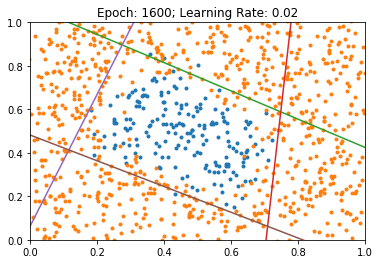

Epoch: 1610
G1-Weight: tensor([[-4.9817, -7.5991]]) G1-Bias: tensor([8.1911])
G2-Weight: tensor([[-9.6110,  0.7704]]) G2-Bias: tensor([6.7554])
G3-Weight: tensor([[ 7.9229, -2.6778]]) G1-Bias: tensor([0.2052])
G4-Weight: tensor([[4.4670, 7.4480]]) G2-Bias: tensor([-3.6144])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-4.9817 * x + 8.1911) / -7.5991)
z2: y = -((-9.611 * x + 6.7554) / 0.7704)
z3: y = -((7.9229 * x + 0.2052) / -2.6778)
z4: y = -((4.467 * x + -3.6144) / 7.448)
Beta-Gerade: 6.509406566619873
Beta-AND: -5.156795978546143


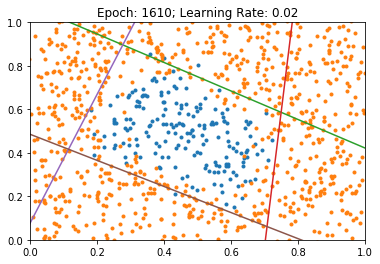

Epoch: 1620
G1-Weight: tensor([[-5.0248, -7.6042]]) G1-Bias: tensor([8.2166])
G2-Weight: tensor([[-9.6159,  0.8099]]) G2-Bias: tensor([6.7451])
G3-Weight: tensor([[ 7.9205, -2.7462]]) G1-Bias: tensor([0.2485])
G4-Weight: tensor([[4.5394, 7.4832]]) G2-Bias: tensor([-3.6543])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.0248 * x + 8.2166) / -7.6042)
z2: y = -((-9.6159 * x + 6.7451) / 0.8099)
z3: y = -((7.9205 * x + 0.2485) / -2.7462)
z4: y = -((4.5394 * x + -3.6543) / 7.4832)
Beta-Gerade: 6.479623317718506
Beta-AND: -5.194594860076904


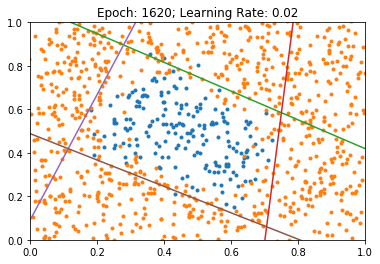

Epoch: 1630
G1-Weight: tensor([[-5.0615, -7.6064]]) G1-Bias: tensor([8.2380])
G2-Weight: tensor([[-9.6170,  0.8448]]) G2-Bias: tensor([6.7338])
G3-Weight: tensor([[ 7.9210, -2.8099]]) G1-Bias: tensor([0.2878])
G4-Weight: tensor([[4.6065, 7.5207]]) G2-Bias: tensor([-3.6927])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.0615 * x + 8.238) / -7.6064)
z2: y = -((-9.617 * x + 6.7338) / 0.8448)
z3: y = -((7.921 * x + 0.2878) / -2.8099)
z4: y = -((4.6065 * x + -3.6927) / 7.5207)
Beta-Gerade: 6.44655704498291
Beta-AND: -5.2320075035095215


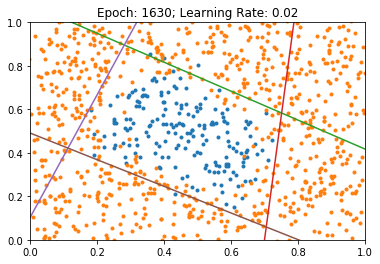

Epoch: 1640
G1-Weight: tensor([[-5.0998, -7.6153]]) G1-Bias: tensor([8.2658])
G2-Weight: tensor([[-9.6233,  0.8869]]) G2-Bias: tensor([6.7239])
G3-Weight: tensor([[ 7.9211, -2.8648]]) G1-Bias: tensor([0.3219])
G4-Weight: tensor([[4.6693, 7.5601]]) G2-Bias: tensor([-3.7296])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.0998 * x + 8.2658) / -7.6153)
z2: y = -((-9.6233 * x + 6.7239) / 0.8869)
z3: y = -((7.9211 * x + 0.3219) / -2.8648)
z4: y = -((4.6693 * x + -3.7296) / 7.5601)
Beta-Gerade: 6.416644096374512
Beta-AND: -5.269033908843994


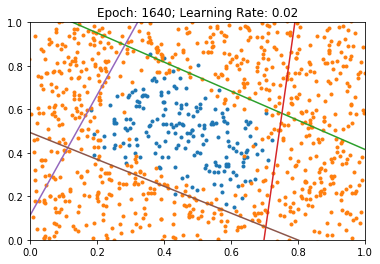

Epoch: 1650
G1-Weight: tensor([[-5.1439, -7.6339]]) G1-Bias: tensor([8.3011])
G2-Weight: tensor([[-9.6319,  0.9288]]) G2-Bias: tensor([6.7143])
G3-Weight: tensor([[ 7.9203, -2.9114]]) G1-Bias: tensor([0.3504])
G4-Weight: tensor([[4.7298, 7.6002]]) G2-Bias: tensor([-3.7652])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.1439 * x + 8.3011) / -7.6339)
z2: y = -((-9.6319 * x + 6.7143) / 0.9288)
z3: y = -((7.9203 * x + 0.3504) / -2.9114)
z4: y = -((4.7298 * x + -3.7652) / 7.6002)
Beta-Gerade: 6.393496513366699
Beta-AND: -5.305676460266113


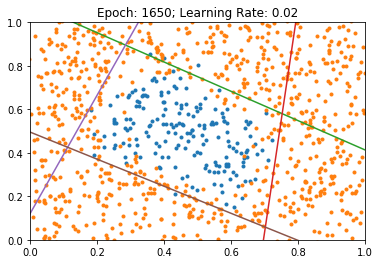

Epoch: 1660
G1-Weight: tensor([[-5.1854, -7.6499]]) G1-Bias: tensor([8.3339])
G2-Weight: tensor([[-9.6387,  0.9661]]) G2-Bias: tensor([6.7057])
G3-Weight: tensor([[ 7.9189, -2.9500]]) G1-Bias: tensor([0.3743])
G4-Weight: tensor([[4.7882, 7.6405]]) G2-Bias: tensor([-3.8006])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.1854 * x + 8.3339) / -7.6499)
z2: y = -((-9.6387 * x + 6.7057) / 0.9661)
z3: y = -((7.9189 * x + 0.3743) / -2.95)
z4: y = -((4.7882 * x + -3.8006) / 7.6405)
Beta-Gerade: 6.36719274520874
Beta-AND: -5.341933250427246


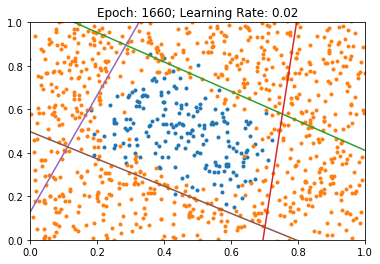

Epoch: 1670
G1-Weight: tensor([[-5.2262, -7.6660]]) G1-Bias: tensor([8.3654])
G2-Weight: tensor([[-9.6492,  1.0056]]) G2-Bias: tensor([6.6995])
G3-Weight: tensor([[ 7.9174, -2.9824]]) G1-Bias: tensor([0.3955])
G4-Weight: tensor([[4.8446, 7.6815]]) G2-Bias: tensor([-3.8347])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.2262 * x + 8.3654) / -7.666)
z2: y = -((-9.6492 * x + 6.6995) / 1.0056)
z3: y = -((7.9174 * x + 0.3955) / -2.9824)
z4: y = -((4.8446 * x + -3.8347) / 7.6815)
Beta-Gerade: 6.342092037200928
Beta-AND: -5.377808570861816


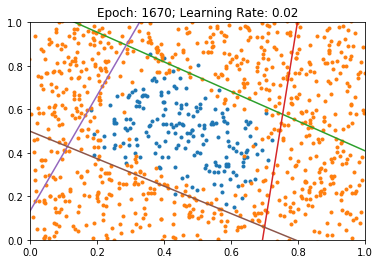

Epoch: 1680
G1-Weight: tensor([[-5.2632, -7.6798]]) G1-Bias: tensor([8.3948])
G2-Weight: tensor([[-9.6604,  1.0425]]) G2-Bias: tensor([6.6947])
G3-Weight: tensor([[ 7.9223, -3.0172]]) G1-Bias: tensor([0.4158])
G4-Weight: tensor([[4.8993, 7.7227]]) G2-Bias: tensor([-3.8682])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.2632 * x + 8.3948) / -7.6798)
z2: y = -((-9.6604 * x + 6.6947) / 1.0425)
z3: y = -((7.9223 * x + 0.4158) / -3.0172)
z4: y = -((4.8993 * x + -3.8682) / 7.7227)
Beta-Gerade: 6.317985534667969
Beta-AND: -5.413306713104248


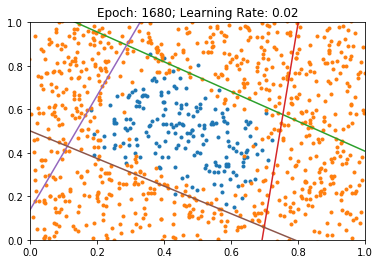

Epoch: 1690
G1-Weight: tensor([[-5.2990, -7.6940]]) G1-Bias: tensor([8.4216])
G2-Weight: tensor([[-9.6718,  1.0740]]) G2-Bias: tensor([6.6898])
G3-Weight: tensor([[ 7.9307, -3.0518]]) G1-Bias: tensor([0.4349])
G4-Weight: tensor([[4.9521, 7.7640]]) G2-Bias: tensor([-3.9016])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.299 * x + 8.4216) / -7.694)
z2: y = -((-9.6718 * x + 6.6898) / 1.074)
z3: y = -((7.9307 * x + 0.4349) / -3.0518)
z4: y = -((4.9521 * x + -3.9016) / 7.764)
Beta-Gerade: 6.294713020324707
Beta-AND: -5.448432922363281


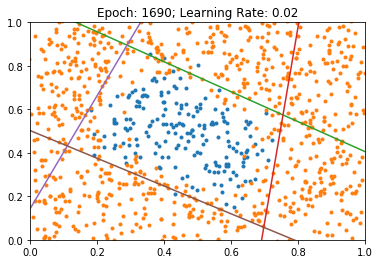

Epoch: 1700
G1-Weight: tensor([[-5.3312, -7.7060]]) G1-Bias: tensor([8.4479])
G2-Weight: tensor([[-9.6839,  1.1058]]) G2-Bias: tensor([6.6878])
G3-Weight: tensor([[ 7.9405, -3.0833]]) G1-Bias: tensor([0.4524])
G4-Weight: tensor([[5.0037, 7.8054]]) G2-Bias: tensor([-3.9342])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.3312 * x + 8.4479) / -7.706)
z2: y = -((-9.6839 * x + 6.6878) / 1.1058)
z3: y = -((7.9405 * x + 0.4524) / -3.0833)
z4: y = -((5.0037 * x + -3.9342) / 7.8054)
Beta-Gerade: 6.271527290344238
Beta-AND: -5.483193874359131


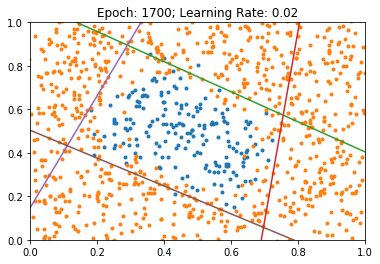

Epoch: 1710
G1-Weight: tensor([[-5.3618, -7.7174]]) G1-Bias: tensor([8.4707])
G2-Weight: tensor([[-9.6982,  1.1361]]) G2-Bias: tensor([6.6862])
G3-Weight: tensor([[ 7.9506, -3.1125]]) G1-Bias: tensor([0.4677])
G4-Weight: tensor([[5.0536, 7.8468]]) G2-Bias: tensor([-3.9663])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.3618 * x + 8.4707) / -7.7174)
z2: y = -((-9.6982 * x + 6.6862) / 1.1361)
z3: y = -((7.9506 * x + 0.4677) / -3.1125)
z4: y = -((5.0536 * x + -3.9663) / 7.8468)
Beta-Gerade: 6.2480573654174805
Beta-AND: -5.517596244812012


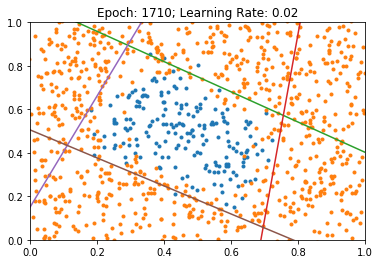

Epoch: 1720
G1-Weight: tensor([[-5.3898, -7.7277]]) G1-Bias: tensor([8.4937])
G2-Weight: tensor([[-9.7132,  1.1673]]) G2-Bias: tensor([6.6876])
G3-Weight: tensor([[ 7.9607, -3.1388]]) G1-Bias: tensor([0.4814])
G4-Weight: tensor([[5.1025, 7.8885]]) G2-Bias: tensor([-3.9976])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.3898 * x + 8.4937) / -7.7277)
z2: y = -((-9.7132 * x + 6.6876) / 1.1673)
z3: y = -((7.9607 * x + 0.4814) / -3.1388)
z4: y = -((5.1025 * x + -3.9976) / 7.8885)
Beta-Gerade: 6.224464416503906
Beta-AND: -5.5516462326049805


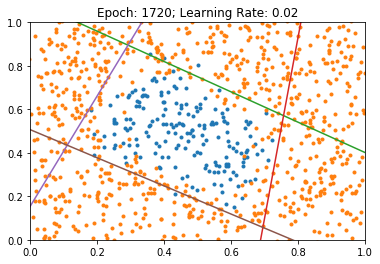

Epoch: 1730
G1-Weight: tensor([[-5.4212, -7.7428]]) G1-Bias: tensor([8.5184])
G2-Weight: tensor([[-9.7285,  1.1931]]) G2-Bias: tensor([6.6878])
G3-Weight: tensor([[ 7.9707, -3.1633]]) G1-Bias: tensor([0.4937])
G4-Weight: tensor([[5.1498, 7.9300]]) G2-Bias: tensor([-4.0288])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.4212 * x + 8.5184) / -7.7428)
z2: y = -((-9.7285 * x + 6.6878) / 1.1931)
z3: y = -((7.9707 * x + 0.4937) / -3.1633)
z4: y = -((5.1498 * x + -4.0288) / 7.93)
Beta-Gerade: 6.203208923339844
Beta-AND: -5.58535099029541


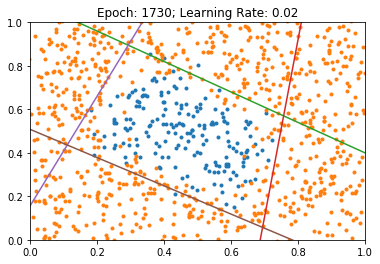

Epoch: 1740
G1-Weight: tensor([[-5.4504, -7.7578]]) G1-Bias: tensor([8.5457])
G2-Weight: tensor([[-9.7433,  1.2183]]) G2-Bias: tensor([6.6899])
G3-Weight: tensor([[ 7.9807, -3.1854]]) G1-Bias: tensor([0.5057])
G4-Weight: tensor([[5.1959, 7.9717]]) G2-Bias: tensor([-4.0593])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.4504 * x + 8.5457) / -7.7578)
z2: y = -((-9.7433 * x + 6.6899) / 1.2183)
z3: y = -((7.9807 * x + 0.5057) / -3.1854)
z4: y = -((5.1959 * x + -4.0593) / 7.9717)
Beta-Gerade: 6.182159900665283
Beta-AND: -5.618714809417725


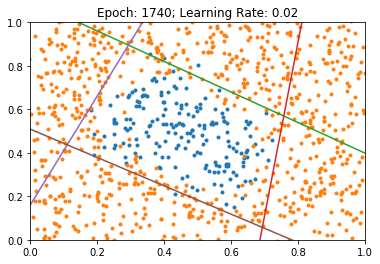

Epoch: 1750
G1-Weight: tensor([[-5.4797, -7.7742]]) G1-Bias: tensor([8.5708])
G2-Weight: tensor([[-9.7580,  1.2408]]) G2-Bias: tensor([6.6917])
G3-Weight: tensor([[ 7.9903, -3.2069]]) G1-Bias: tensor([0.5162])
G4-Weight: tensor([[5.2407, 8.0132]]) G2-Bias: tensor([-4.0894])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.4797 * x + 8.5708) / -7.7742)
z2: y = -((-9.758 * x + 6.6917) / 1.2408)
z3: y = -((7.9903 * x + 0.5162) / -3.2069)
z4: y = -((5.2407 * x + -4.0894) / 8.0132)
Beta-Gerade: 6.161134243011475
Beta-AND: -5.651744365692139


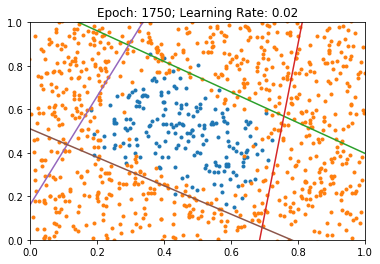

Epoch: 1760
G1-Weight: tensor([[-5.5070, -7.7896]]) G1-Bias: tensor([8.5956])
G2-Weight: tensor([[-9.7758,  1.2653]]) G2-Bias: tensor([6.6942])
G3-Weight: tensor([[ 7.9998, -3.2270]]) G1-Bias: tensor([0.5262])
G4-Weight: tensor([[5.2845, 8.0548]]) G2-Bias: tensor([-4.1188])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.507 * x + 8.5956) / -7.7896)
z2: y = -((-9.7758 * x + 6.6942) / 1.2653)
z3: y = -((7.9998 * x + 0.5262) / -3.227)
z4: y = -((5.2845 * x + -4.1188) / 8.0548)
Beta-Gerade: 6.1407341957092285
Beta-AND: -5.684447288513184


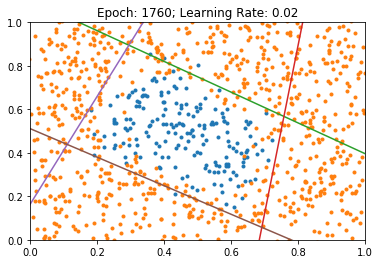

Epoch: 1770
G1-Weight: tensor([[-5.5329, -7.8045]]) G1-Bias: tensor([8.6192])
G2-Weight: tensor([[-9.7916,  1.2878]]) G2-Bias: tensor([6.6982])
G3-Weight: tensor([[ 8.0092, -3.2460]]) G1-Bias: tensor([0.5358])
G4-Weight: tensor([[5.3274, 8.0960]]) G2-Bias: tensor([-4.1482])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.5329 * x + 8.6192) / -7.8045)
z2: y = -((-9.7916 * x + 6.6982) / 1.2878)
z3: y = -((8.0092 * x + 0.5358) / -3.246)
z4: y = -((5.3274 * x + -4.1482) / 8.096)
Beta-Gerade: 6.1192946434021
Beta-AND: -5.716830253601074


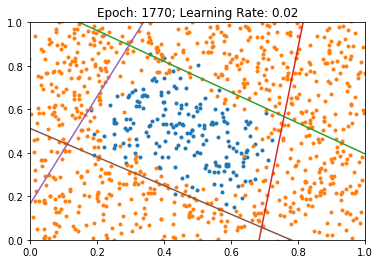

Epoch: 1780
G1-Weight: tensor([[-5.5576, -7.8185]]) G1-Bias: tensor([8.6419])
G2-Weight: tensor([[-9.8103,  1.3124]]) G2-Bias: tensor([6.7029])
G3-Weight: tensor([[ 8.0185, -3.2642]]) G1-Bias: tensor([0.5448])
G4-Weight: tensor([[5.3698, 8.1370]]) G2-Bias: tensor([-4.1768])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.5576 * x + 8.6419) / -7.8185)
z2: y = -((-9.8103 * x + 6.7029) / 1.3124)
z3: y = -((8.0185 * x + 0.5448) / -3.2642)
z4: y = -((5.3698 * x + -4.1768) / 8.137)
Beta-Gerade: 6.0981526374816895
Beta-AND: -5.748901844024658


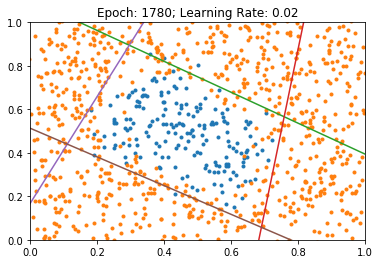

Epoch: 1790
G1-Weight: tensor([[-5.5820, -7.8325]]) G1-Bias: tensor([8.6627])
G2-Weight: tensor([[-9.8287,  1.3344]]) G2-Bias: tensor([6.7072])
G3-Weight: tensor([[ 8.0277, -3.2818]]) G1-Bias: tensor([0.5533])
G4-Weight: tensor([[5.4113, 8.1775]]) G2-Bias: tensor([-4.2056])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.582 * x + 8.6627) / -7.8325)
z2: y = -((-9.8287 * x + 6.7072) / 1.3344)
z3: y = -((8.0277 * x + 0.5533) / -3.2818)
z4: y = -((5.4113 * x + -4.2056) / 8.1775)
Beta-Gerade: 6.076620101928711
Beta-AND: -5.78066873550415


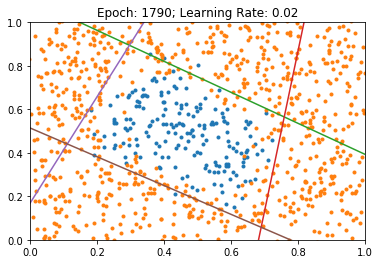

Epoch: 1800
G1-Weight: tensor([[-5.6054, -7.8463]]) G1-Bias: tensor([8.6856])
G2-Weight: tensor([[-9.8478,  1.3563]]) G2-Bias: tensor([6.7121])
G3-Weight: tensor([[ 8.0369, -3.2986]]) G1-Bias: tensor([0.5617])
G4-Weight: tensor([[5.4524, 8.2178]]) G2-Bias: tensor([-4.2338])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.6054 * x + 8.6856) / -7.8463)
z2: y = -((-9.8478 * x + 6.7121) / 1.3563)
z3: y = -((8.0369 * x + 0.5617) / -3.2986)
z4: y = -((5.4524 * x + -4.2338) / 8.2178)
Beta-Gerade: 6.055530071258545
Beta-AND: -5.812140941619873


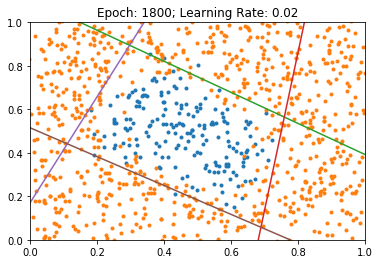

Epoch: 1810
G1-Weight: tensor([[-5.6314, -7.8644]]) G1-Bias: tensor([8.7108])
G2-Weight: tensor([[-9.8637,  1.3748]]) G2-Bias: tensor([6.7179])
G3-Weight: tensor([[ 8.0510, -3.3193]]) G1-Bias: tensor([0.5708])
G4-Weight: tensor([[5.4933, 8.2576]]) G2-Bias: tensor([-4.2617])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.6314 * x + 8.7108) / -7.8644)
z2: y = -((-9.8637 * x + 6.7179) / 1.3748)
z3: y = -((8.051 * x + 0.5708) / -3.3193)
z4: y = -((5.4933 * x + -4.2617) / 8.2576)
Beta-Gerade: 6.038015842437744
Beta-AND: -5.843326091766357


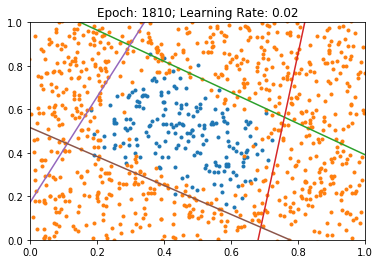

Epoch: 1820
G1-Weight: tensor([[-5.6544, -7.8794]]) G1-Bias: tensor([8.7333])
G2-Weight: tensor([[-9.8821,  1.3930]]) G2-Bias: tensor([6.7219])
G3-Weight: tensor([[ 8.0673, -3.3406]]) G1-Bias: tensor([0.5800])
G4-Weight: tensor([[5.5334, 8.2971]]) G2-Bias: tensor([-4.2893])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.6544 * x + 8.7333) / -7.8794)
z2: y = -((-9.8821 * x + 6.7219) / 1.393)
z3: y = -((8.0673 * x + 0.58) / -3.3406)
z4: y = -((5.5334 * x + -4.2893) / 8.2971)
Beta-Gerade: 6.01948356628418
Beta-AND: -5.874229431152344


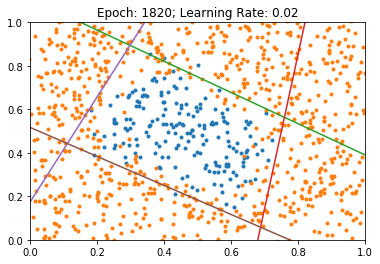

Epoch: 1830
G1-Weight: tensor([[-5.6788, -7.8970]]) G1-Bias: tensor([8.7575])
G2-Weight: tensor([[-9.8971,  1.4112]]) G2-Bias: tensor([6.7286])
G3-Weight: tensor([[ 8.0832, -3.3601]]) G1-Bias: tensor([0.5890])
G4-Weight: tensor([[5.5731, 8.3361]]) G2-Bias: tensor([-4.3166])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.6788 * x + 8.7575) / -7.897)
z2: y = -((-9.8971 * x + 6.7286) / 1.4112)
z3: y = -((8.0832 * x + 0.589) / -3.3601)
z4: y = -((5.5731 * x + -4.3166) / 8.3361)
Beta-Gerade: 6.002049446105957
Beta-AND: -5.904858589172363


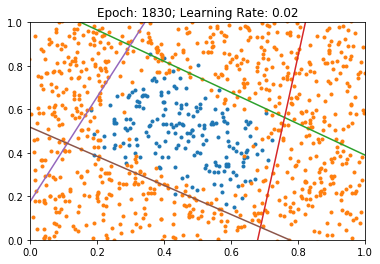

Epoch: 1840
G1-Weight: tensor([[-5.7012, -7.9126]]) G1-Bias: tensor([8.7802])
G2-Weight: tensor([[-9.9152,  1.4301]]) G2-Bias: tensor([6.7336])
G3-Weight: tensor([[ 8.0990, -3.3807]]) G1-Bias: tensor([0.5962])
G4-Weight: tensor([[5.6119, 8.3748]]) G2-Bias: tensor([-4.3437])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.7012 * x + 8.7802) / -7.9126)
z2: y = -((-9.9152 * x + 6.7336) / 1.4301)
z3: y = -((8.099 * x + 0.5962) / -3.3807)
z4: y = -((5.6119 * x + -4.3437) / 8.3748)
Beta-Gerade: 5.9839372634887695
Beta-AND: -5.935220718383789


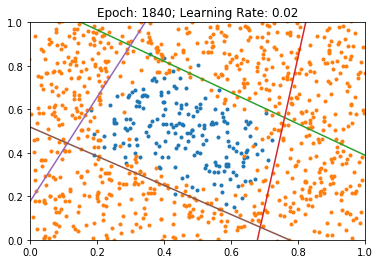

Epoch: 1850
G1-Weight: tensor([[-5.7250, -7.9302]]) G1-Bias: tensor([8.8036])
G2-Weight: tensor([[-9.9305,  1.4458]]) G2-Bias: tensor([6.7385])
G3-Weight: tensor([[ 8.1156, -3.3987]]) G1-Bias: tensor([0.6049])
G4-Weight: tensor([[5.6503, 8.4133]]) G2-Bias: tensor([-4.3704])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.725 * x + 8.8036) / -7.9302)
z2: y = -((-9.9305 * x + 6.7385) / 1.4458)
z3: y = -((8.1156 * x + 0.6049) / -3.3987)
z4: y = -((5.6503 * x + -4.3704) / 8.4133)
Beta-Gerade: 5.9662370681762695
Beta-AND: -5.965322494506836


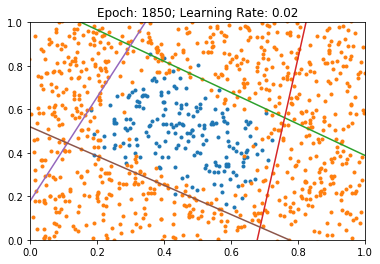

Epoch: 1860
G1-Weight: tensor([[-5.7469, -7.9461]]) G1-Bias: tensor([8.8269])
G2-Weight: tensor([[-9.9489,  1.4663]]) G2-Bias: tensor([6.7446])
G3-Weight: tensor([[ 8.1312, -3.4174]]) G1-Bias: tensor([0.6117])
G4-Weight: tensor([[5.6881, 8.4514]]) G2-Bias: tensor([-4.3967])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.7469 * x + 8.8269) / -7.9461)
z2: y = -((-9.9489 * x + 6.7446) / 1.4663)
z3: y = -((8.1312 * x + 0.6117) / -3.4174)
z4: y = -((5.6881 * x + -4.3967) / 8.4514)
Beta-Gerade: 5.948945999145508
Beta-AND: -5.9951701164245605


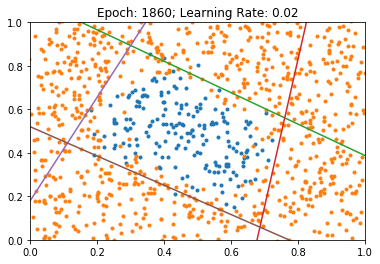

Epoch: 1870
G1-Weight: tensor([[-5.7703, -7.9642]]) G1-Bias: tensor([8.8506])
G2-Weight: tensor([[-9.9638,  1.4811]]) G2-Bias: tensor([6.7493])
G3-Weight: tensor([[ 8.1488, -3.4358]]) G1-Bias: tensor([0.6196])
G4-Weight: tensor([[5.7257, 8.4891]]) G2-Bias: tensor([-4.4226])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.7703 * x + 8.8506) / -7.9642)
z2: y = -((-9.9638 * x + 6.7493) / 1.4811)
z3: y = -((8.1488 * x + 0.6196) / -3.4358)
z4: y = -((5.7257 * x + -4.4226) / 8.4891)
Beta-Gerade: 5.9318766593933105
Beta-AND: -6.024770259857178


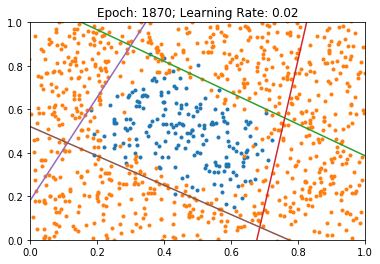

Epoch: 1880
G1-Weight: tensor([[-5.7929, -7.9811]]) G1-Bias: tensor([8.8719])
G2-Weight: tensor([[-9.9830,  1.5005]]) G2-Bias: tensor([6.7545])
G3-Weight: tensor([[ 8.1646, -3.4542]]) G1-Bias: tensor([0.6259])
G4-Weight: tensor([[5.7625, 8.5263]]) G2-Bias: tensor([-4.4477])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.7929 * x + 8.8719) / -7.9811)
z2: y = -((-9.983 * x + 6.7545) / 1.5005)
z3: y = -((8.1646 * x + 0.6259) / -3.4542)
z4: y = -((5.7625 * x + -4.4477) / 8.5263)
Beta-Gerade: 5.914886951446533
Beta-AND: -6.0541276931762695


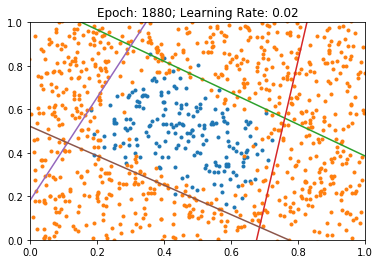

Epoch: 1890
G1-Weight: tensor([[-5.8156, -7.9990]]) G1-Bias: tensor([8.8964])
G2-Weight: tensor([[-9.9985,  1.5168]]) G2-Bias: tensor([6.7602])
G3-Weight: tensor([[ 8.1809, -3.4718]]) G1-Bias: tensor([0.6326])
G4-Weight: tensor([[5.7985, 8.5628]]) G2-Bias: tensor([-4.4731])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.8156 * x + 8.8964) / -7.999)
z2: y = -((-9.9985 * x + 6.7602) / 1.5168)
z3: y = -((8.1809 * x + 0.6326) / -3.4718)
z4: y = -((5.7985 * x + -4.4731) / 8.5628)
Beta-Gerade: 5.897891044616699
Beta-AND: -6.083250045776367


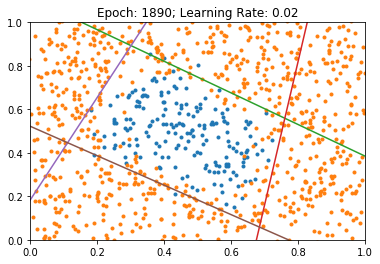

Epoch: 1900
G1-Weight: tensor([[-5.8367, -8.0152]]) G1-Bias: tensor([8.9182])
G2-Weight: tensor([[-10.0161,   1.5352]]) G2-Bias: tensor([6.7660])
G3-Weight: tensor([[ 8.1999, -3.4903]]) G1-Bias: tensor([0.6404])
G4-Weight: tensor([[5.8342, 8.5990]]) G2-Bias: tensor([-4.4979])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.8367 * x + 8.9182) / -8.0152)
z2: y = -((-10.0161 * x + 6.766) / 1.5352)
z3: y = -((8.1999 * x + 0.6404) / -3.4903)
z4: y = -((5.8342 * x + -4.4979) / 8.599)
Beta-Gerade: 5.881032466888428
Beta-AND: -6.112142562866211


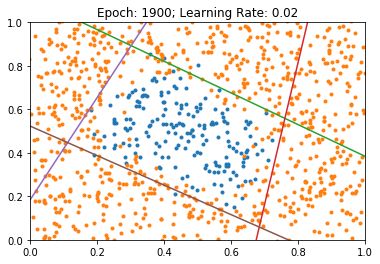

Epoch: 1910
G1-Weight: tensor([[-5.8601, -8.0342]]) G1-Bias: tensor([8.9434])
G2-Weight: tensor([[-10.0328,   1.5517]]) G2-Bias: tensor([6.7713])
G3-Weight: tensor([[ 8.2150, -3.5065]]) G1-Bias: tensor([0.6466])
G4-Weight: tensor([[5.8692, 8.6347]]) G2-Bias: tensor([-4.5226])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.8601 * x + 8.9434) / -8.0342)
z2: y = -((-10.0328 * x + 6.7713) / 1.5517)
z3: y = -((8.215 * x + 0.6466) / -3.5065)
z4: y = -((5.8692 * x + -4.5226) / 8.6347)
Beta-Gerade: 5.864296913146973
Beta-AND: -6.140810966491699


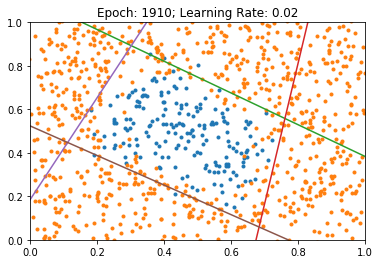

Epoch: 1920
G1-Weight: tensor([[-5.8805, -8.0500]]) G1-Bias: tensor([8.9657])
G2-Weight: tensor([[-10.0507,   1.5700]]) G2-Bias: tensor([6.7772])
G3-Weight: tensor([[ 8.2332, -3.5247]]) G1-Bias: tensor([0.6536])
G4-Weight: tensor([[5.9041, 8.6702]]) G2-Bias: tensor([-4.5468])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.8805 * x + 8.9657) / -8.05)
z2: y = -((-10.0507 * x + 6.7772) / 1.57)
z3: y = -((8.2332 * x + 0.6536) / -3.5247)
z4: y = -((5.9041 * x + -4.5468) / 8.6702)
Beta-Gerade: 5.847366809844971
Beta-AND: -6.169261455535889


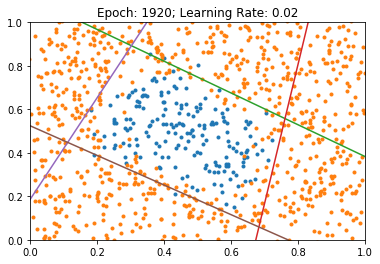

Epoch: 1930
G1-Weight: tensor([[-5.9033, -8.0688]]) G1-Bias: tensor([8.9893])
G2-Weight: tensor([[-10.0661,   1.5864]]) G2-Bias: tensor([6.7838])
G3-Weight: tensor([[ 8.2492, -3.5413]]) G1-Bias: tensor([0.6599])
G4-Weight: tensor([[5.9383, 8.7052]]) G2-Bias: tensor([-4.5711])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.9033 * x + 8.9893) / -8.0688)
z2: y = -((-10.0661 * x + 6.7838) / 1.5864)
z3: y = -((8.2492 * x + 0.6599) / -3.5413)
z4: y = -((5.9383 * x + -4.5711) / 8.7052)
Beta-Gerade: 5.830827713012695
Beta-AND: -6.197498798370361


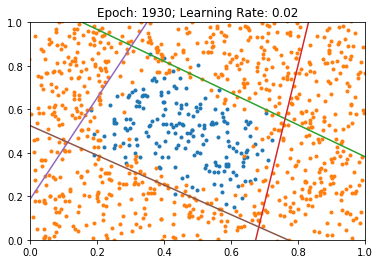

Epoch: 1940
G1-Weight: tensor([[-5.9244, -8.0858]]) G1-Bias: tensor([9.0118])
G2-Weight: tensor([[-10.0837,   1.6041]]) G2-Bias: tensor([6.7897])
G3-Weight: tensor([[ 8.2673, -3.5600]]) G1-Bias: tensor([0.6661])
G4-Weight: tensor([[5.9723, 8.7398]]) G2-Bias: tensor([-4.5950])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.9244 * x + 9.0118) / -8.0858)
z2: y = -((-10.0837 * x + 6.7897) / 1.6041)
z3: y = -((8.2673 * x + 0.6661) / -3.56)
z4: y = -((5.9723 * x + -4.595) / 8.7398)
Beta-Gerade: 5.814920902252197
Beta-AND: -6.225528240203857


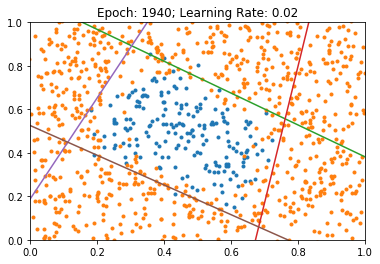

Epoch: 1950
G1-Weight: tensor([[-5.9456, -8.1029]]) G1-Bias: tensor([9.0349])
G2-Weight: tensor([[-10.1015,   1.6212]]) G2-Bias: tensor([6.7954])
G3-Weight: tensor([[ 8.2832, -3.5756]]) G1-Bias: tensor([0.6725])
G4-Weight: tensor([[6.0057, 8.7742]]) G2-Bias: tensor([-4.6186])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.9456 * x + 9.0349) / -8.1029)
z2: y = -((-10.1015 * x + 6.7954) / 1.6212)
z3: y = -((8.2832 * x + 0.6725) / -3.5756)
z4: y = -((6.0057 * x + -4.6186) / 8.7742)
Beta-Gerade: 5.798162937164307
Beta-AND: -6.253355979919434


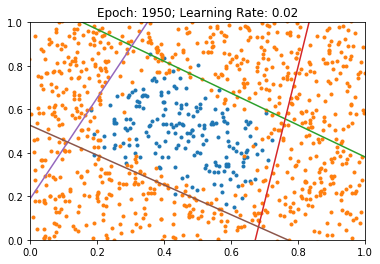

Epoch: 1960
G1-Weight: tensor([[-5.9681, -8.1217]]) G1-Bias: tensor([9.0570])
G2-Weight: tensor([[-10.1171,   1.6370]]) G2-Bias: tensor([6.8018])
G3-Weight: tensor([[ 8.3023, -3.5935]]) G1-Bias: tensor([0.6798])
G4-Weight: tensor([[6.0391, 8.8081]]) G2-Bias: tensor([-4.6419])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.9681 * x + 9.057) / -8.1217)
z2: y = -((-10.1171 * x + 6.8018) / 1.637)
z3: y = -((8.3023 * x + 0.6798) / -3.5935)
z4: y = -((6.0391 * x + -4.6419) / 8.8081)
Beta-Gerade: 5.782358646392822
Beta-AND: -6.280984878540039


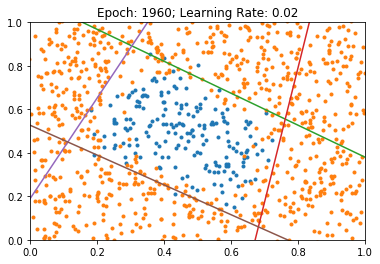

Epoch: 1970
G1-Weight: tensor([[-5.9881, -8.1379]]) G1-Bias: tensor([9.0808])
G2-Weight: tensor([[-10.1360,   1.6544]]) G2-Bias: tensor([6.8072])
G3-Weight: tensor([[ 8.3169, -3.6095]]) G1-Bias: tensor([0.6847])
G4-Weight: tensor([[6.0719, 8.8417]]) G2-Bias: tensor([-4.6650])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-5.9881 * x + 9.0808) / -8.1379)
z2: y = -((-10.136 * x + 6.8072) / 1.6544)
z3: y = -((8.3169 * x + 0.6847) / -3.6095)
z4: y = -((6.0719 * x + -4.665) / 8.8417)
Beta-Gerade: 5.765606880187988
Beta-AND: -6.308421611785889


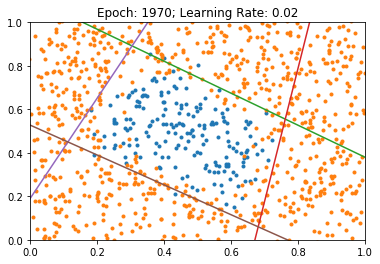

Epoch: 1980
G1-Weight: tensor([[-6.0097, -8.1563]]) G1-Bias: tensor([9.1034])
G2-Weight: tensor([[-10.1507,   1.6673]]) G2-Bias: tensor([6.8125])
G3-Weight: tensor([[ 8.3369, -3.6270]]) G1-Bias: tensor([0.6927])
G4-Weight: tensor([[6.1046, 8.8750]]) G2-Bias: tensor([-4.6877])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-6.0097 * x + 9.1034) / -8.1563)
z2: y = -((-10.1507 * x + 6.8125) / 1.6673)
z3: y = -((8.3369 * x + 0.6927) / -3.627)
z4: y = -((6.1046 * x + -4.6877) / 8.875)
Beta-Gerade: 5.749570369720459
Beta-AND: -6.335668087005615


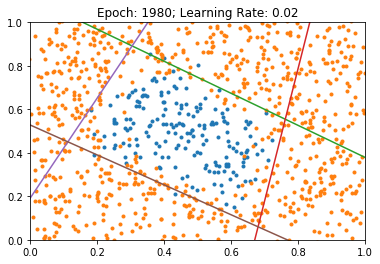

Epoch: 1990
G1-Weight: tensor([[-6.0310, -8.1742]]) G1-Bias: tensor([9.1265])
G2-Weight: tensor([[-10.1692,   1.6870]]) G2-Bias: tensor([6.8199])
G3-Weight: tensor([[ 8.3517, -3.6433]]) G1-Bias: tensor([0.6974])
G4-Weight: tensor([[6.1365, 8.9080]]) G2-Bias: tensor([-4.7103])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-6.031 * x + 9.1265) / -8.1742)
z2: y = -((-10.1692 * x + 6.8199) / 1.687)
z3: y = -((8.3517 * x + 0.6974) / -3.6433)
z4: y = -((6.1365 * x + -4.7103) / 8.908)
Beta-Gerade: 5.73359489440918
Beta-AND: -6.362730026245117


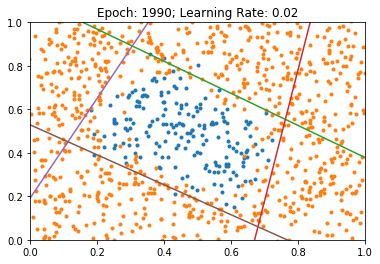

Epoch: 2000
G1-Weight: tensor([[-6.0519, -8.1918]]) G1-Bias: tensor([9.1486])
G2-Weight: tensor([[-10.1867,   1.7027]]) G2-Bias: tensor([6.8256])
G3-Weight: tensor([[ 8.3694, -3.6601]]) G1-Bias: tensor([0.7039])
G4-Weight: tensor([[6.1683, 8.9405]]) G2-Bias: tensor([-4.7326])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-6.0519 * x + 9.1486) / -8.1918)
z2: y = -((-10.1867 * x + 6.8256) / 1.7027)
z3: y = -((8.3694 * x + 0.7039) / -3.6601)
z4: y = -((6.1683 * x + -4.7326) / 8.9405)
Beta-Gerade: 5.718435287475586
Beta-AND: -6.389611721038818


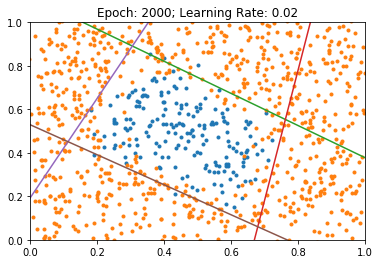

In [14]:
learning_rate = 0.02
network = Net4()
# gute werte -> lr = .0001, Epochen = 60k
# sehr gute werte -> lr=0.00005, Epochen = 140k
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

x = torch.linspace(-3, 3)

for epoch in range(2001):
    preds = network(trainX)
    #print(preds)
    loss = criterion(preds, trainY) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Calculate Gradient
    optimizer.step() # Update Weights
    if epoch %10 == 0:
        print("Epoch:", epoch)
        print("G1-Weight:",network.g1_layer.weight.data,"G1-Bias:",network.g1_layer.bias.data)
        print("G2-Weight:",network.g2_layer.weight.data,"G2-Bias:", network.g2_layer.bias.data)
        print("G3-Weight:",network.g3_layer.weight.data,"G1-Bias:",network.g3_layer.bias.data)
        print("G4-Weight:",network.g4_layer.weight.data,"G2-Bias:", network.g4_layer.bias.data)

        #print("AND-Weight G1G2:", network.undg1g2.weight.data, "AND-Bias:", network.undg1g2.bias.data)
        #print("AND-Weight G3G4:", network.undg3g4.weight.data, "AND-Bias:", network.undg3g4.bias.data)
        print("AND-Weight GOut:", network.undgout.weight.data, "AND-Bias:", network.undgout.bias.data)

        y1 = -((network.g1_layer.weight.squeeze()[0] * x + network.g1_layer.bias[0]) / network.g1_layer.weight.squeeze()[1])
        y2 = -((network.g2_layer.weight.squeeze()[0] * x + network.g2_layer.bias[0]) / network.g2_layer.weight.squeeze()[1])
        y3 = -((network.g3_layer.weight.squeeze()[0] * x + network.g3_layer.bias[0]) / network.g3_layer.weight.squeeze()[1])
        y4 = -((network.g4_layer.weight.squeeze()[0] * x + network.g4_layer.bias[0]) / network.g4_layer.weight.squeeze()[1])
        print(f'z1: y = -(({round(float(network.g1_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g1_layer.bias[0]),4)}) / {round(float(network.g1_layer.weight.squeeze()[1]), 4)})')
        print(f'z2: y = -(({round(float(network.g2_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g2_layer.bias[0]),4)}) / {round(float(network.g2_layer.weight.squeeze()[1]), 4)})')
        print(f'z3: y = -(({round(float(network.g3_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g3_layer.bias[0]),4)}) / {round(float(network.g3_layer.weight.squeeze()[1]), 4)})')
        print(f'z4: y = -(({round(float(network.g4_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g4_layer.bias[0]),4)}) / {round(float(network.g4_layer.weight.squeeze()[1]), 4)})')
        
    
        plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
        plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

        plt.plot(x.numpy(), y1.detach().numpy(), '-')
        plt.plot(x.numpy(), y2.detach().numpy(), '-')
        plt.plot(x.numpy(), y3.detach().numpy(), '-')
        plt.plot(x.numpy(), y4.detach().numpy(), '-')
        #print("Beta:", betas)
        print("Beta-Gerade:", betagerade)
        print("Beta-AND:", betaand)
        plt.ylim(0,1)
        plt.xlim(0,1)
        plt.title(f'Epoch: {epoch}; Learning Rate: {learning_rate}')
        plt.savefig(f'./plot/{epoch}.png', dpi=300, transparent=True, bbox_inches='tight')
        plt.show()